## Initial setup
This analysis using ema is based on the work of Enayat A. Moallemi created on 22 May 2018 at the Fraunhofer ISI, Karlsruhe. In that instance, the analysis was done for the MATISSE model.
This notebook present a second stage on a SA and UA. It is a variance-based approach using the SOBOL. 
For this, The EMA workbench is used with SALib SOBOL sampler and SALib analyse methods.
    

In [2]:

'''
by Angela M. Rojas A. <angelara@student.unimelb.edu.au>

Created on February 2020

'''
import sys
import os

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench')

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
import os
import glob
import numpy as np
import pandas as pd
import os
import glob

## SOBOL visualization functions
source code from [here](https://pynetlogo.readthedocs.io/en/latest/_docs/SALib_ipyparallel.html) code-block 25

In [3]:
import itertools
from math import pi


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, uncertainties, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15#25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=uncertainties)

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=uncertainties,
                      columns=uncertainties)
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = uncertainties
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)

    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.75), borderaxespad=0.1, mode='expand',
              handler_map={plt.Circle: HandlerCircle()})

## Load the results
These results are a tuple of one data frame with the changes on each input variable, and a dictionary with the outputs. 

In [4]:
from ema_workbench import load_results

results = load_results(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/gr4sp_2020-Jul-11-SOBOL.tar.gz')


In [5]:
experiments, outcomes = results

# Create a temporary copy of dictionary, with Outcomes Year
outcomesYear = dict(outcomes)

keysToRemove = [] 
# Iterate over the temporary dictionary and delete corresponding key from original dictionary
for (key, value) in outcomesYear.items() :
    if 'Month' in key:
        keysToRemove.append(key)
        
for k in keysToRemove:        
    del outcomesYear[k]   
    
        

In [6]:
experiments.describe()



annualCpi  annualInflation  capacityFactorChangeBrownCoal  \
count  49152.000000     49152.000000                   49152.000000   
mean       0.030000         0.030009                      -0.012695   
std        0.011547         0.011547                       6.058842   
min        0.010020         0.010020                     -10.000000   
25%        0.020010         0.020010                      -5.000000   
50%        0.030000         0.030000                       0.000000   
75%        0.039990         0.039990                       5.000000   
max        0.049980         0.049980                      10.000000   

       capacityFactorChangeWater   consumption  energyEfficiency  \
count               49152.000000  49152.000000      49152.000000   
mean                   -0.003418      2.002930          0.998535   
std                     6.057041      1.415605          0.816404   
min                   -10.000000      0.000000          0.000000   
25%                    -5.000000      1.000000          0.000000   
50%                     0.000000      2.000000          1.000000   
75%                     5.000000      3.000000          2.000000   
max                    10.000000      4.000000          2.000000   

       generationRolloutPeriod  generatorRetirement  \
count             49152.000000         49152.000000   
mean                  4.997559             0.000000   
std                   3.160687             3.161229   
min                   0.000000            -5.000000   
25%                   2.000000            -3.000000   
50%                   5.000000             0.000000   
75%                   8.000000             3.000000   
max                  10.000000             5.000000   

       includePublicallyAnnouncedGen  learningCurve  ...  \
count                   49152.000000   49152.000000  ...   
mean                        0.500000       0.050013  ...   
std                         0.500005       0.028866  ...   
min                         0.000000       0.000049  ...   
25%                         0.000000       0.025024  ...   
50%                         0.500000       0.050000  ...   
75%                         1.000000       0.074976  ...   
max                         1.000000       0.099951  ...   

       priceChangePercentageOcgt  priceChangePercentageWater  \
count               49152.000000                49152.000000   
mean                   -0.011719                    0.010254   
std                    17.607574                   17.609114   
min                   -30.000000                  -30.000000   
25%                   -15.000000                  -15.000000   
50%                     0.000000                    0.000000   
75%                    15.000000                   15.000000   
max                    30.000000                   30.000000   

       priceChangePercentageWind     rooftopPV  scheduleMinCapMarketGen  \
count               49152.000000  49152.000000             49152.000000   
mean                   -0.008301      6.000488                19.999512   
std                    17.609005      0.816405                 6.057687   
min                   -30.000000      5.000000                10.000000   
25%                   -15.000000      5.000000                15.000000   
50%                     0.000000      6.000000                20.000000   
75%                    15.000000      7.000000                25.000000   
max                    30.000000      7.000000                30.000000   

       semiScheduleGenSpotMarket  semiScheduleMinCapMarketGen   solarUptake  \
count               49152.000000                 49152.000000  49152.000000   
mean                    8.999023                    15.063801      2.000000   
std                     0.814908                     8.631086      1.414918   
min                     8.000000                     0.114600      0.000000   
25%                     8.000000                     7.582300      1.000

## Uncertainties/levers

The outcomes are shown per year. Though another analysis can be done for monthly outcomes. 
After performing 3100 runs using Morris to do a EET, 23 out of the 30 uncertainties were screened out and used in the SOBOL analysis. These are listed below.

In [33]:
outcomes_to_show = ['consumptionYear', 'tariffsYear', 'wholesalePriceYear', 'GHGYear', 
                    'primarySpotProductionYear', 'secondarySpotProductionYear', 
                    'offSpotProductionYear', 'renewableContributionYear', 'rooftopPVProductionYear', 
                    'coalProductionYear', 'waterProductionYear', 'windProductionYear', 'gasProductionYear', 
                    'solarProductionYear', 'BatteryProductionYear']


# 23 levers/uncertainties selected after EET (last test July 2020)
uncertainties = experiments.columns[:-3]

#from startYear
startYear = 1998
startYearShift = (startYear - 1998)
#startYearShift = (startYear - 1997) * 12
time = outcomes['TIMEYear'][0, startYearShift:]
#index = pd.to_datetime(time, format = '%Y-%m-%d')
index = pd.to_datetime(time, format = '%Y')

In [34]:
for n in uncertainties:
    var = experiments[n]
    val = np.unique(var)
    print("{}: {}".format(n,val))

annualCpi: [0.01001953 0.01003906 0.01005859 ... 0.04990234 0.04994141 0.04998047]
annualInflation: [0.01001953 0.01005859 0.01009766 ... 0.04990234 0.04994141 0.04998047]
capacityFactorChangeBrownCoal: [-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.]
capacityFactorChangeWater: [-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.]
consumption: [0. 1. 2. 3. 4.]
energyEfficiency: [0. 1. 2.]
generationRolloutPeriod: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
generatorRetirement: [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
includePublicallyAnnouncedGen: [0. 1.]
learningCurve: [4.88281250e-05 1.46484375e-04 2.44140625e-04 ... 9.97558594e-02
 9.98535156e-02 9.99511719e-02]
nonScheduleGenSpotMarket: [ 8.  9. 10.]
nonScheduleMinCapMarketGen: [ 0.10727539  0.12182617  0.13637695 ... 14.96362305 14.97817383
 14.99272461]
priceChangePercentageBrownCoal: [-30. -29. -28. -27. -26. -

## SOBOL
To obtain the SALib results for each input for the sobol sensitivity indices (S1, S2, and ST)

In [27]:
from gr4spModelSOBOL import getModel
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import determine_parameters
from EMAworkbench.ema_workbench import (IntegerParameter, RealParameter, CategoricalParameter, BooleanParameter)

model = getModel()
uncertaintyCategories = determine_parameters(model, 'uncertainties', union=False) 
problem = get_SALib_problem(uncertaintyCategories)

In [30]:
def isclose(a, b, rel_tol=1e-09):
    return abs(a-b) <= rel_tol 

from SALib.analyze import sobol

sobol_stats_years_ooi = {}
s1_years_ooi = {}
s1_conf_years_ooi = {}
st_years_ooi = {}
st_conf_years_ooi = {}
s2_years_ooi = {}
s2_conf_years_ooi = {}
num_uncertainties = len(uncertainties)
for ooi in outcomes_to_show:
    sobol_stats_years = pd.DataFrame([],columns=uncertainties)
    s1_years = pd.DataFrame([],columns=uncertainties)
    s1_conf_years = pd.DataFrame([],columns=uncertainties)
    st_years = pd.DataFrame([],columns=uncertainties)
    st_conf_years = pd.DataFrame([],columns=uncertainties)
    s2_years = {}
    s2_conf_years = {}
    for t in range(startYearShift, startYearShift + len(time)):
        dataY = outcomes[ooi][:, t]
        #change num_uncertainties = p to do the analysis with p levels
        stdY = dataY.std()
        
        if isclose(stdY, 0.0, rel_tol=1e-9):
            sobol_indices = {}
            sobol_indices['ST'] = np.zeros( num_uncertainties )
            sobol_indices['ST_conf'] = np.zeros( num_uncertainties )
            sobol_indices['S1'] = np.zeros( num_uncertainties )
            sobol_indices['S1_conf'] = np.zeros( num_uncertainties )
            sobol_indices['S2'] = np.zeros( (num_uncertainties, num_uncertainties) )
            sobol_indices['S2_conf'] = np.zeros( (num_uncertainties, num_uncertainties) )
        else:
            sobol_indices = sobol.analyze(problem, dataY)
        
        sobol_stats = {key: sobol_indices[key] for key in ['ST', 'ST_conf', 'S1',
                                                       'S1_conf']}
        
        sobol_stats = pd.DataFrame(sobol_stats, index=uncertainties)
        sobol_stats.sort_values(by='ST', ascending=False)
        s1 = pd.DataFrame([sobol_indices['S1']], columns=uncertainties)
        s1_conf = pd.DataFrame([sobol_indices['S1_conf']], columns=uncertainties)
        st = pd.DataFrame([sobol_indices['ST']], columns=uncertainties)
        st_conf = pd.DataFrame([sobol_indices['ST_conf']], columns=uncertainties)
        s2 = pd.DataFrame(sobol_indices['S2'], index=uncertainties, columns=uncertainties)
        s2_conf = pd.DataFrame(sobol_indices['S2_conf'], columns=uncertainties)
        
        sobol_stats_years = sobol_stats_years.append(sobol_stats, sort=False)
        s1_years = s1_years.append(s1, sort=False)
        s1_conf_years = s1_conf_years.append(s1_conf, sort=False)
        st_years = st_years.append(st, sort=False)
        st_conf_years = st_conf_years.append(st_conf, sort=False)
        s2_years[startYear+t] = s2
        s2_conf_years[startYear+t] = s2_conf
        print("{} - std: {}".format(startYear+t, stdY ) )
    
    s1_years = s1_years.set_index(time)        
    s1_conf_years = s1_conf_years.set_index(time)
    st_years = st_years.set_index(time)
    st_conf_years = st_conf_years.set_index(time)

    
    sobol_stats_years_ooi[ooi] = sobol_stats_years
    s1_years_ooi[ooi] = s1_years
    s1_conf_years_ooi[ooi] = s1_conf_years
    st_years_ooi[ooi] = st_years
    st_conf_years_ooi[ooi] = st_conf_years
    s2_years_ooi[ooi] = s2_years
    s2_conf_years_ooi[ooi] = s2_conf_years
    print(ooi)
    #break
    


1998 - std: 0.0
1999 - std: 0.0
2000 - std: 0.0
2001 - std: 0.0
2002 - std: 0.0
2003 - std: 0.0
2004 - std: 0.0
2005 - std: 0.0
2006 - std: 0.0
2007 - std: 106.85649548975637
2008 - std: 585.970943201248
2009 - std: 2728.8259457377458
2010 - std: 29601.39857075404
2011 - std: 123645.28474347621
2012 - std: 290140.23057789326
2013 - std: 482301.60752598057
2014 - std: 647243.9570561419
2015 - std: 752976.1105196422
2016 - std: 1158442.5551418366
2017 - std: 1101857.3072704135
2018 - std: 1132685.6687655277
2019 - std: 1512023.4738872221
2020 - std: 1614228.184941169
2021 - std: 1729867.6806187036
2022 - std: 1961997.714440086
2023 - std: 2182221.9831418744
2024 - std: 2403483.079502985
2025 - std: 2594969.3016632316
2026 - std: 2781735.1892559105
2027 - std: 2909604.3057819447
2028 - std: 2997551.0221831454
2029 - std: 3090013.9422113486
2030 - std: 3214724.4240537314
2031 - std: 3323067.6578727416
2032 - std: 3448635.771116842
2033 - std: 3580070.359275422
2034 - std: 3699158.05627249


### Average and Max S1,ST,S2 and confidence intervals for all years in data frame

In [14]:
s1_average_ooi = {}
s1_max_val_ooi = {}
s1_conf_average_ooi = {}
s1_conf_max_val_ooi = {}
s2_average_ooi = {}
s2_max_val_ooi = {}
s2_conf_average_ooi = {}
s2_conf_max_val_ooi = {}
st_average_ooi = {}
st_max_val_ooi = {}
st_conf_average_ooi = {}
st_conf_max_val_ooi = {}

ntime = len(time)
for ooi in outcomes_to_show:
    
    s1_average_ooi[ooi] = s1_years_ooi[ooi].mean()    
    s1_max_val_ooi[ooi] = s1_years_ooi[ooi].max()
    s1_conf_average_ooi[ooi] = s1_conf_years_ooi[ooi].mean()    
    s1_conf_max_val_ooi[ooi] = s1_conf_years_ooi[ooi].max()
    st_average_ooi[ooi] = st_years_ooi[ooi].mean()
    st_max_val_ooi[ooi] = st_years_ooi[ooi].max()
    st_conf_average_ooi[ooi] = st_conf_years_ooi[ooi].mean()
    st_conf_max_val_ooi[ooi] = st_conf_years_ooi[ooi].max()
    
    s2_max_val = pd.DataFrame(np.zeros((num_uncertainties, num_uncertainties)), index=uncertainties, columns=uncertainties)
    for year, s2_val in s2_years_ooi[ooi].items():
        columns = list(s2_val) 
        for i in columns:
            for j in range(num_uncertainties):
                if s2_max_val[i][j] < s2_val[i][j]:
                    s2_max_val[i][j] = s2_val[i][j]
    s2_max_val_ooi[ooi] = s2_max_val

    s2_conf_max_val = pd.DataFrame(np.zeros((num_uncertainties, num_uncertainties)), index=uncertainties, columns=uncertainties)
    for year, s2_conf_val in s2_conf_years_ooi[ooi].items():
        columns = list(s2_conf_val) 
        for i in columns:
            for j in range(num_uncertainties):
                if s2_conf_max_val[i][j] < s2_conf_val[i][j]:
                    s2_conf_max_val[i][j] = s2_conf_val[i][j]
    s2_conf_max_val_ooi[ooi] = s2_conf_max_val    

    s2_avg_val = pd.DataFrame(np.zeros((num_uncertainties, num_uncertainties)), index=uncertainties, columns=uncertainties)
    for year, s2_val in s2_years_ooi[ooi].items():
        columns = list(s2_val) 
        for i in columns:
            for j in range(num_uncertainties):                
                    s2_avg_val[i][j] += s2_val[i][j]
                    if time[-1] == year:
                        s2_avg_val[i][j] /= ntime
    s2_average_ooi[ooi] = s2_avg_val
    
    s2_conf_avg_val = pd.DataFrame(np.zeros((num_uncertainties, num_uncertainties)), index=uncertainties, columns=uncertainties)
    for year, s2_conf_val in s2_conf_years_ooi[ooi].items():
        columns = list(s2_conf_val) 
        for i in columns:
            for j in range(num_uncertainties):                
                    s2_conf_avg_val[i][j] += s2_conf_val[i][j]
                    if time[-1] == year:
                        s2_conf_avg_val[i][j] /= ntime
    s2_conf_average_ooi[ooi] = s2_conf_avg_val
    

### Bar plots of s1,st,s2,s2_conf 
source code from [here](https://pynetlogo.readthedocs.io/en/latest/_docs/SALib_ipyparallel.html) code-block 21 

rooftopPVProductionYear


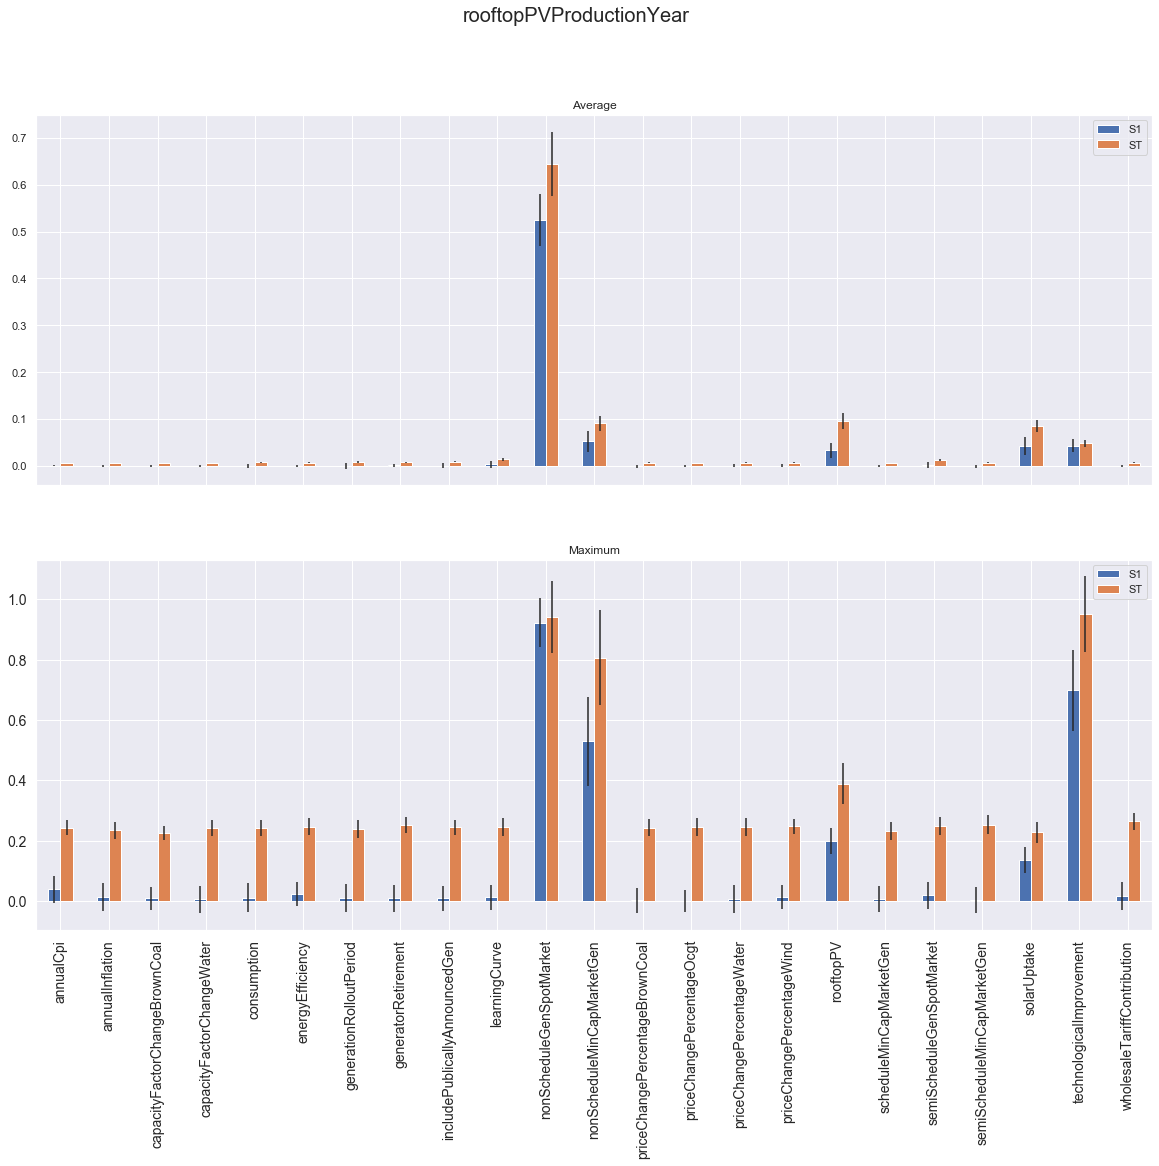

In [15]:
import seaborn as sns; sns.set()

writer = pd.ExcelWriter('{}/SOBOL_{}.xlsx'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\data', '_avg_sensitivity_Indices'), engine='xlsxwriter')

#f = plt.figure(figsize=(20,30)) 
for ooi in outcomes_to_show:
    
    fig, ax = plt.subplots(2, sharex=True)
    fig.set_size_inches(20,15)
    fig.suptitle(ooi, fontsize=20)
    
    ax[0].set_title("Average")
    ax[1].set_title("Maximum")
    
    plt.xticks (fontsize = 14)
    plt.yticks (fontsize = 14)
    
    Si_df_avg = pd.concat({'S1': s1_average_ooi[ooi],'ST': st_average_ooi[ooi],'S1_conf': s1_conf_average_ooi[ooi],'ST_conf': st_conf_average_ooi[ooi]}, axis=1)
    Si_df_max = pd.concat({'S1': s1_max_val_ooi[ooi],'ST': st_max_val_ooi[ooi],'S1_conf': s1_conf_max_val_ooi[ooi],'ST_conf': st_conf_max_val_ooi[ooi]}, axis=1)
    
    indices_avg = Si_df_avg[['S1','ST']]
    err_avg = Si_df_avg[['S1_conf','ST_conf']]
    
    indices_max = Si_df_max[['S1','ST']]
    err_max = Si_df_max[['S1_conf','ST_conf']]


    Si_df_avg.to_excel(writer, sheet_name=ooi)

    
    indices_avg.plot.bar(yerr=err_avg.values.T,ax=ax[0])
    indices_max.plot.bar(yerr=err_max.values.T,ax=ax[1])
       

    print(ooi)

    plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_barplot_s1_st_%s'%(ooi)),dpi=300, bbox_inches='tight')
    #break

writer.save()

### S2, S1, and ST plots

GHGYear
wholesalePriceYear
tariffsYear
primarySpotProductionYear
secondarySpotProductionYear
offSpotProductionYear
rooftopPVProductionYear


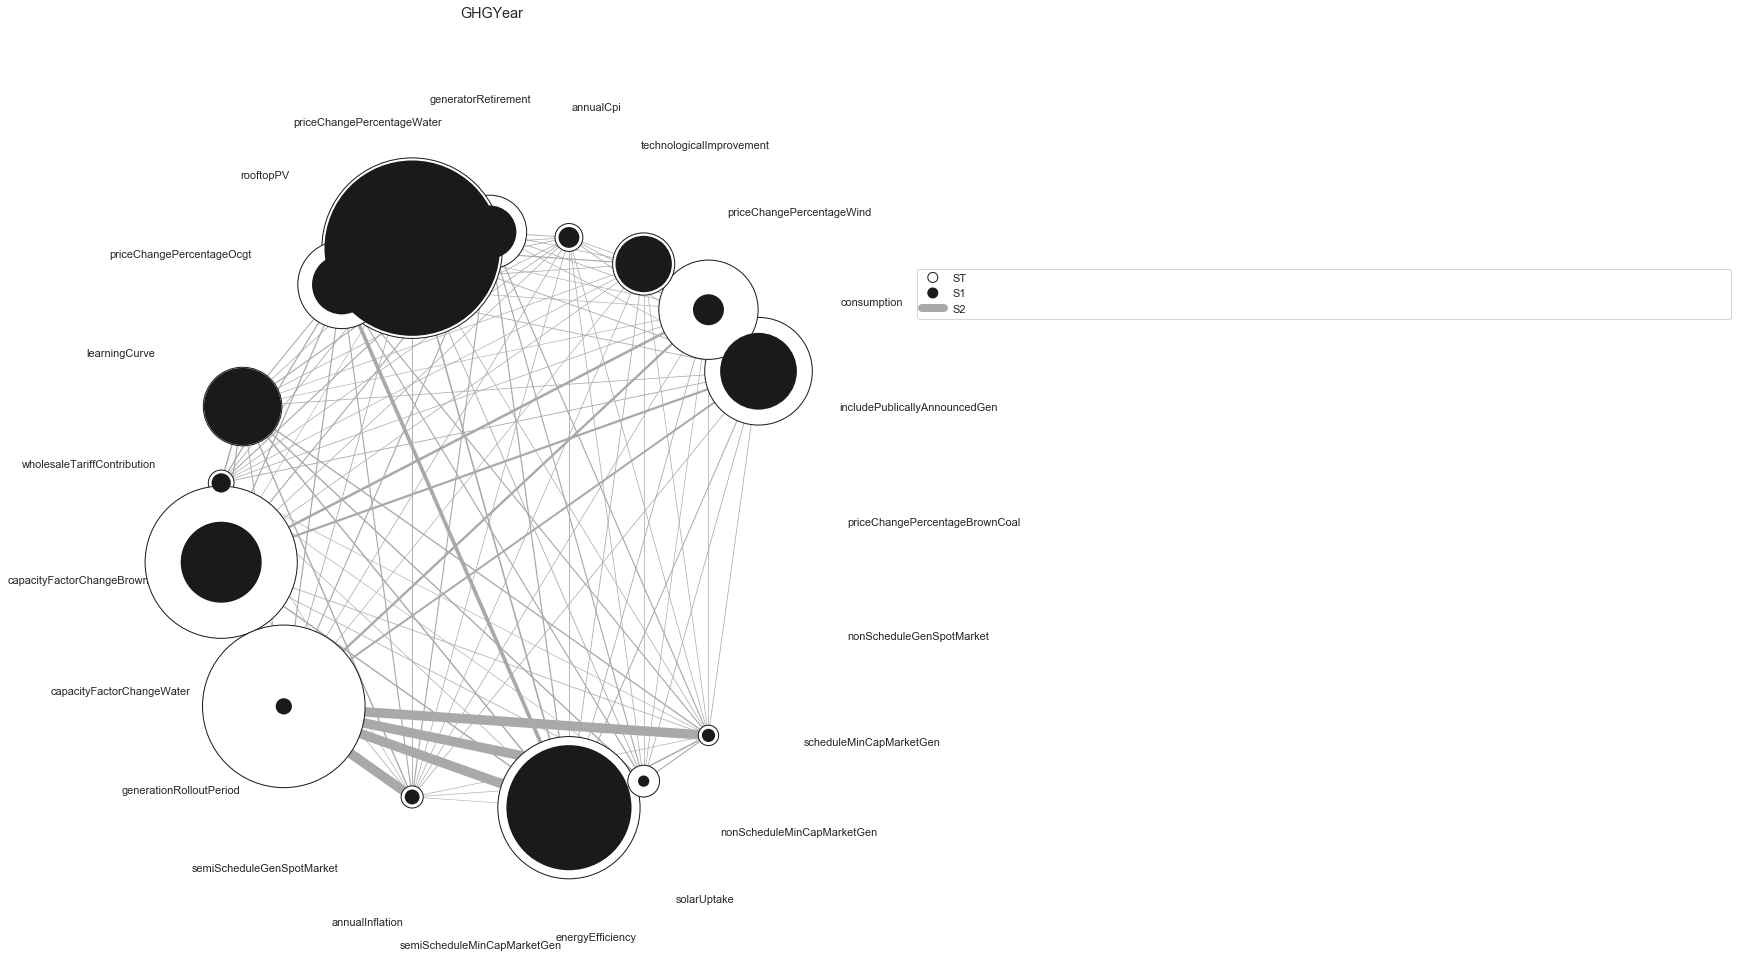

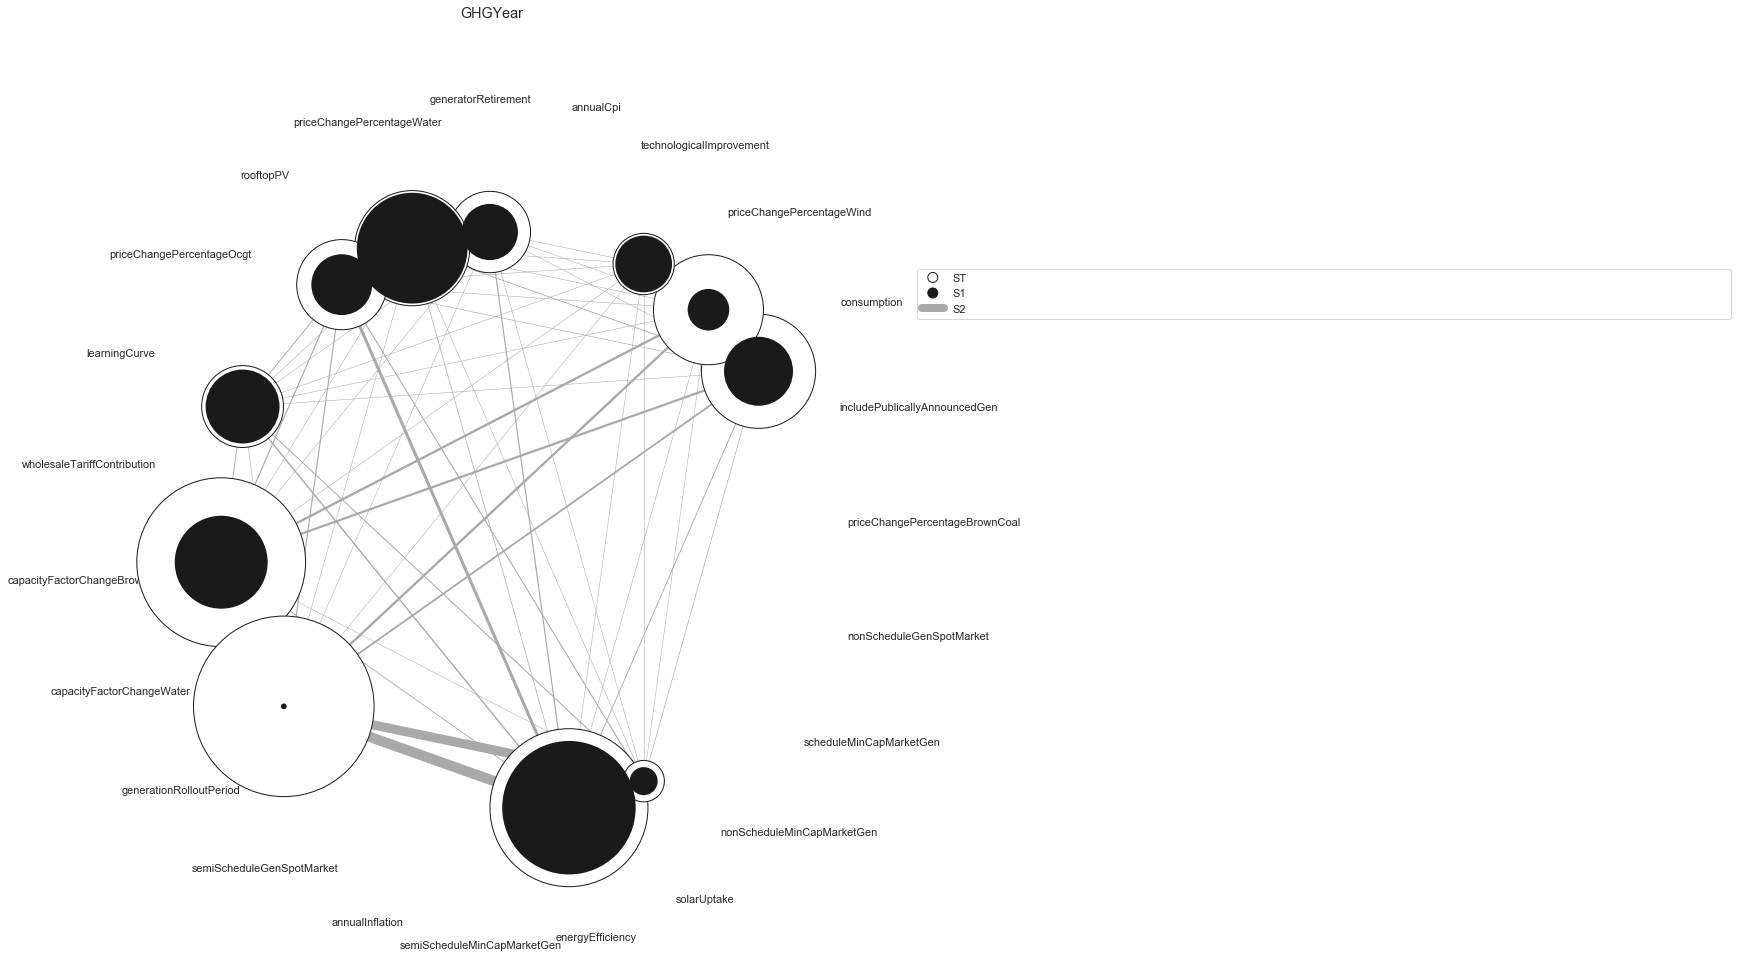

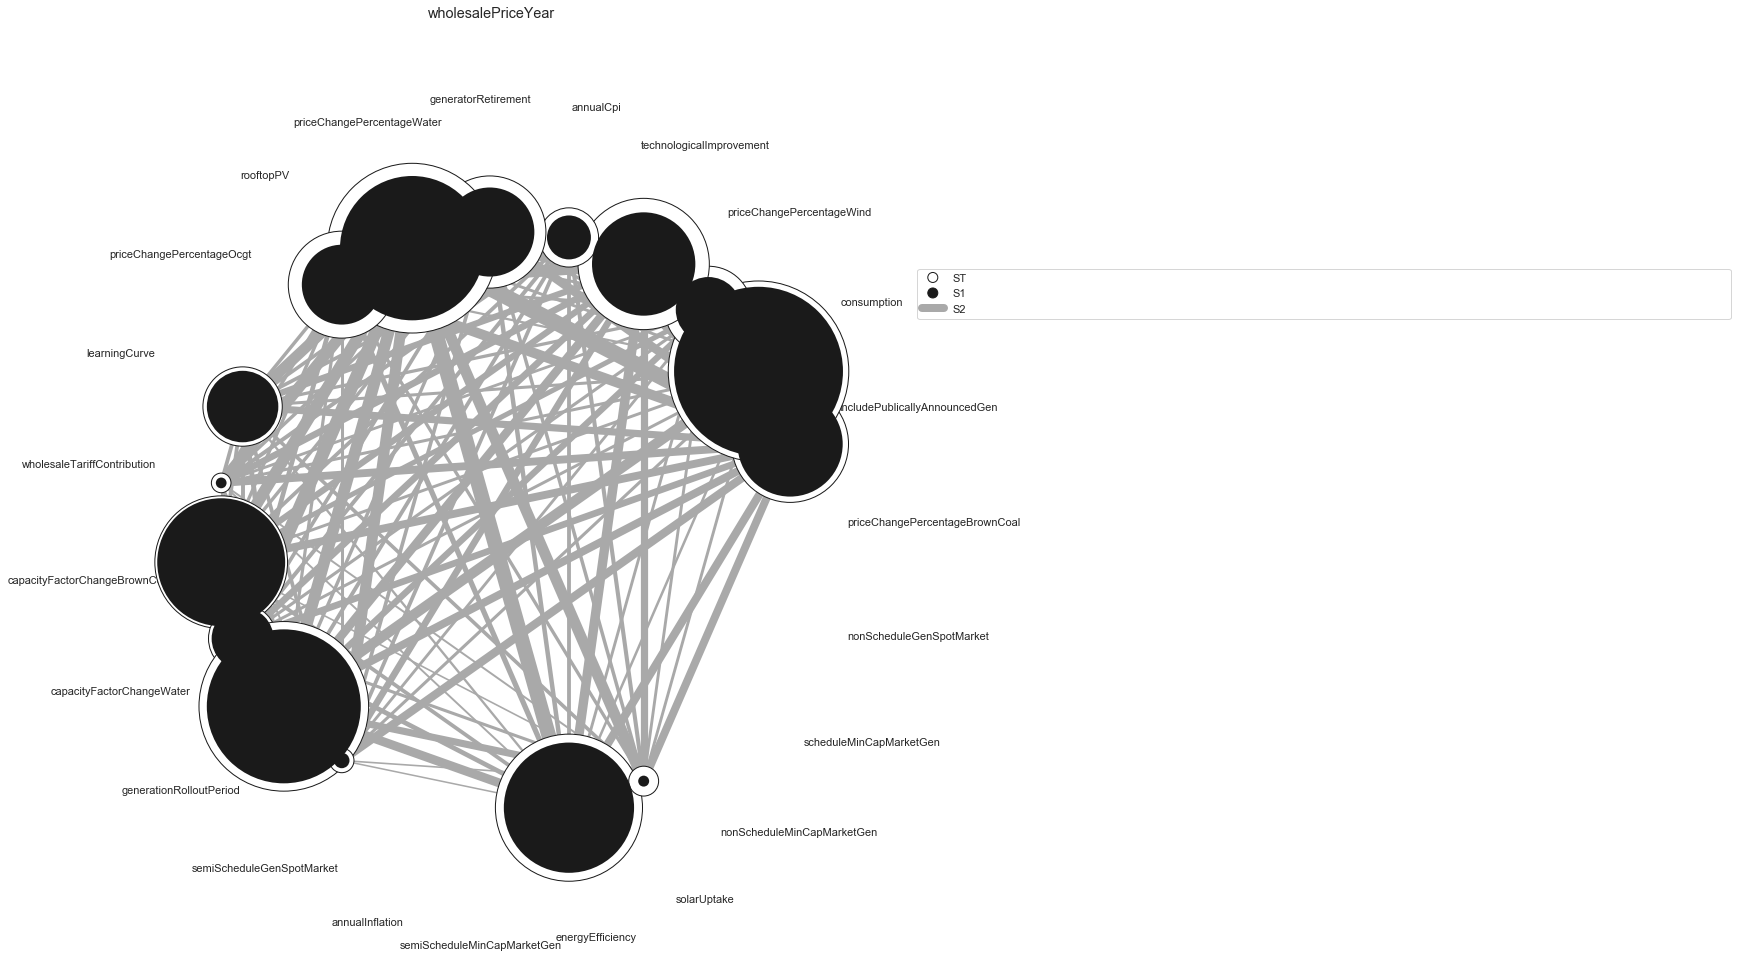

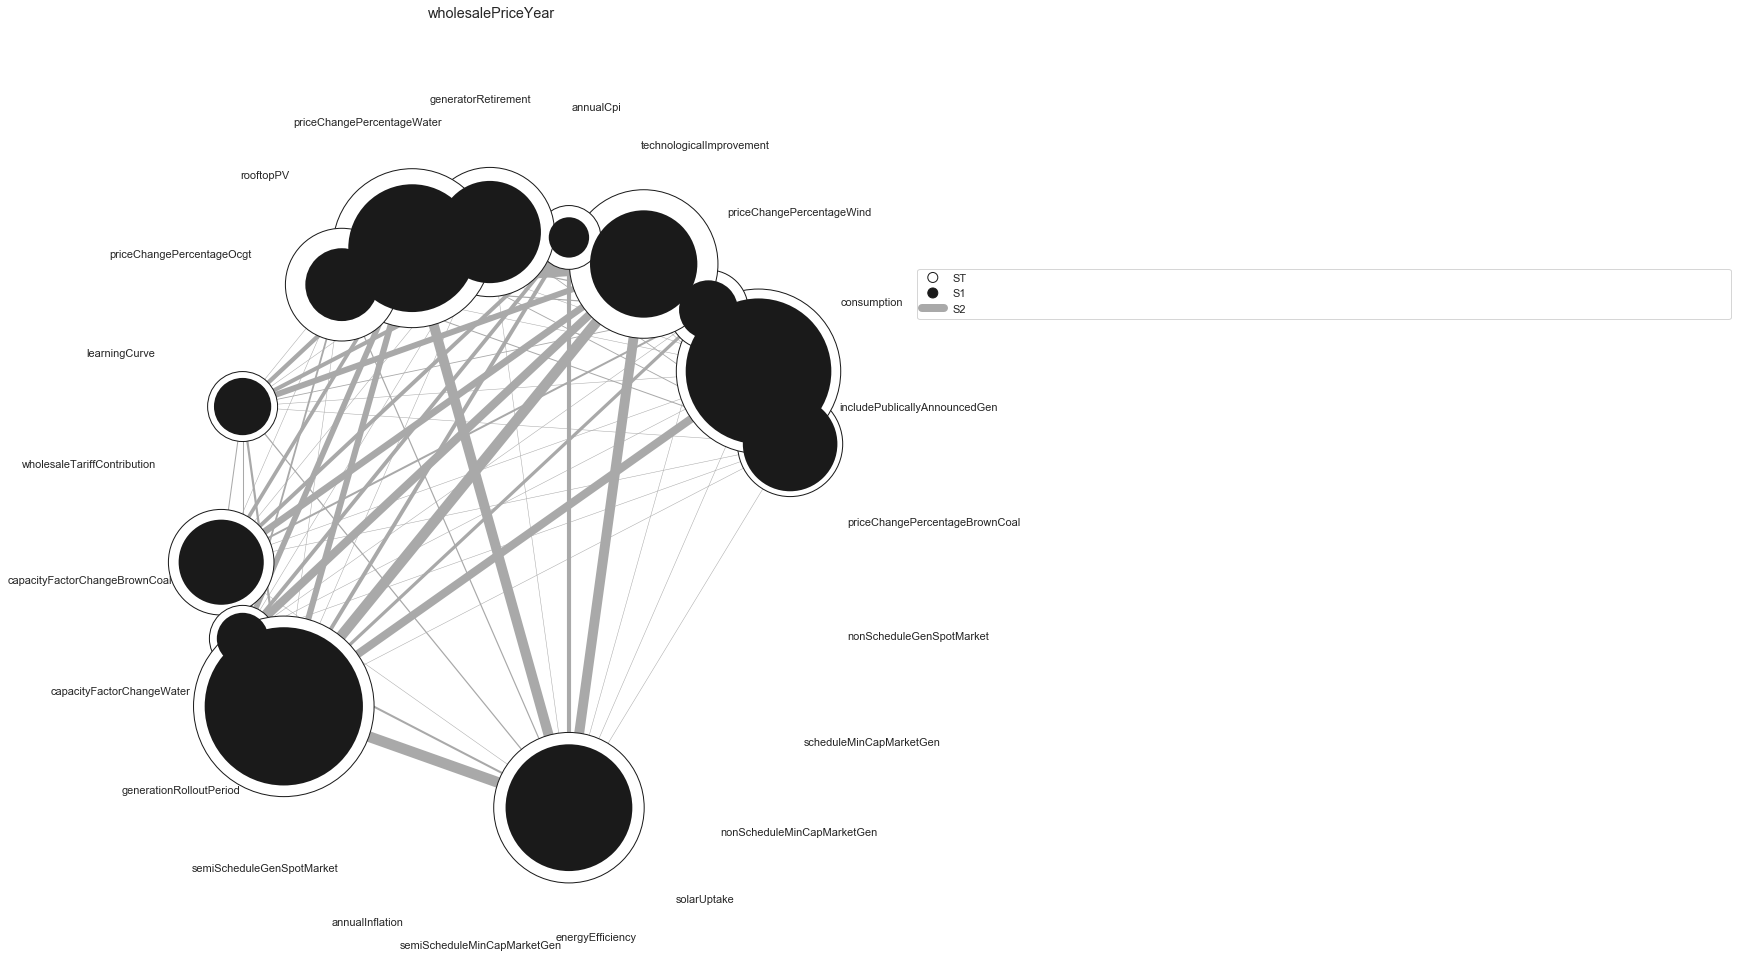

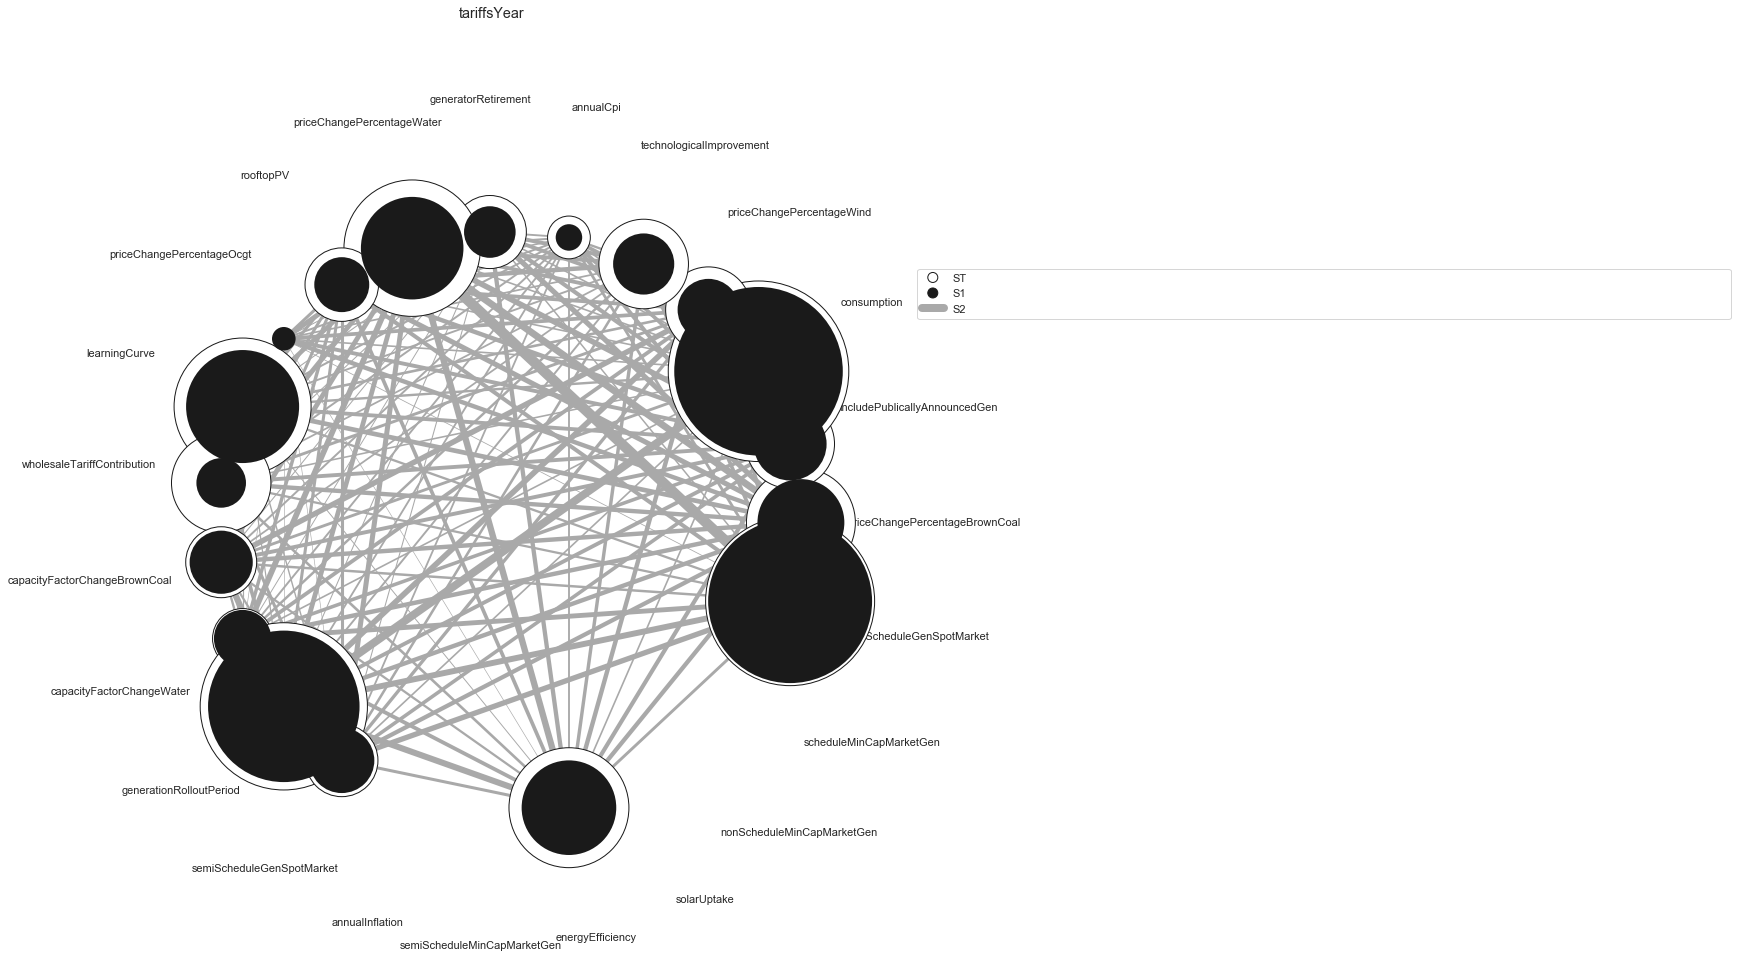

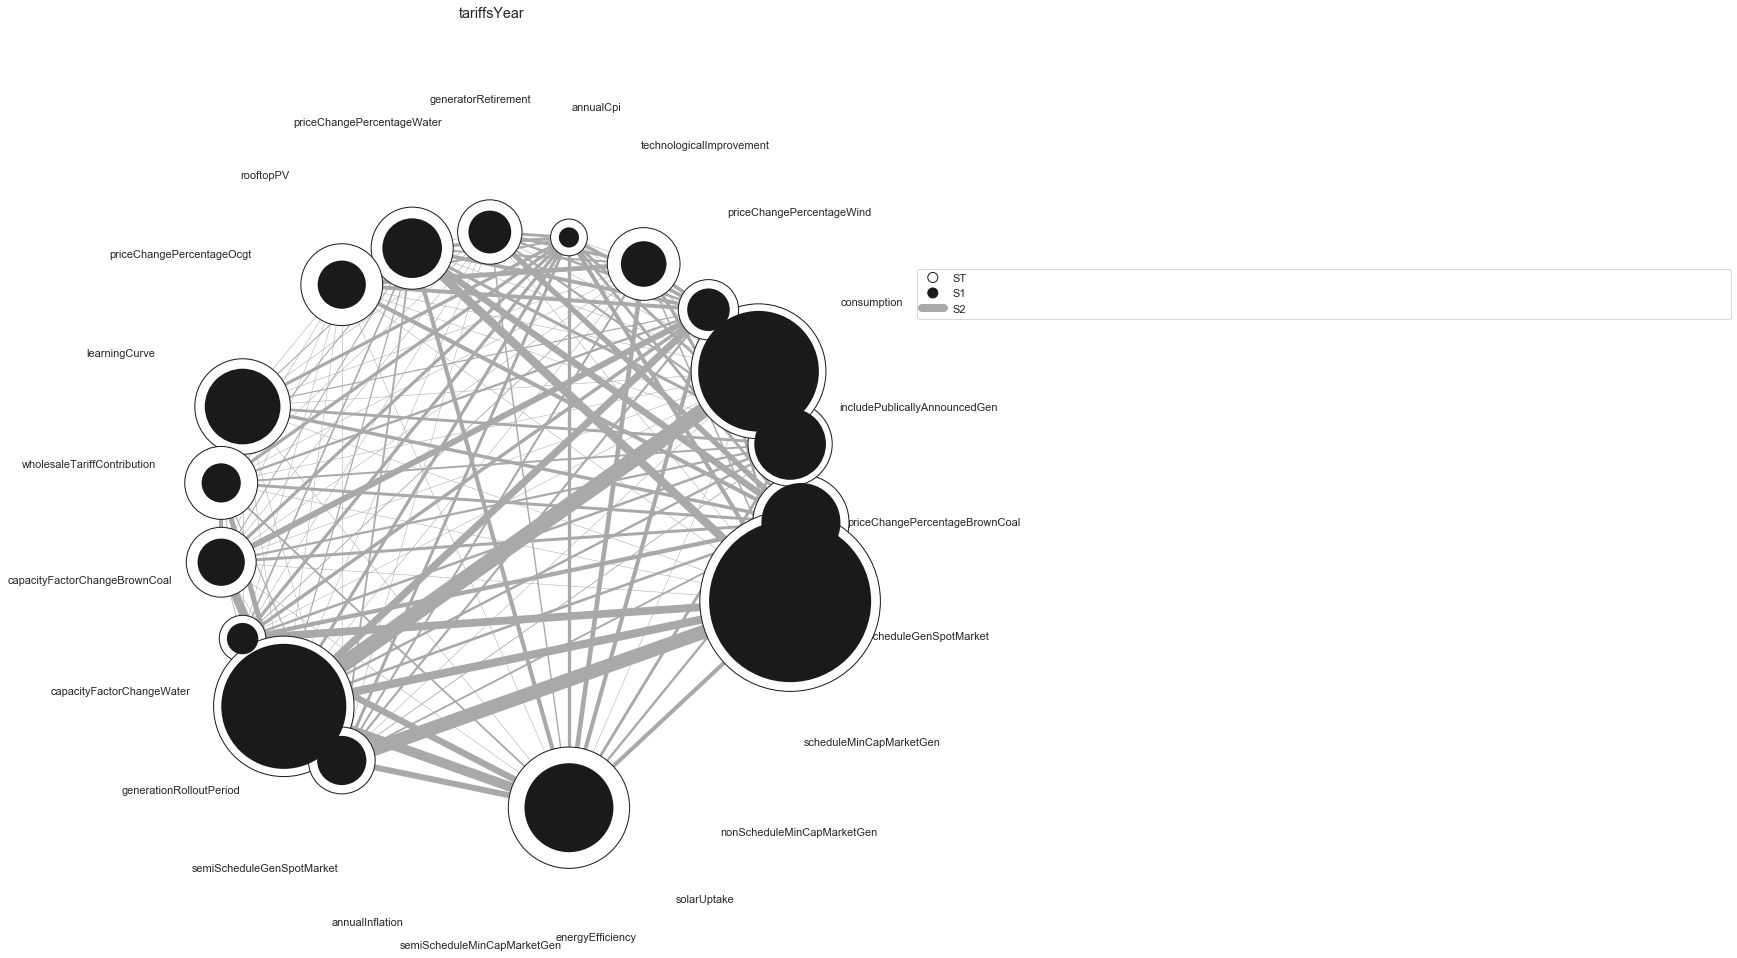

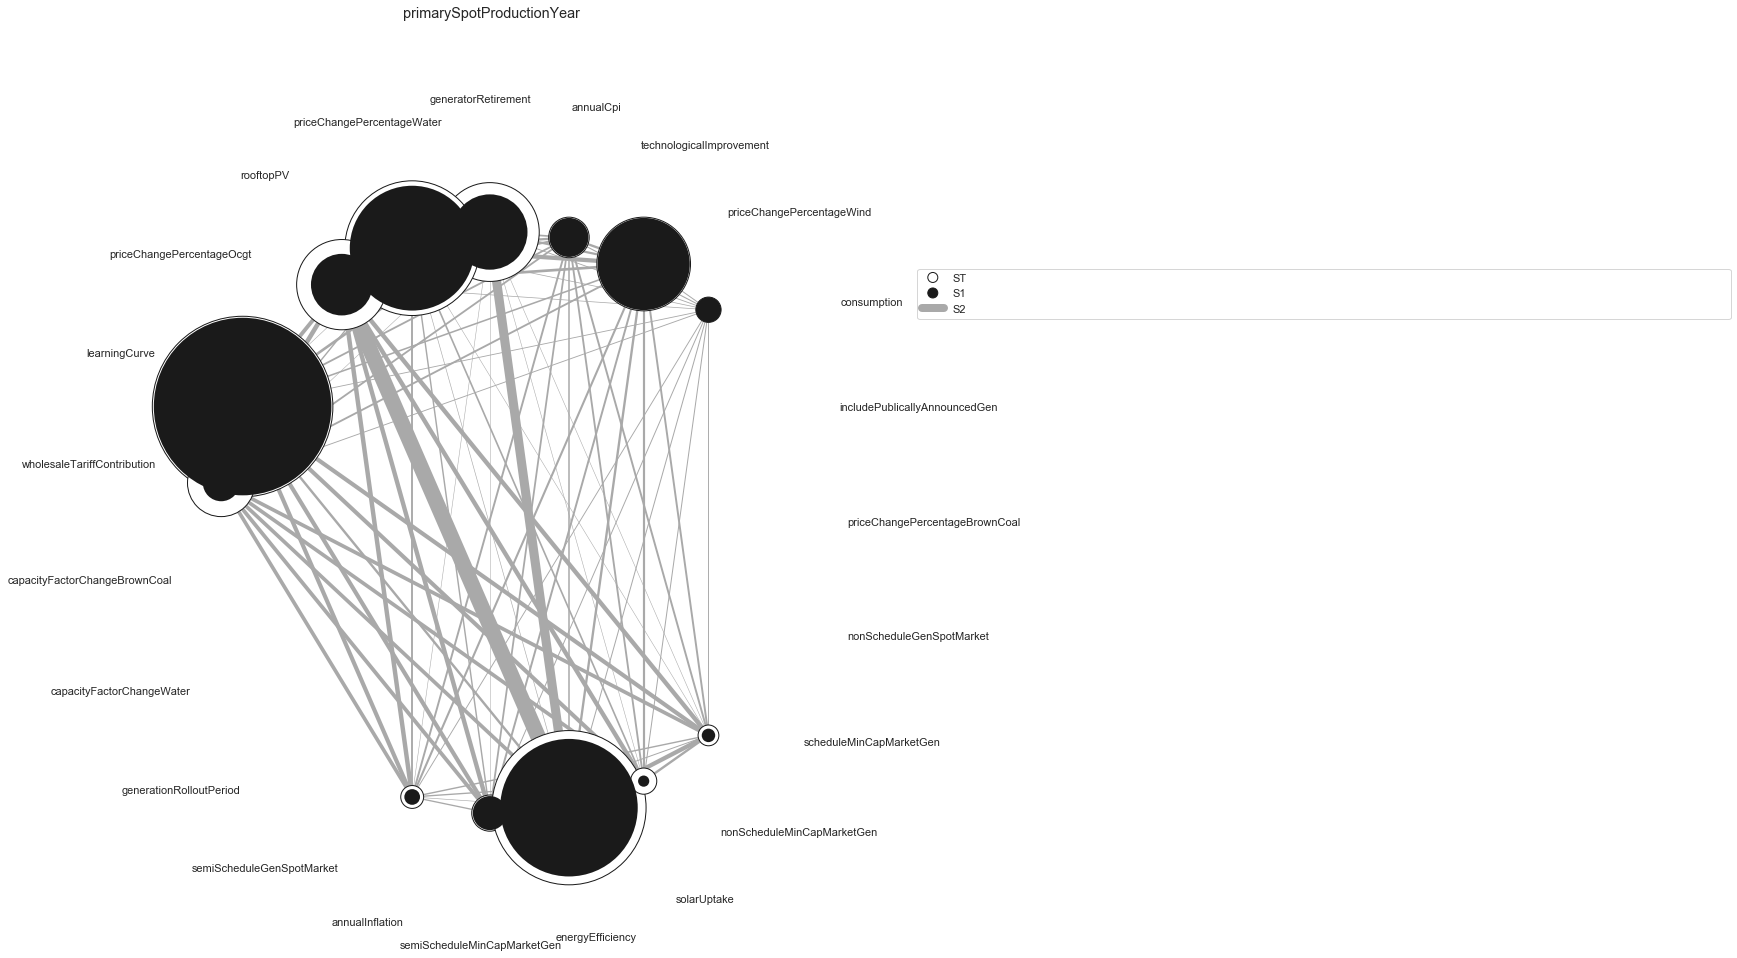

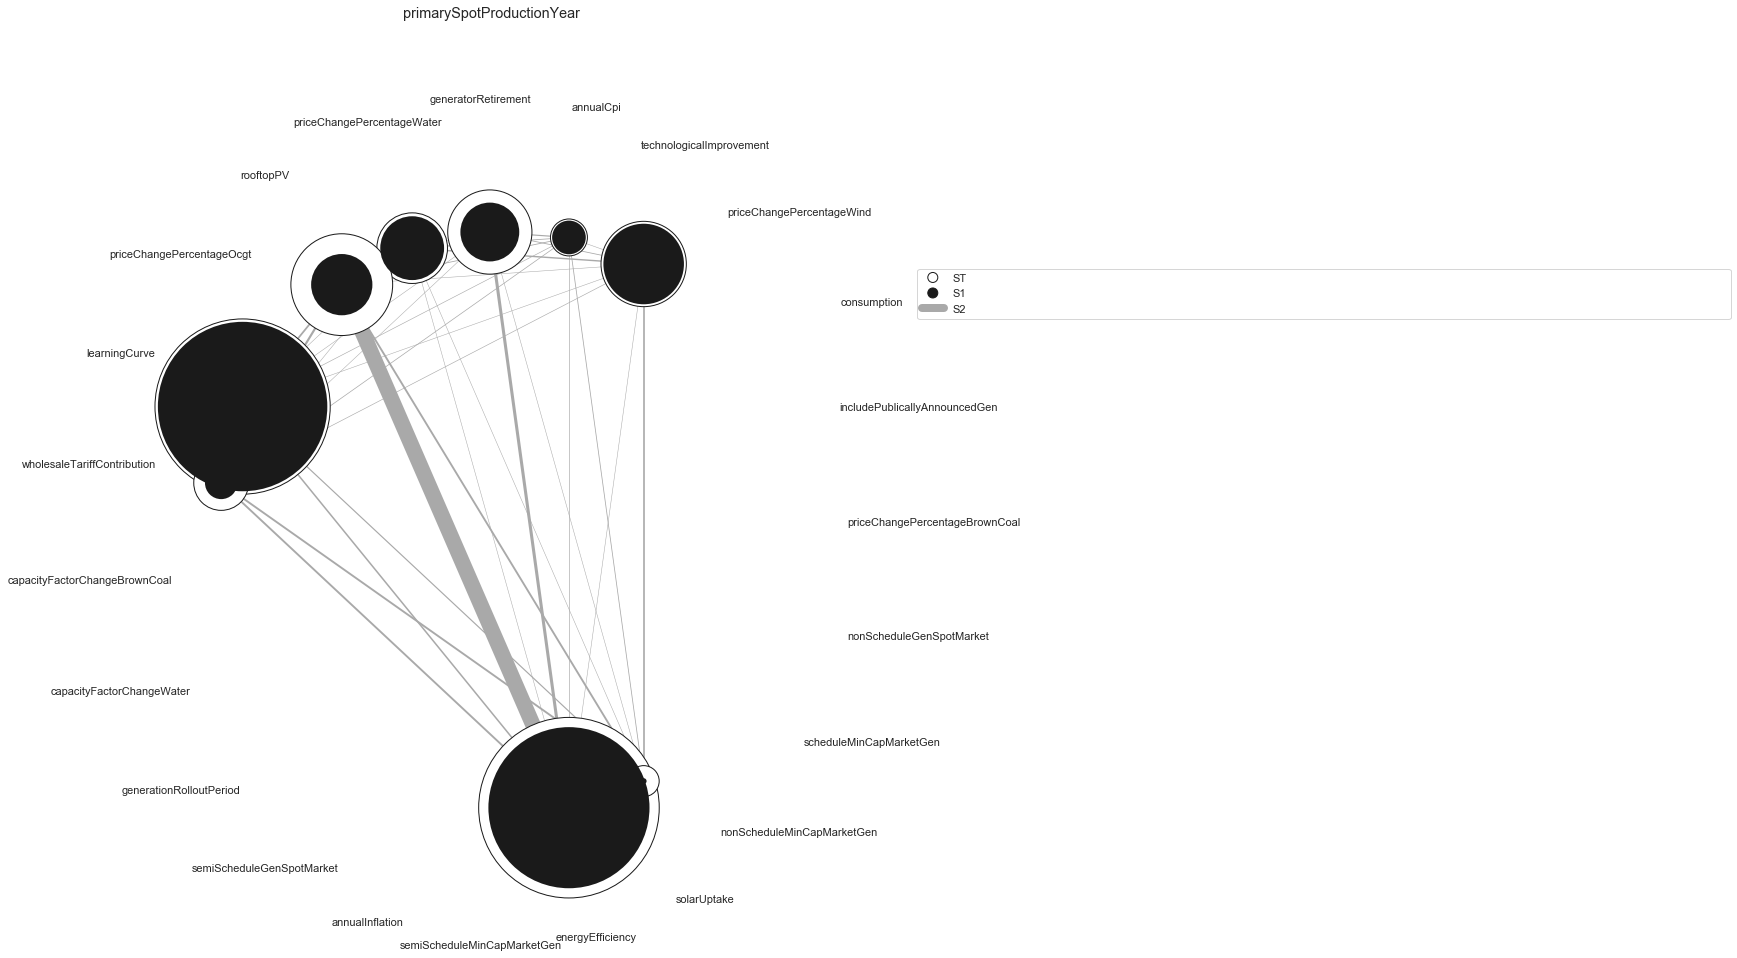

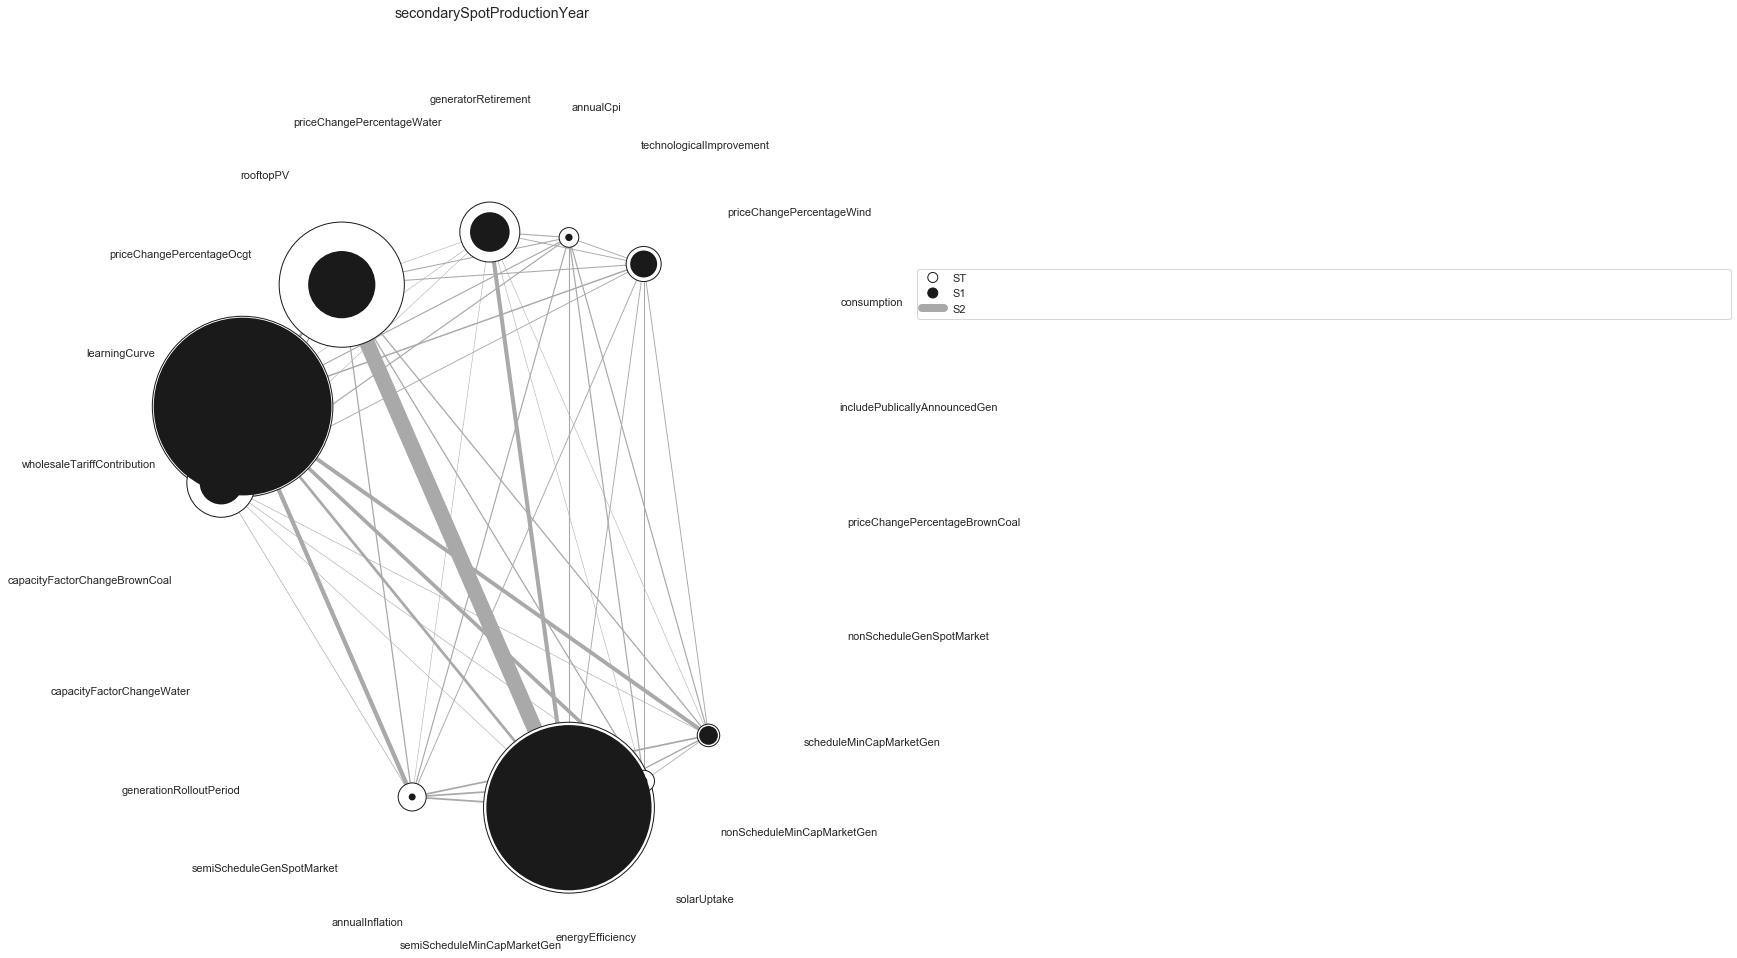

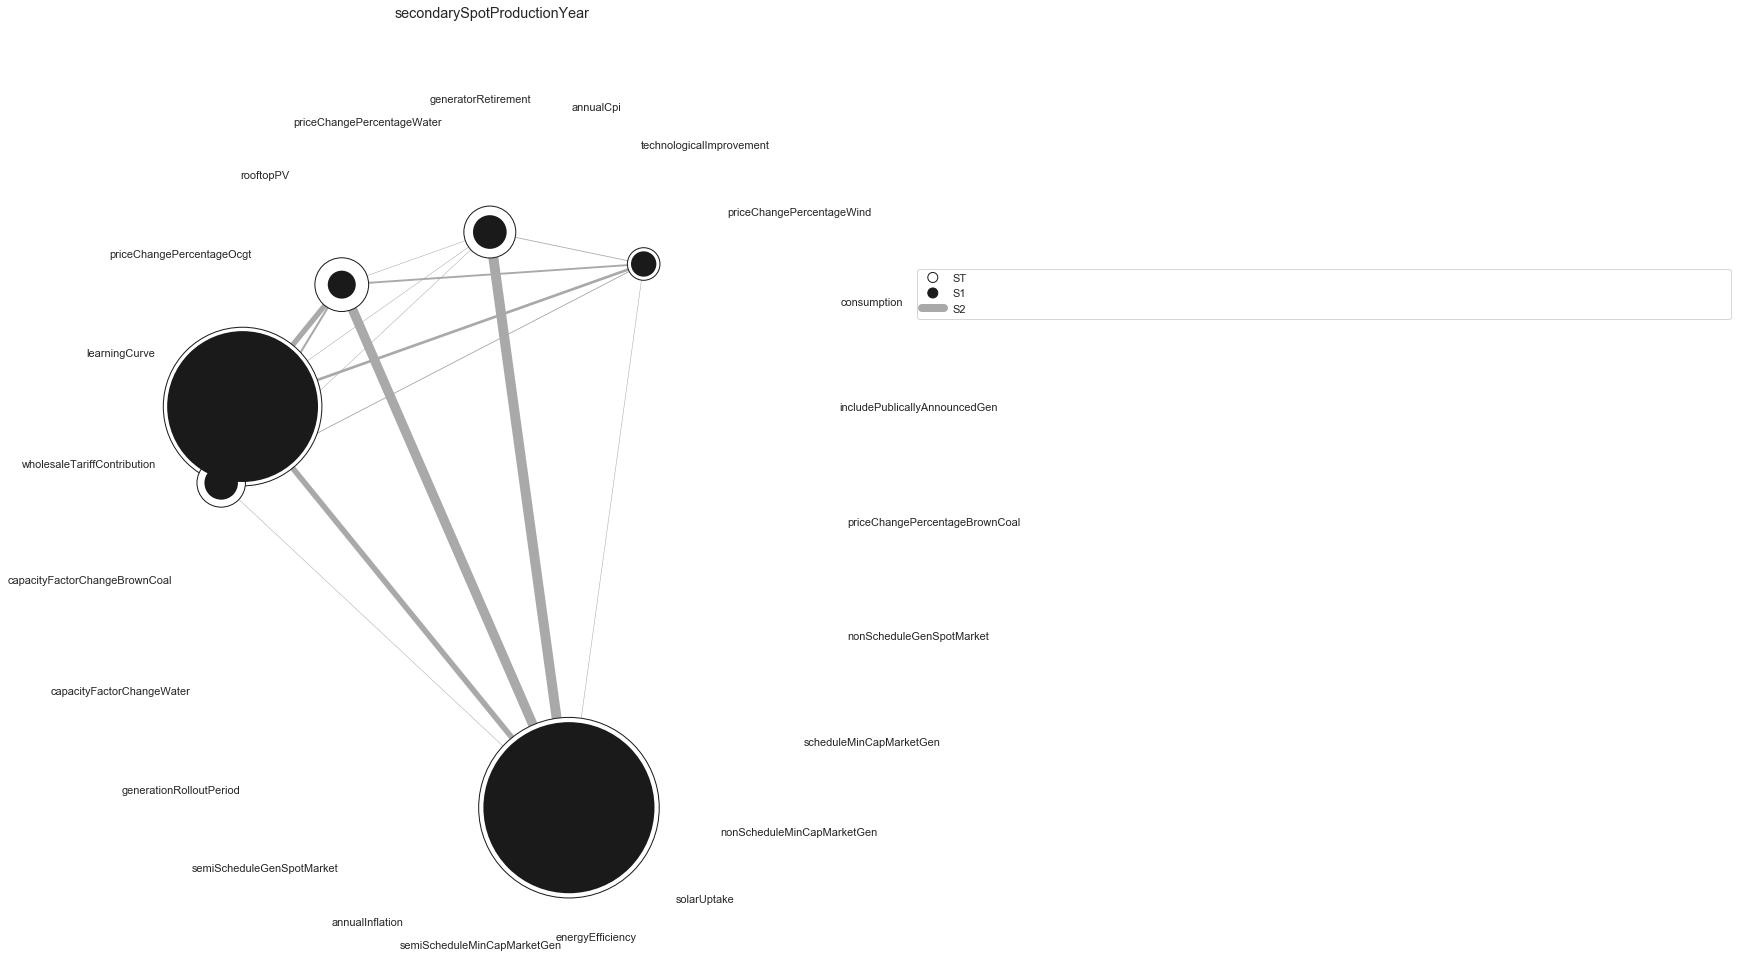

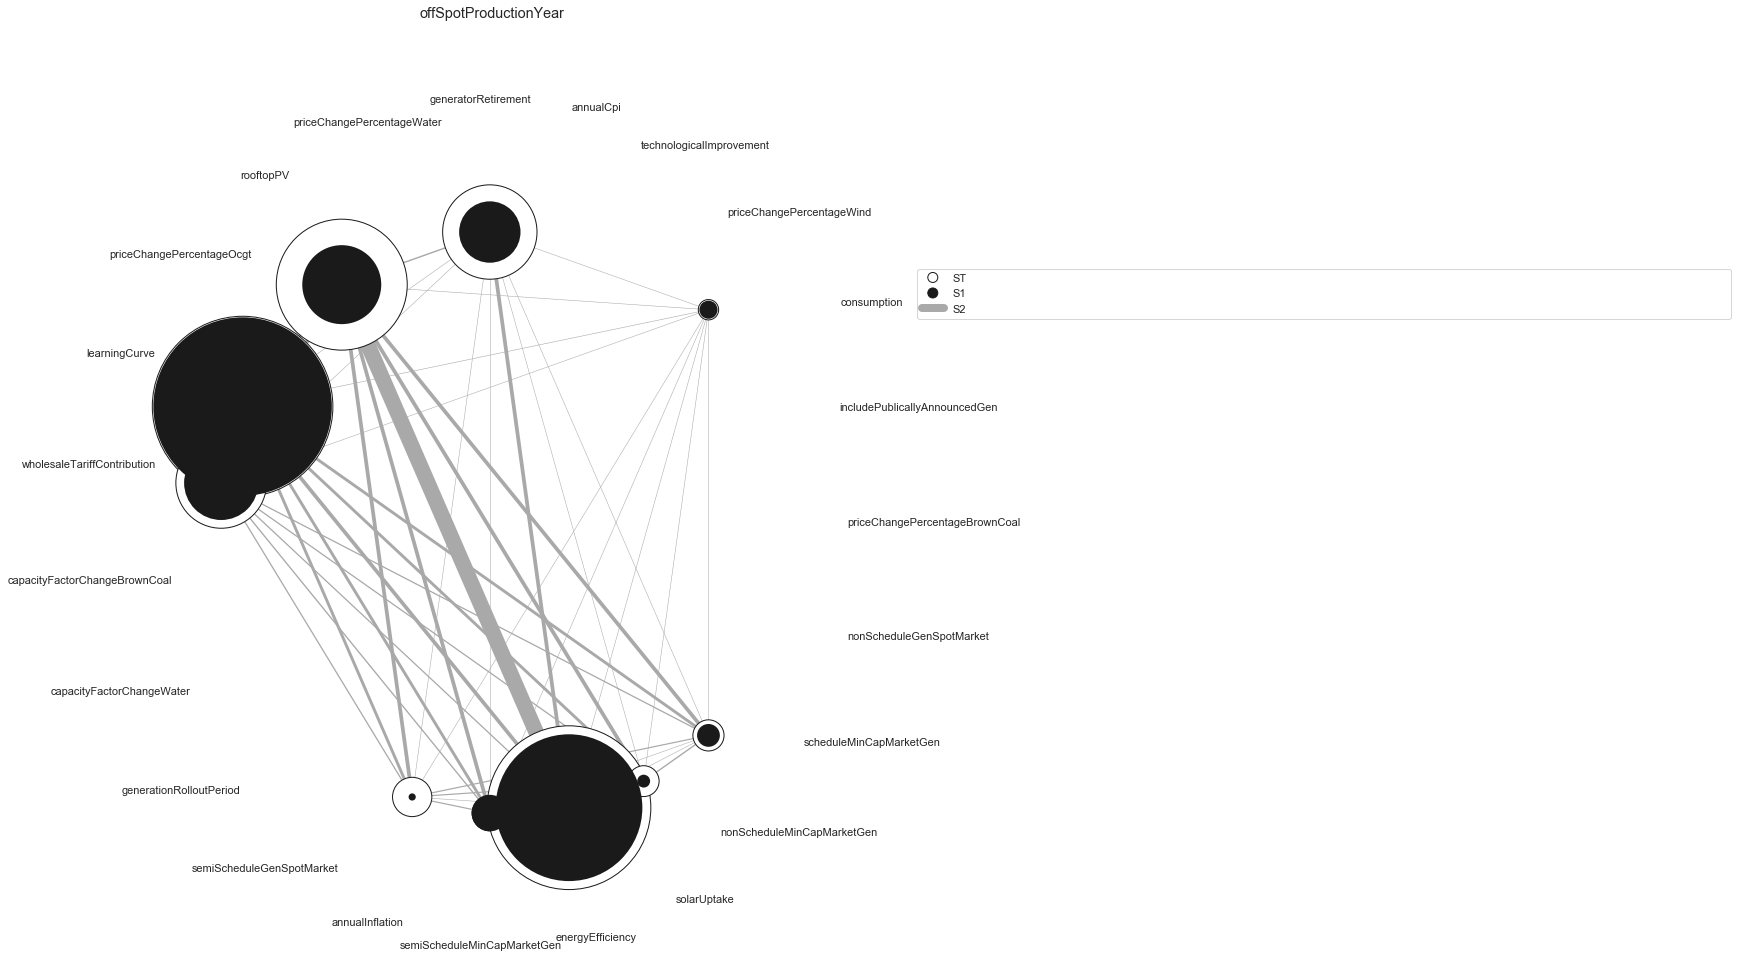

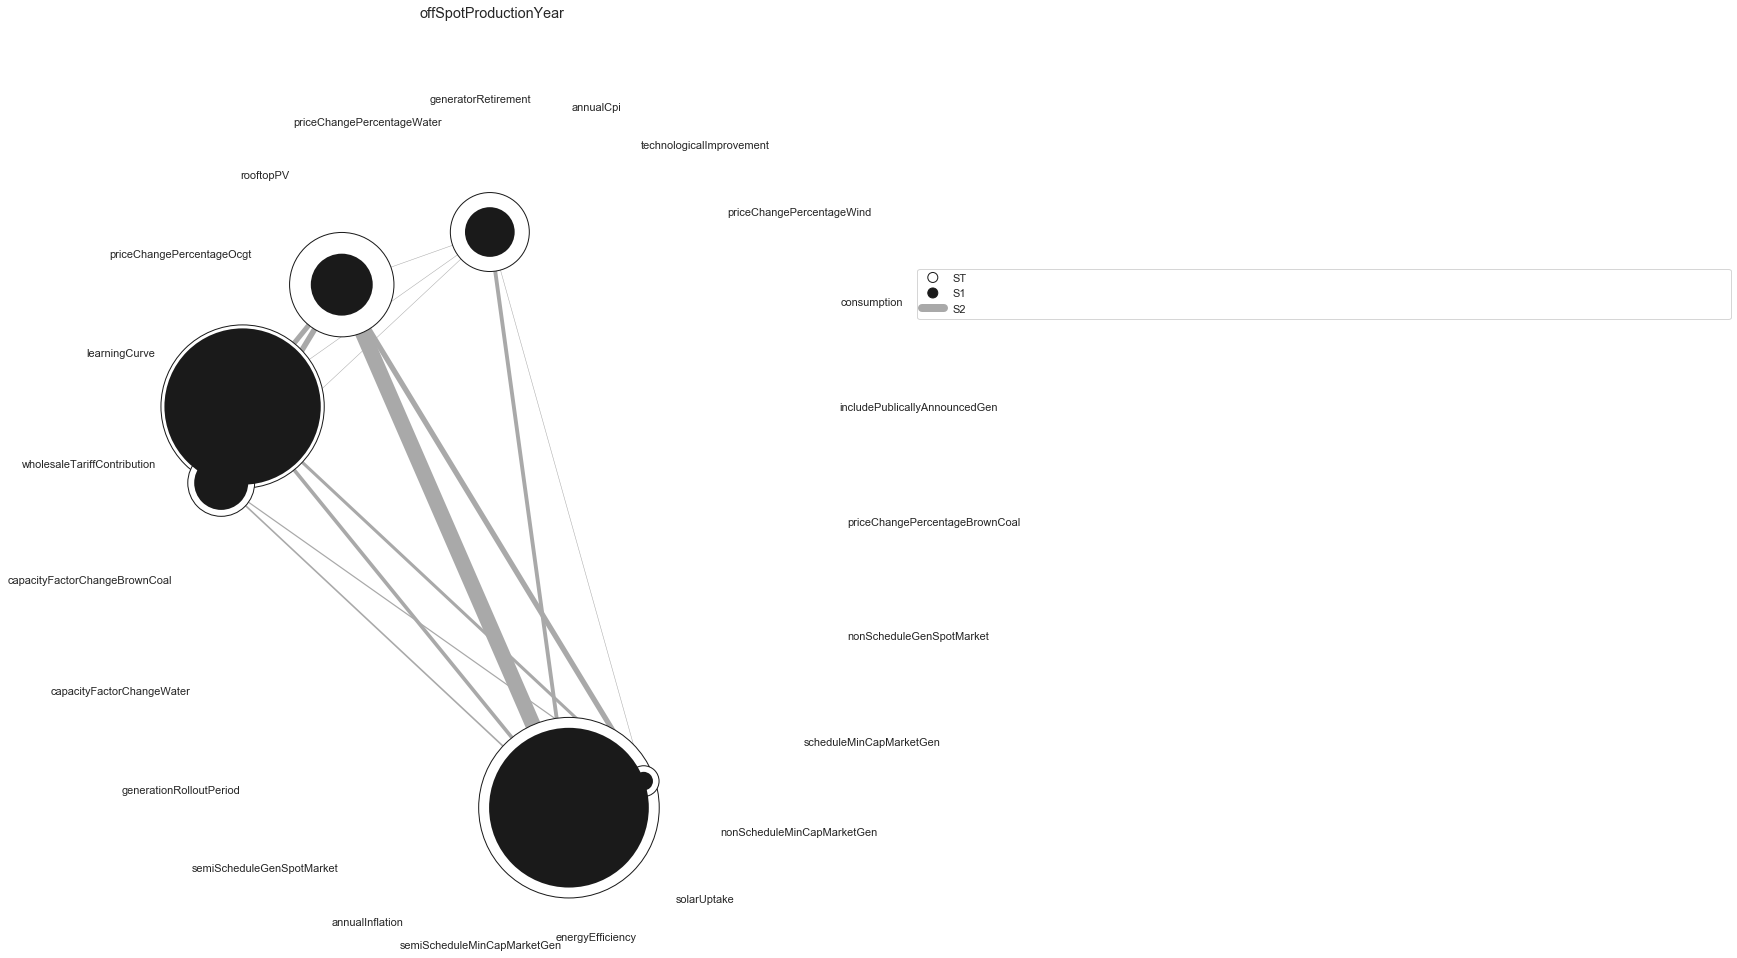

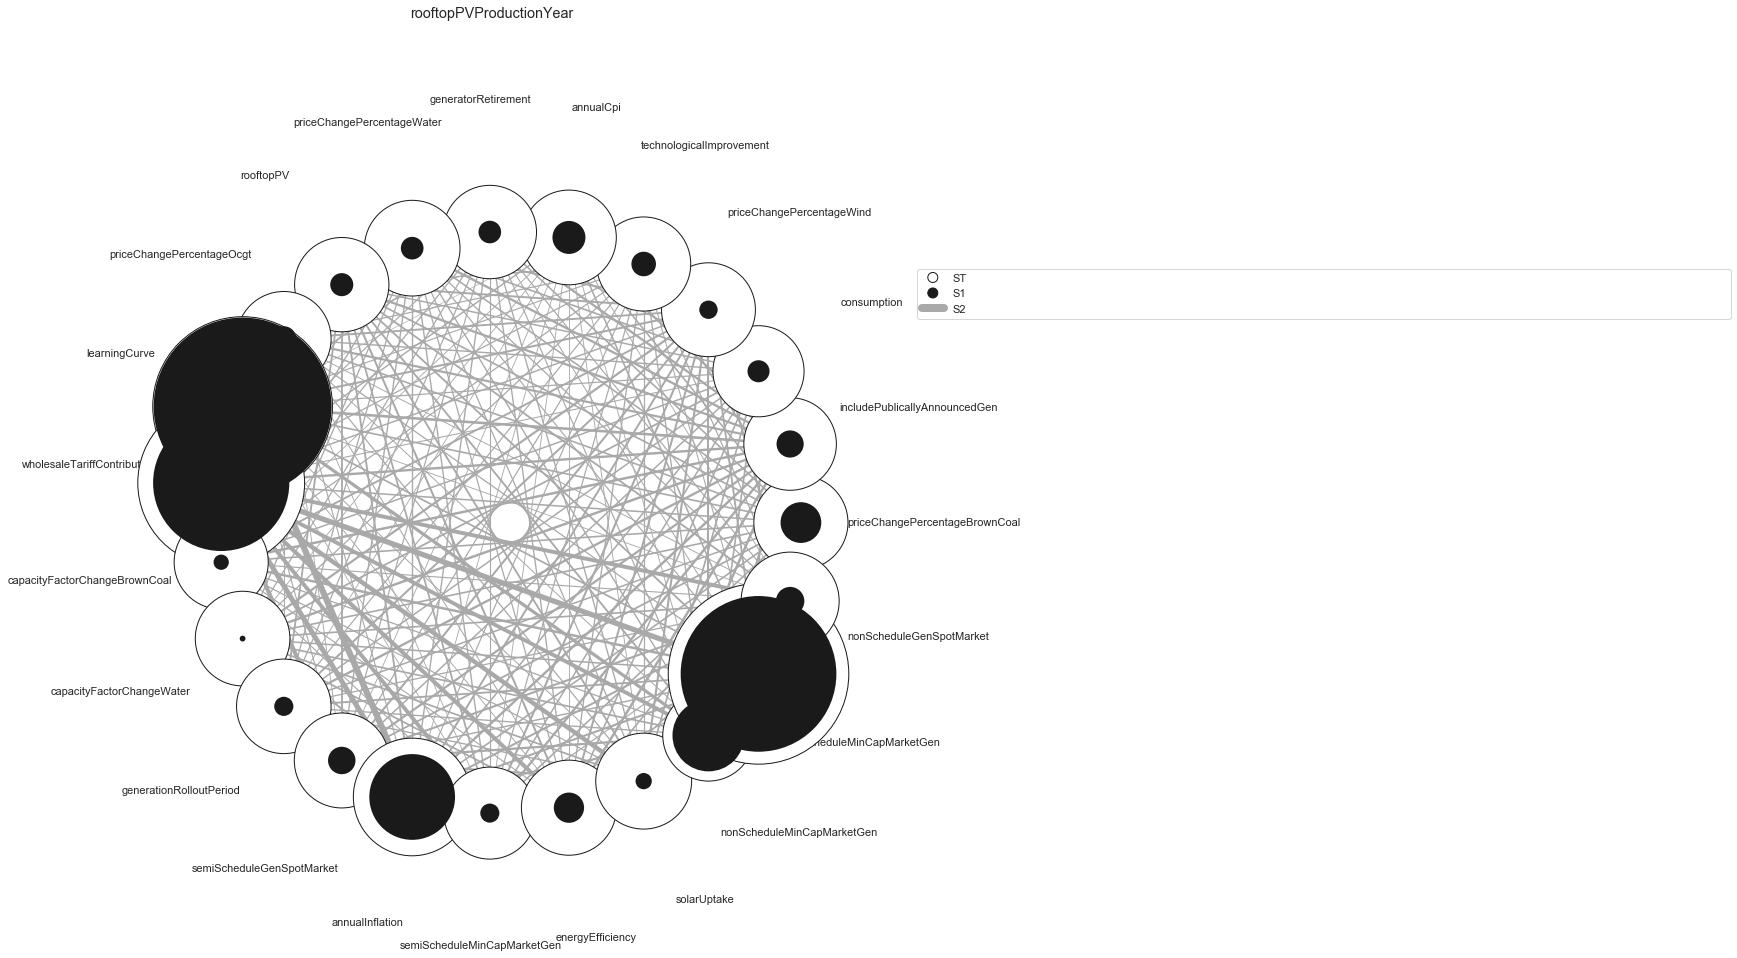

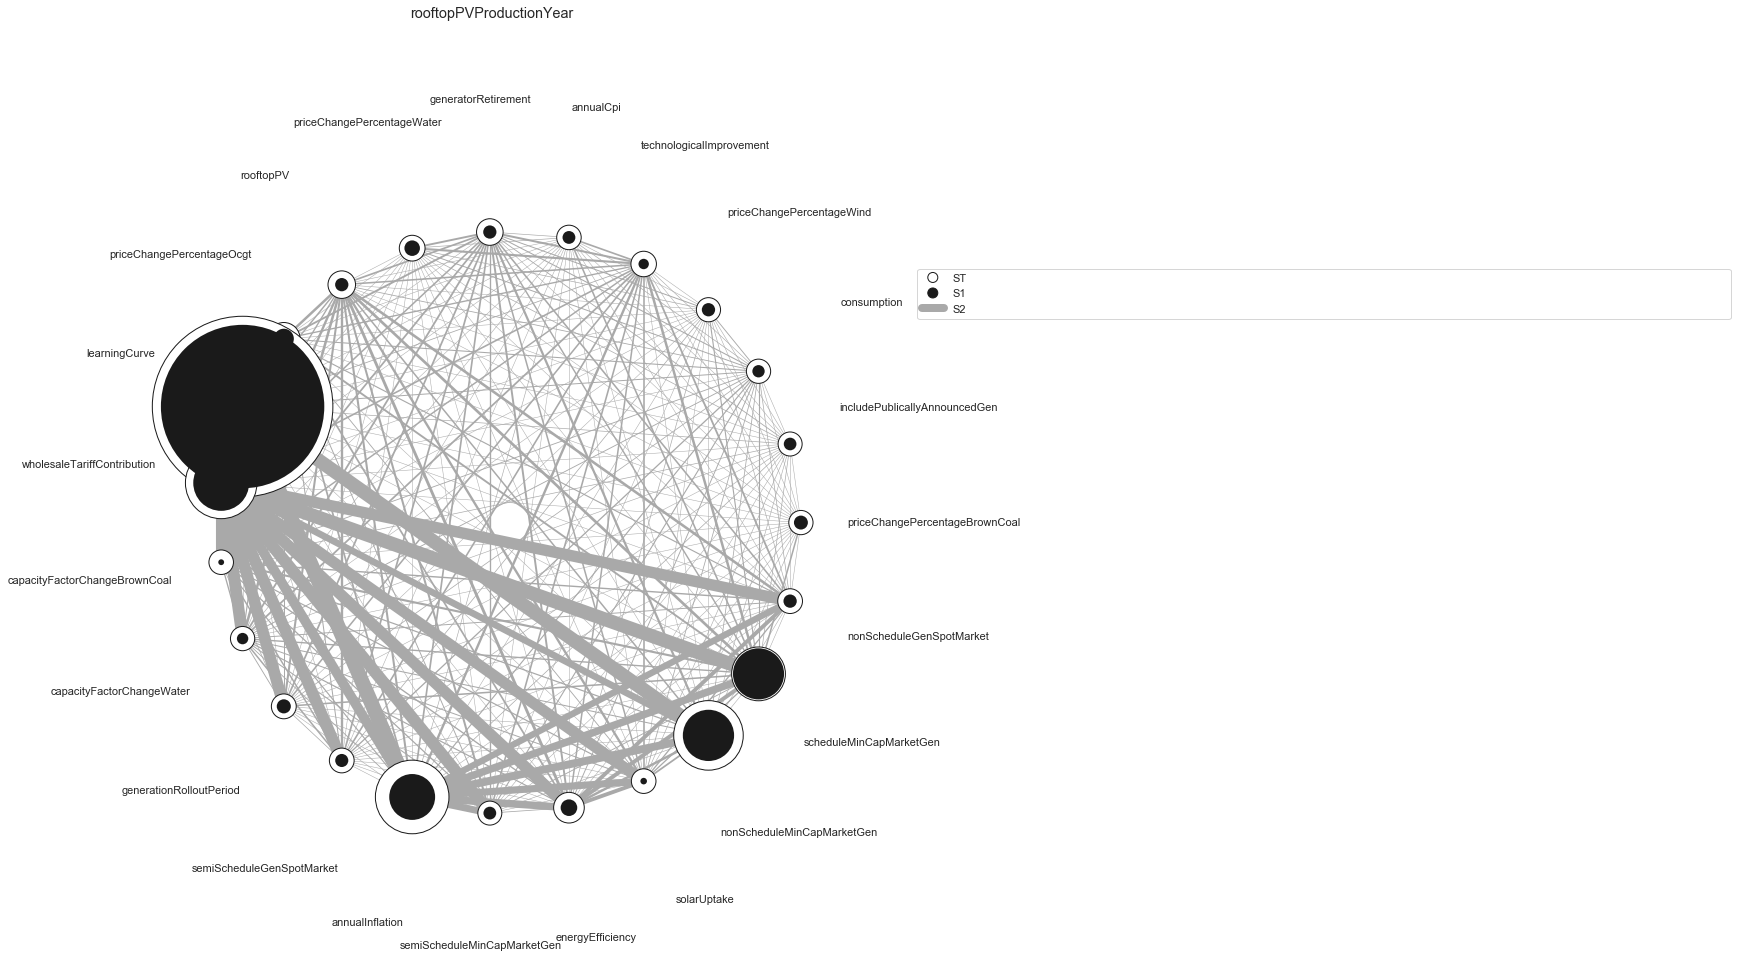

In [35]:
#%matplotlib inline
sns.set_style('whitegrid')

for ooi in outcomes_to_show:
    
    #Maximum
    Si_df_max = {'S1': s1_max_val_ooi[ooi].to_numpy(),'S2': s2_max_val_ooi[ooi].to_numpy(),'ST': st_max_val_ooi[ooi].to_numpy(),'S1_conf': s1_conf_max_val_ooi[ooi].to_numpy(),'S2_conf': s2_conf_max_val_ooi[ooi].to_numpy(),'ST_conf': st_conf_max_val_ooi[ooi].to_numpy()}
    
    fig = plot_sobol_indices(Si_df_max, uncertainties, criterion='ST', threshold=0.005)
    fig.set_size_inches(20,15)
    fig.suptitle(ooi)   

    plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_sobol_max_%s'%(ooi)),dpi=300, bbox_inches='tight')
    
    #Average
    Si_df_avg = {'S1': s1_average_ooi[ooi].to_numpy(),'S2': s2_average_ooi[ooi].to_numpy(),'ST': st_average_ooi[ooi].to_numpy(),'S1_conf': s1_conf_average_ooi[ooi].to_numpy(),'S2_conf': s2_conf_average_ooi[ooi].to_numpy(),'ST_conf': st_conf_average_ooi[ooi].to_numpy()}
    
    fig = plot_sobol_indices(Si_df_avg, uncertainties, criterion='ST', threshold=0.005)
    fig.set_size_inches(20,15)
    fig.suptitle(ooi)   

    plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_sobol_avg_%s'%(ooi)),dpi=300, bbox_inches='tight')
    
    print(ooi)
     

## Boxplot

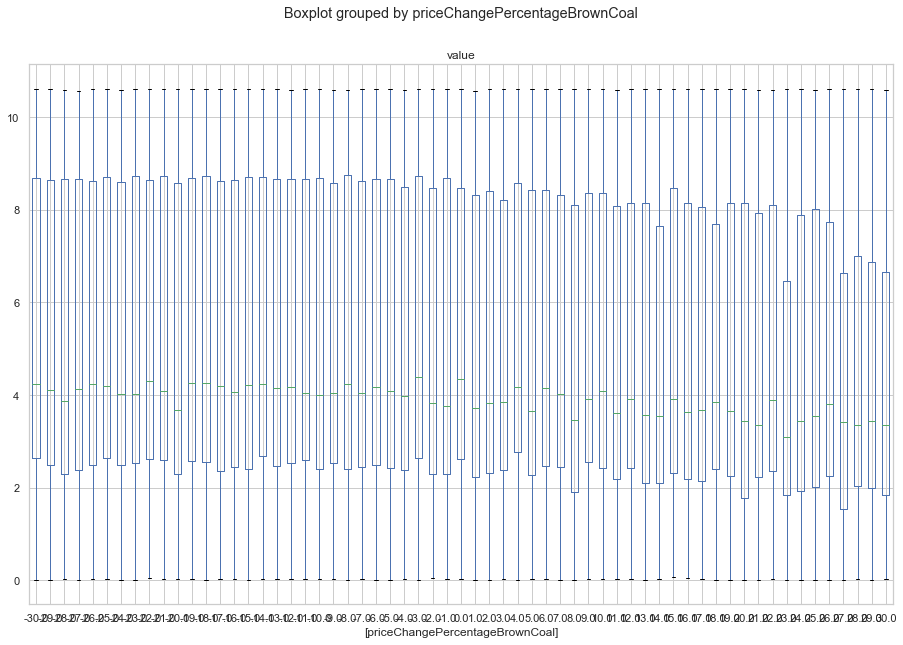

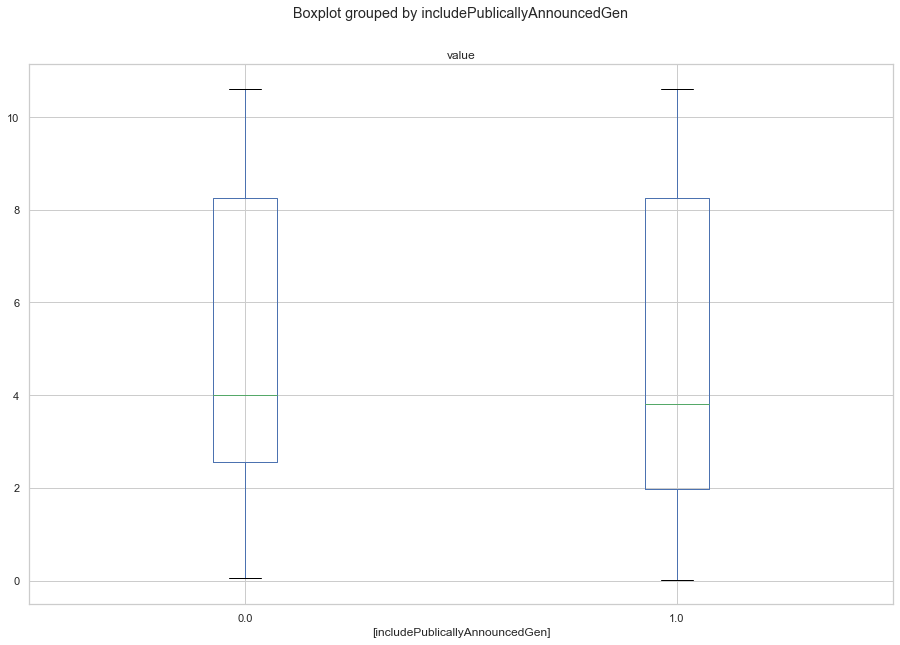

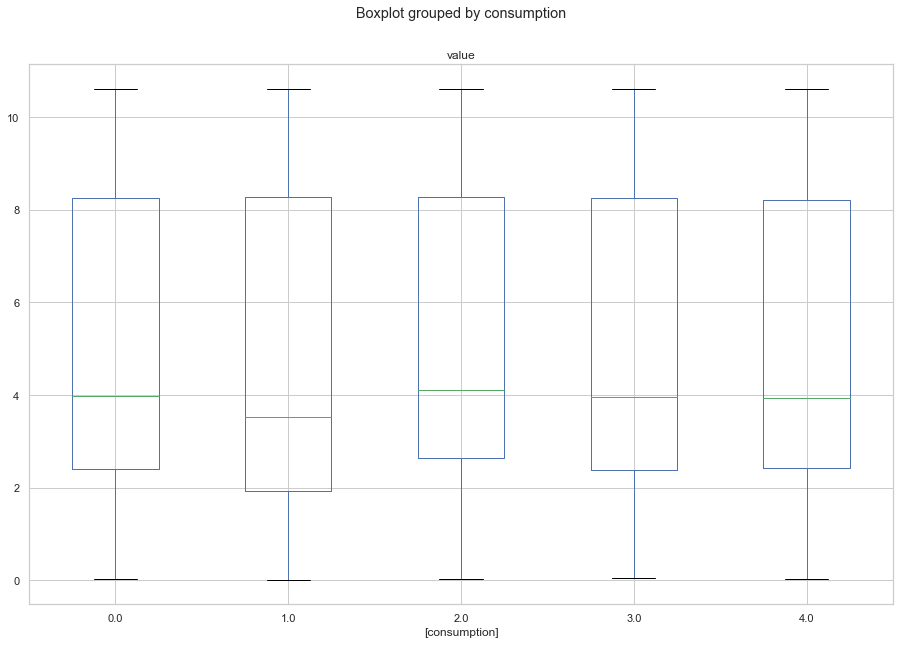

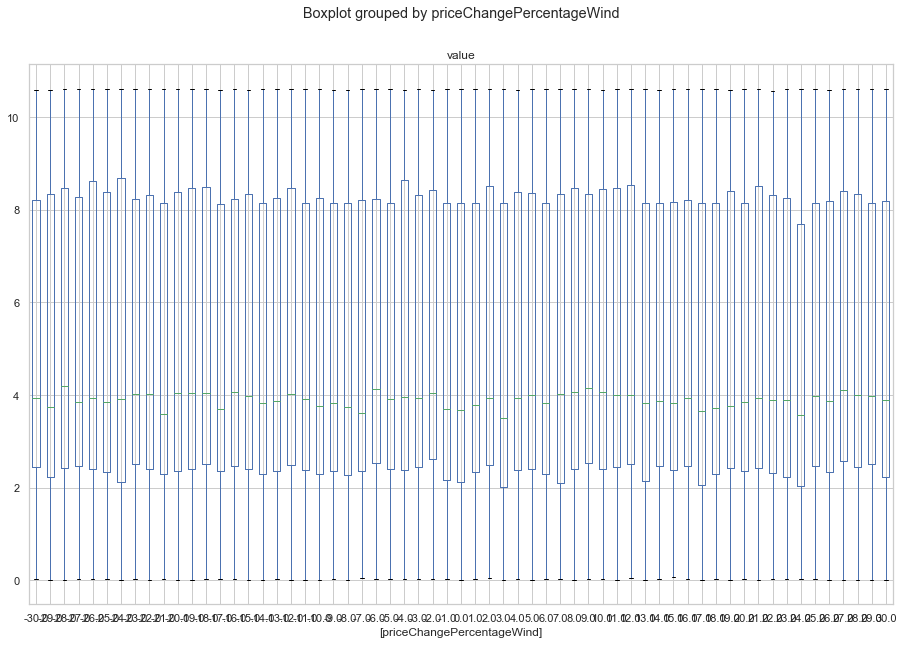

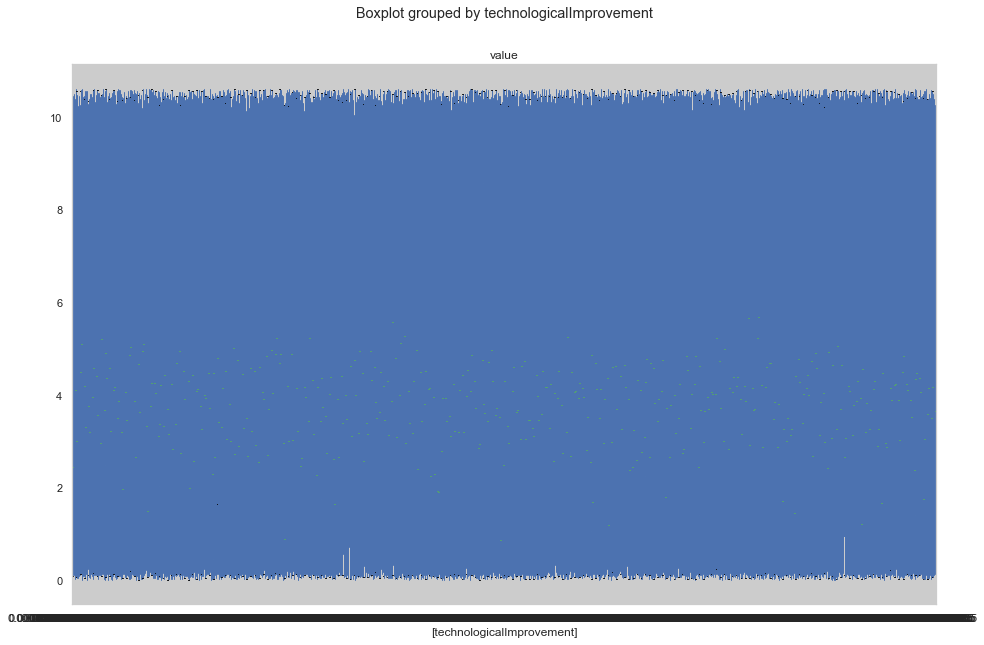

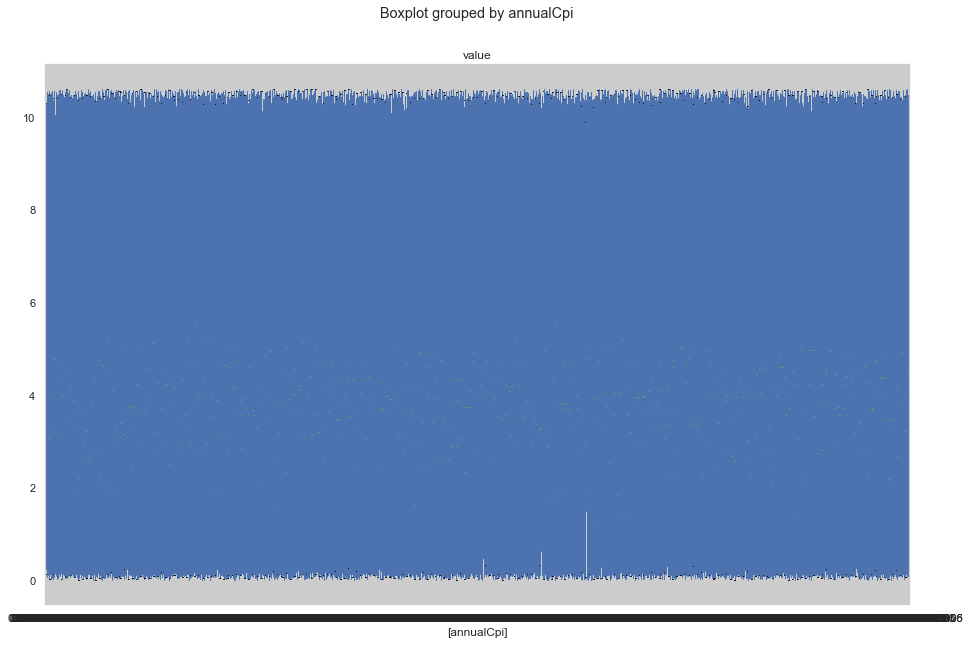

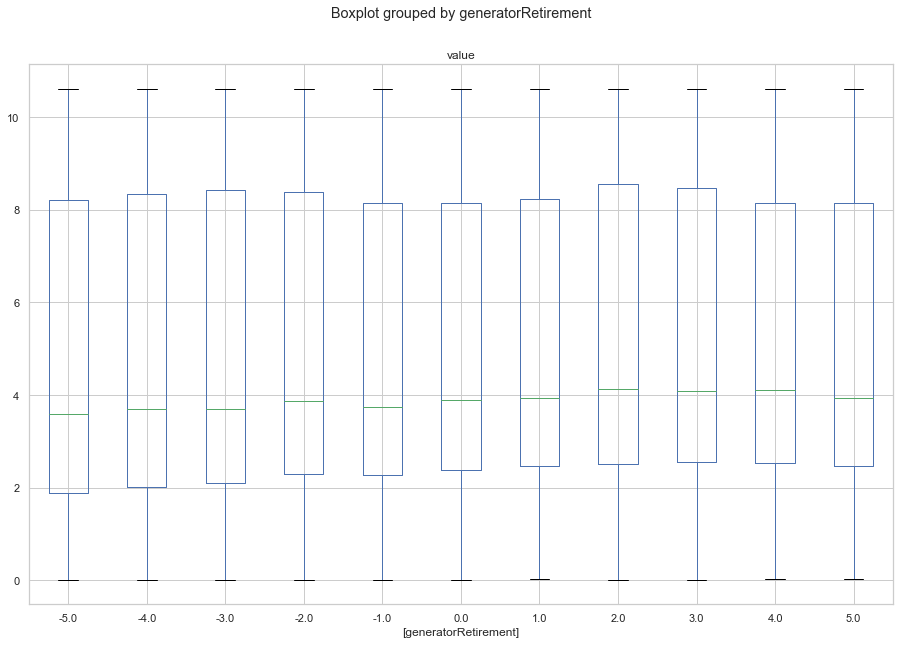

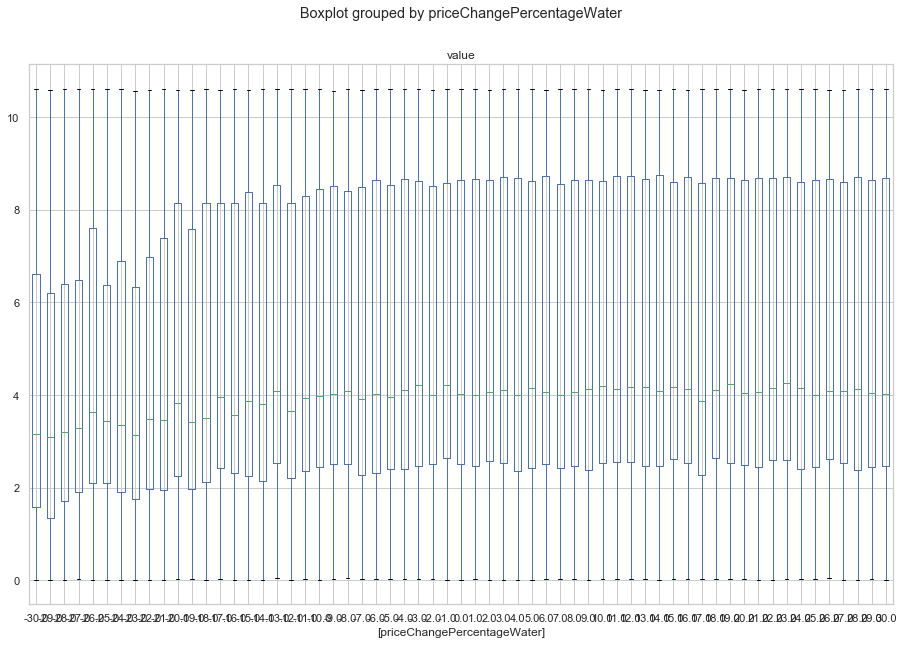

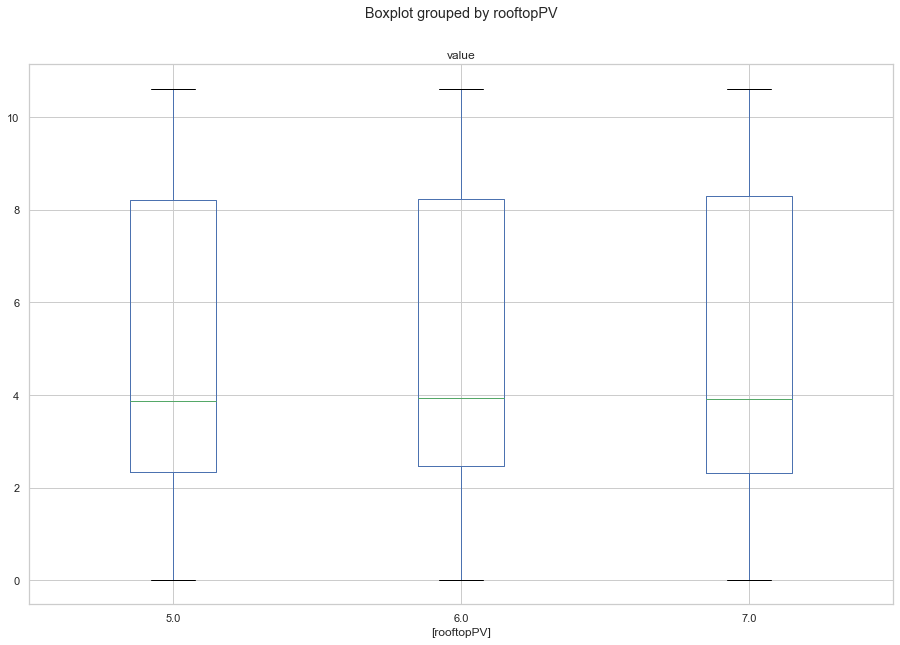

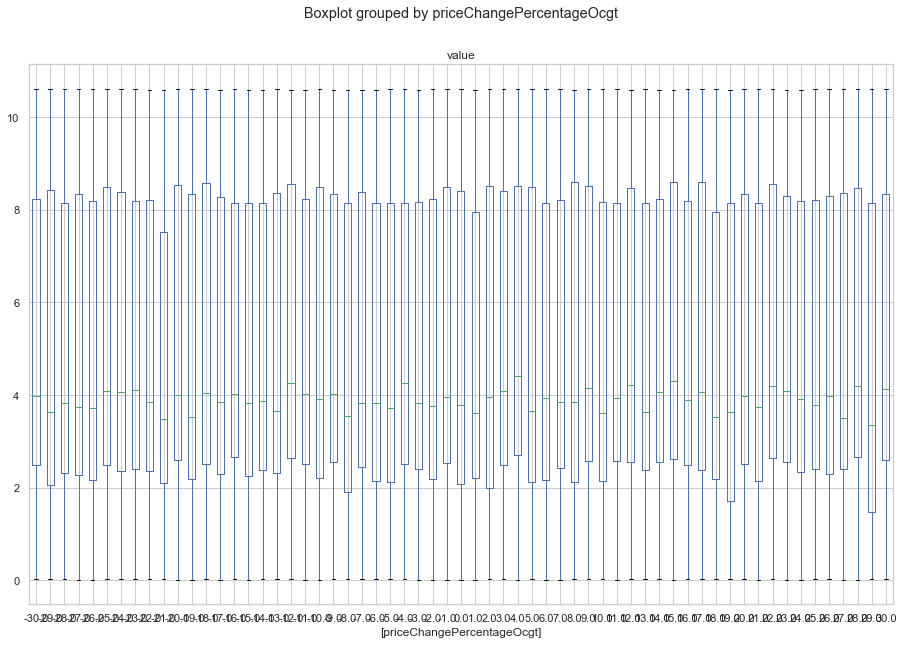

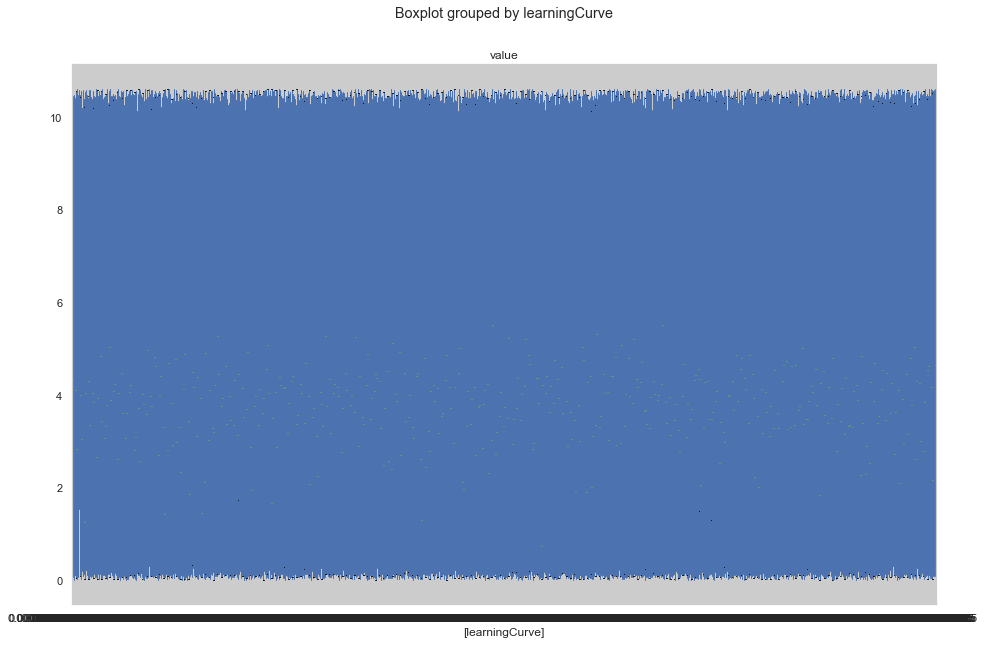

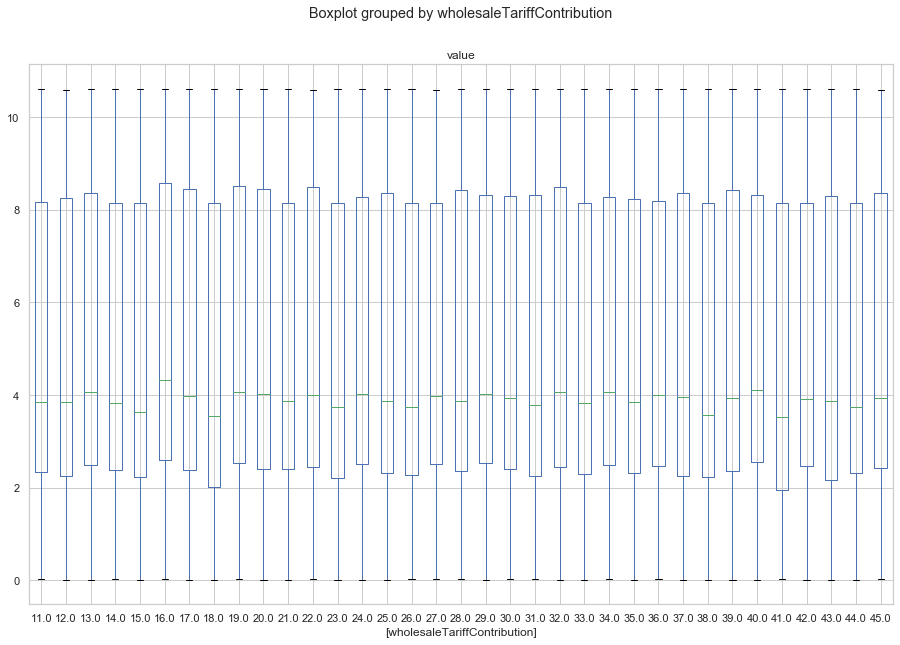

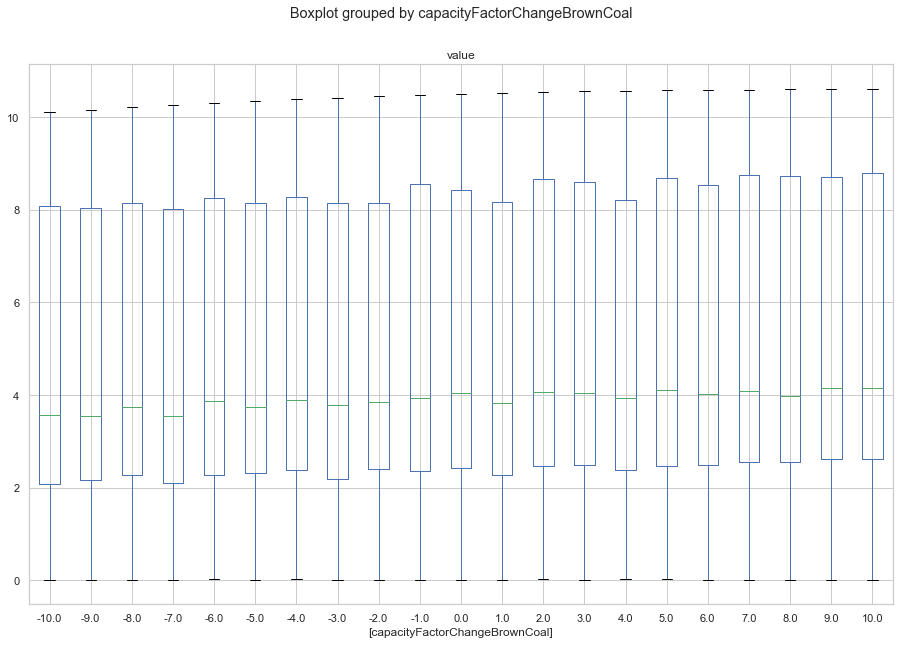

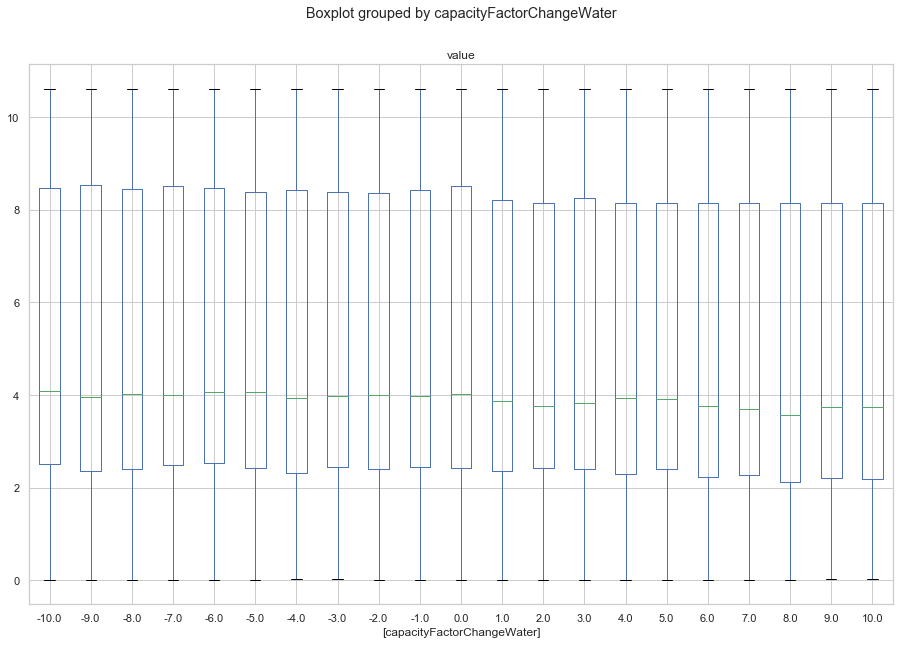

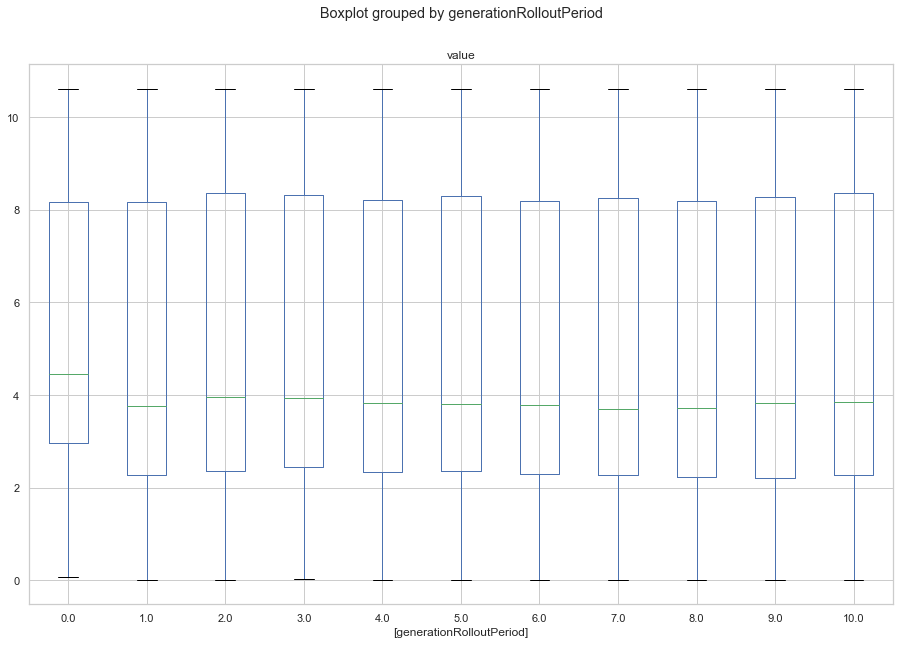

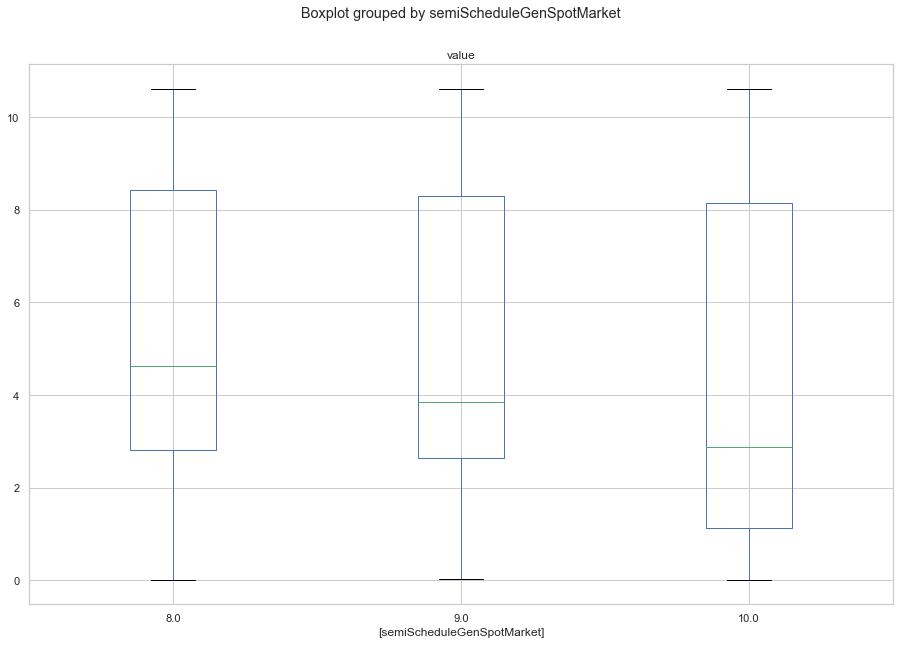

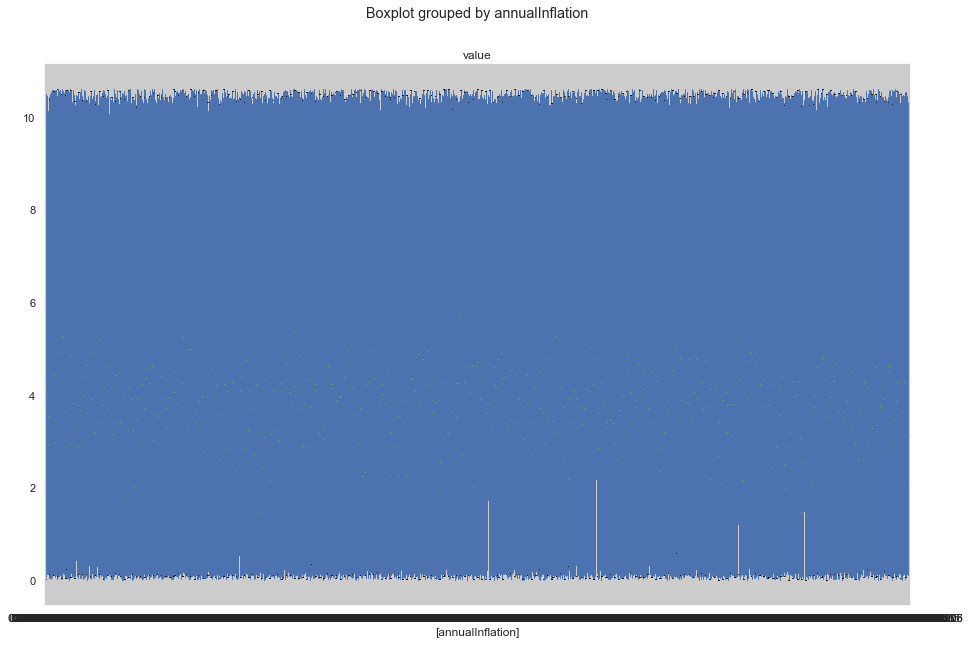

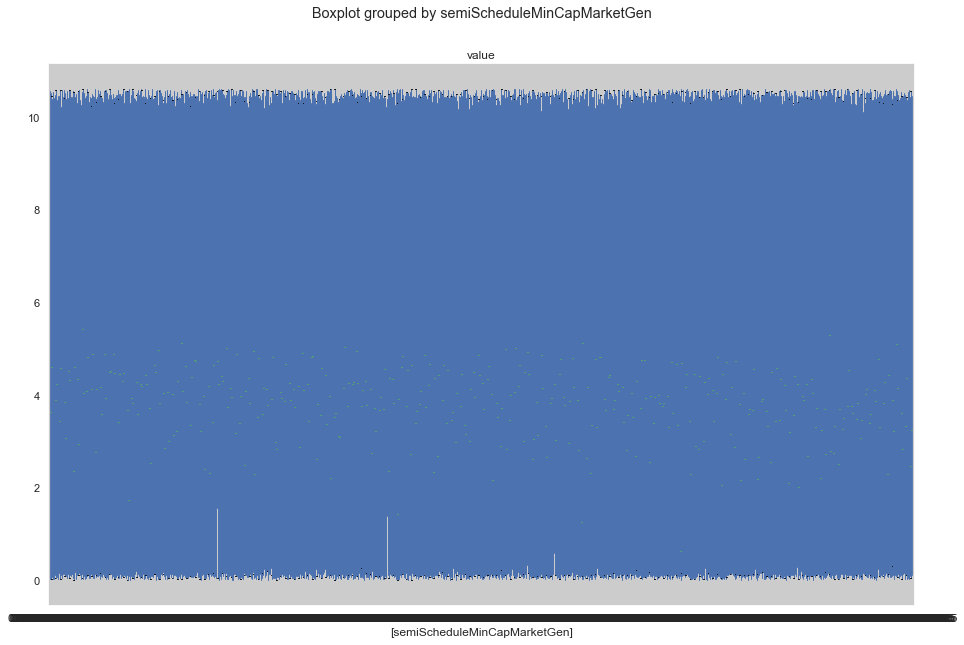

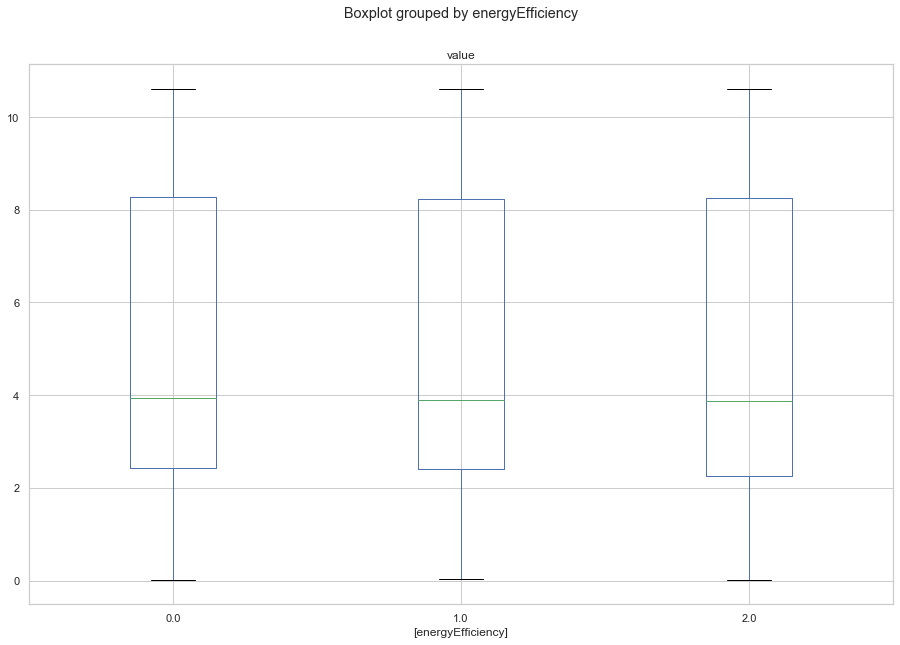

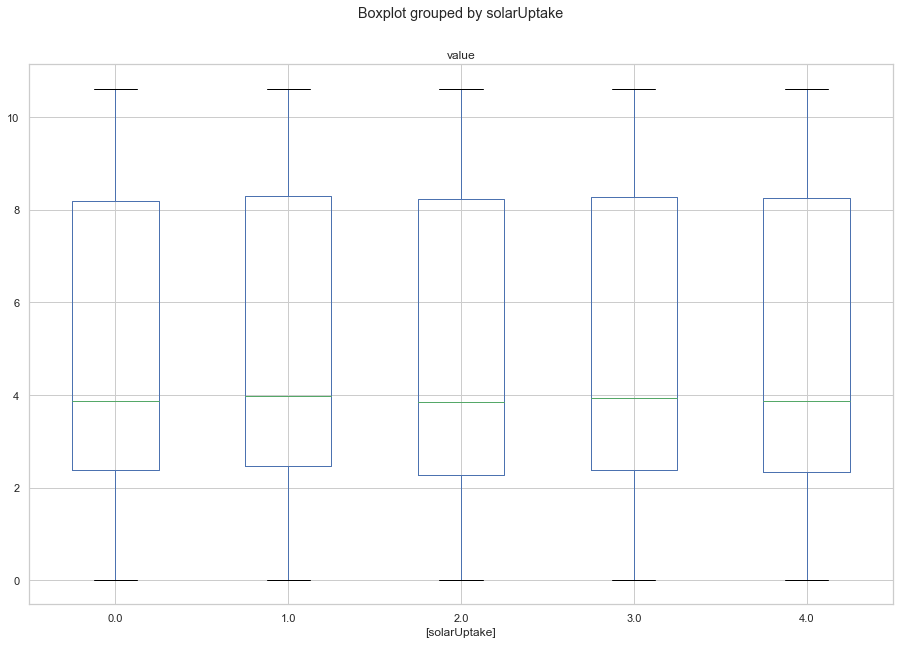

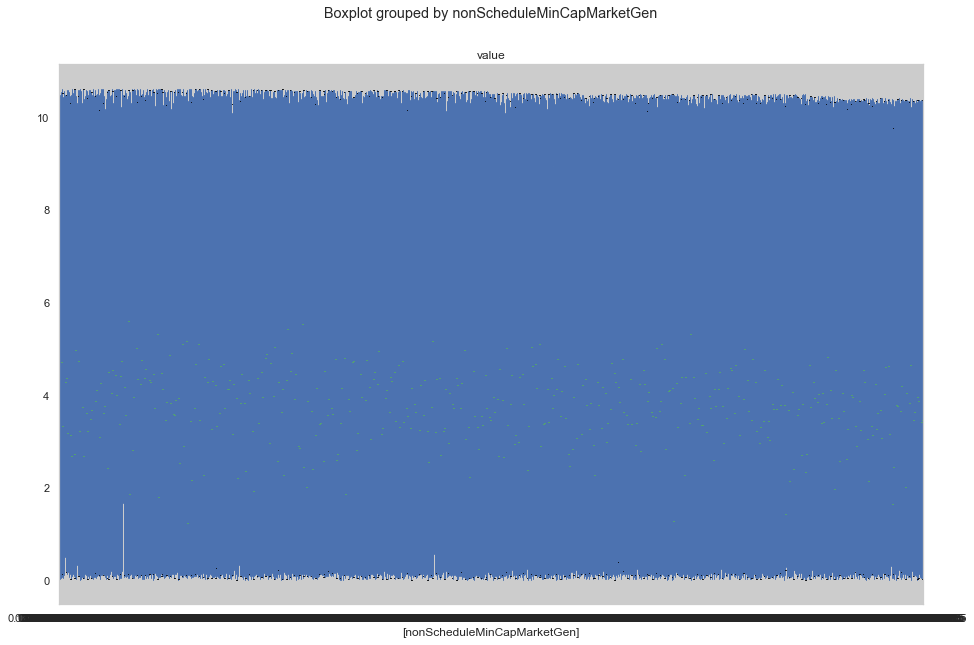

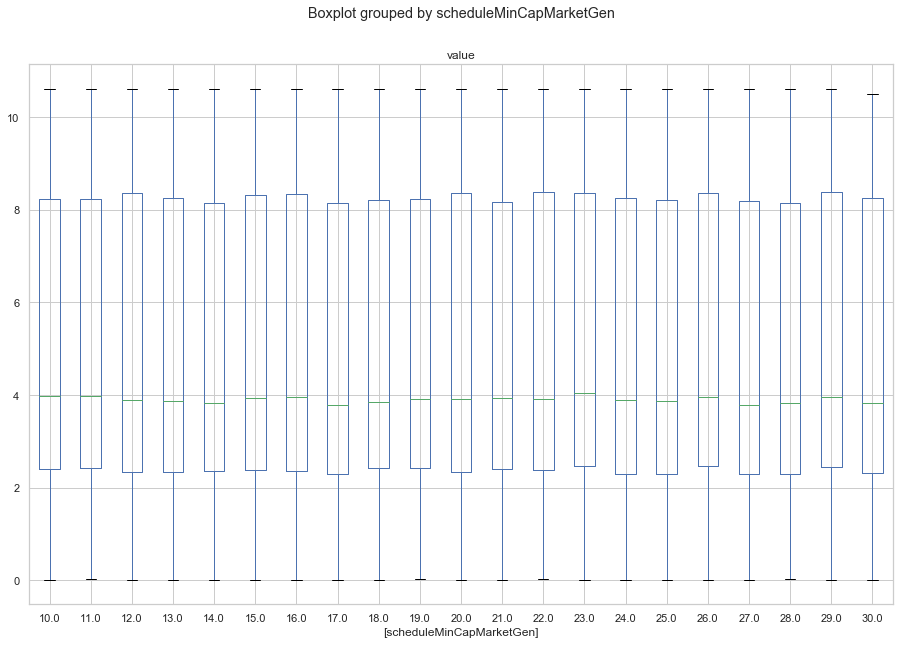

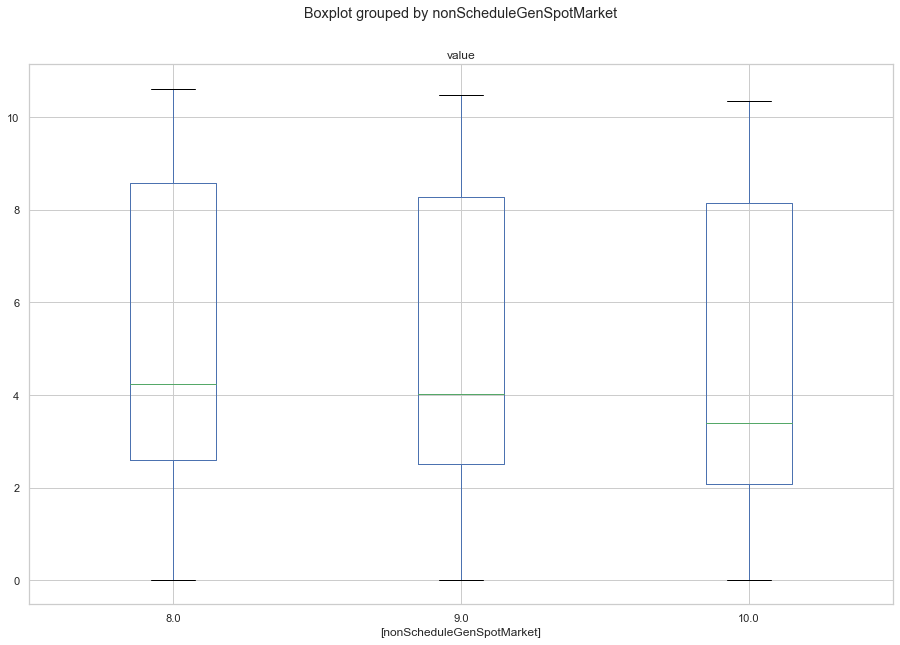

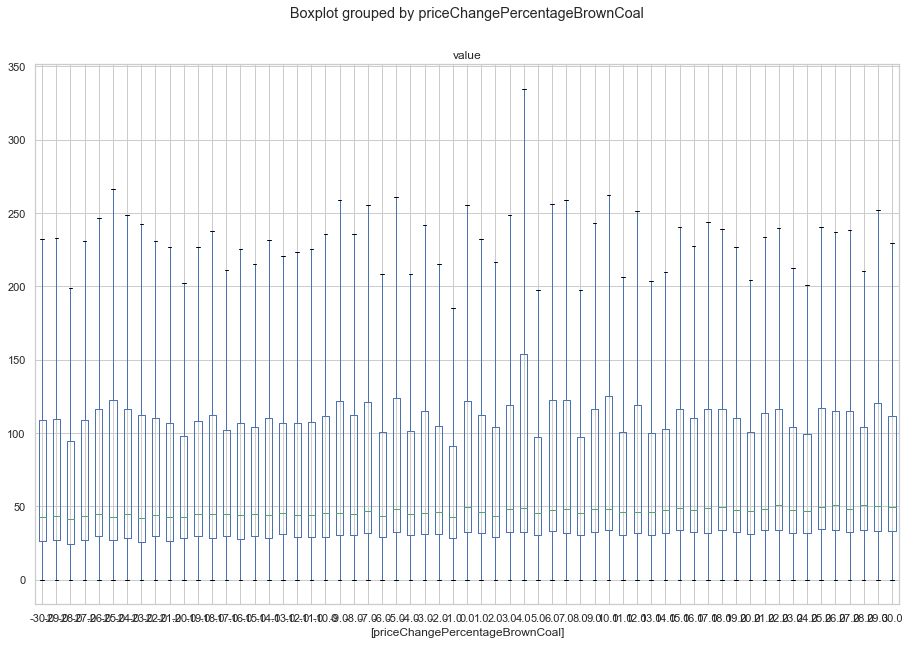

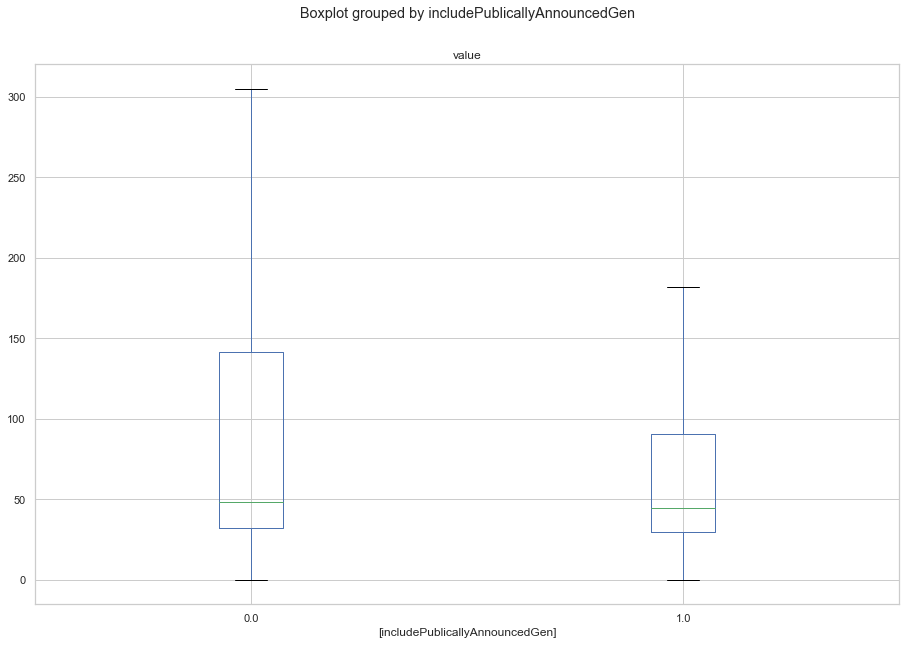

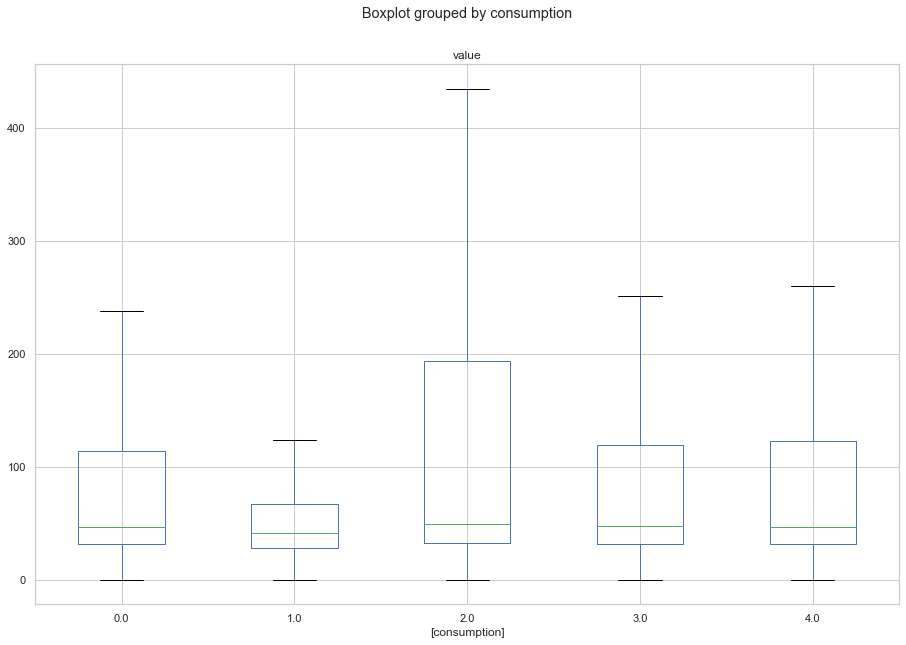

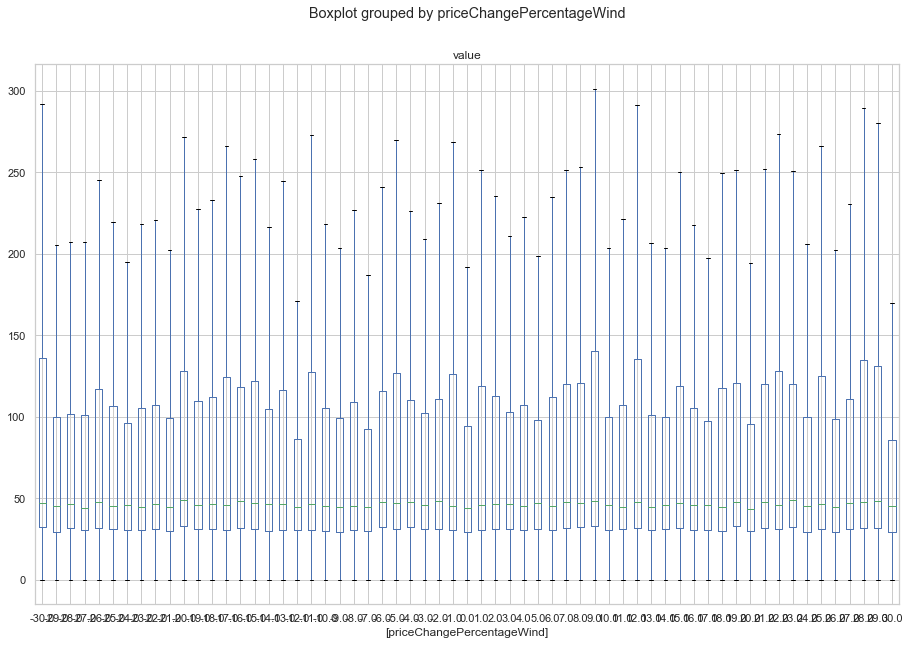

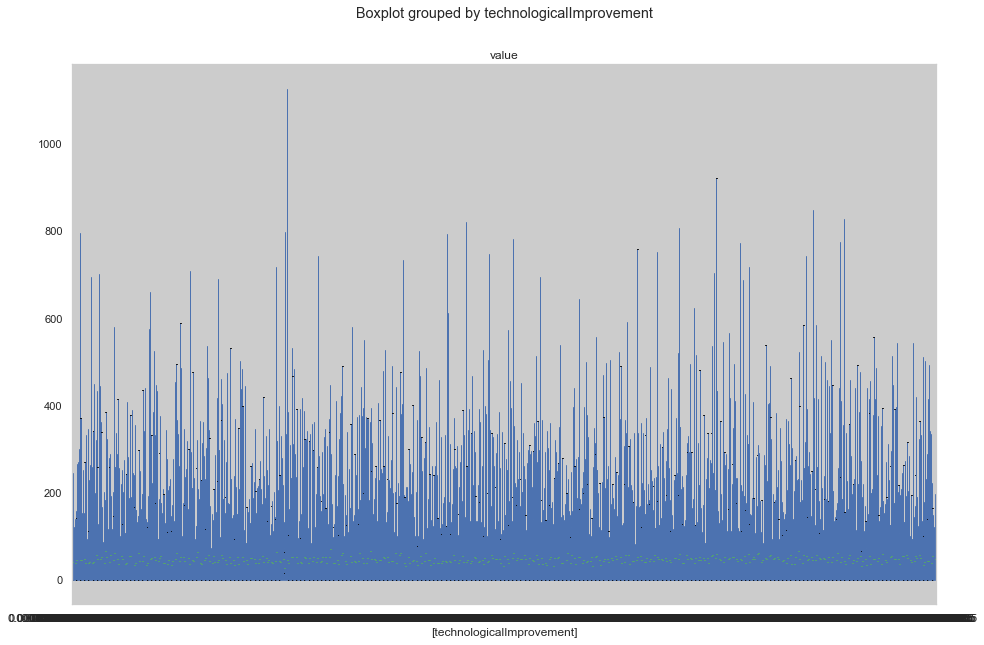

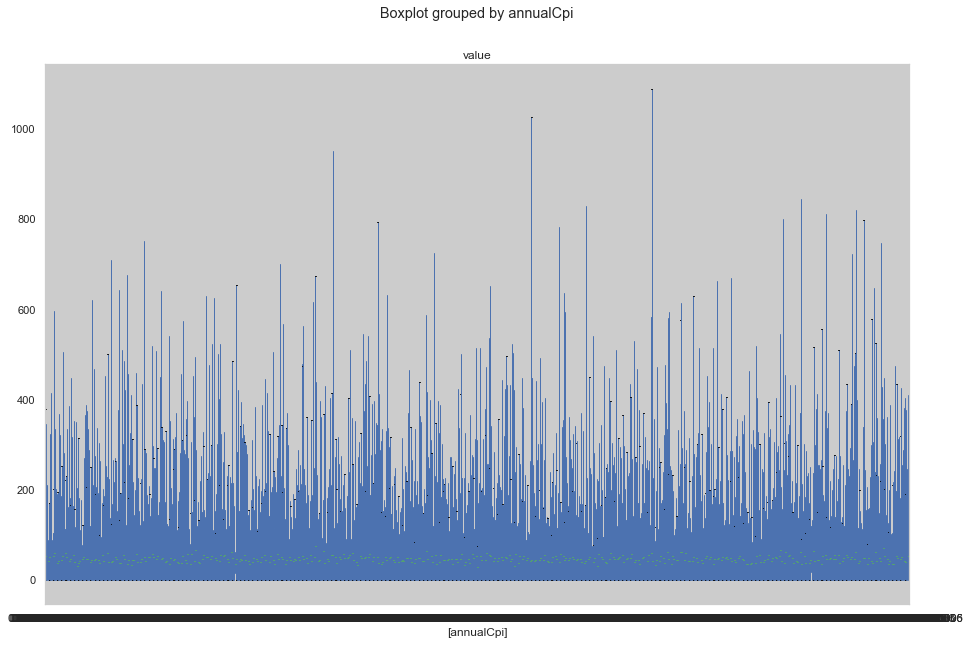

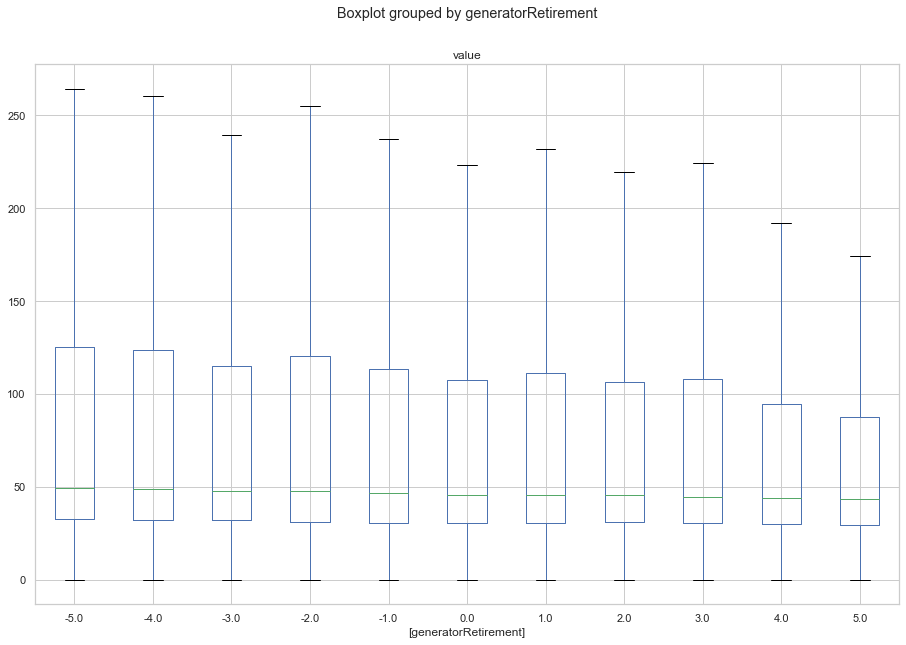

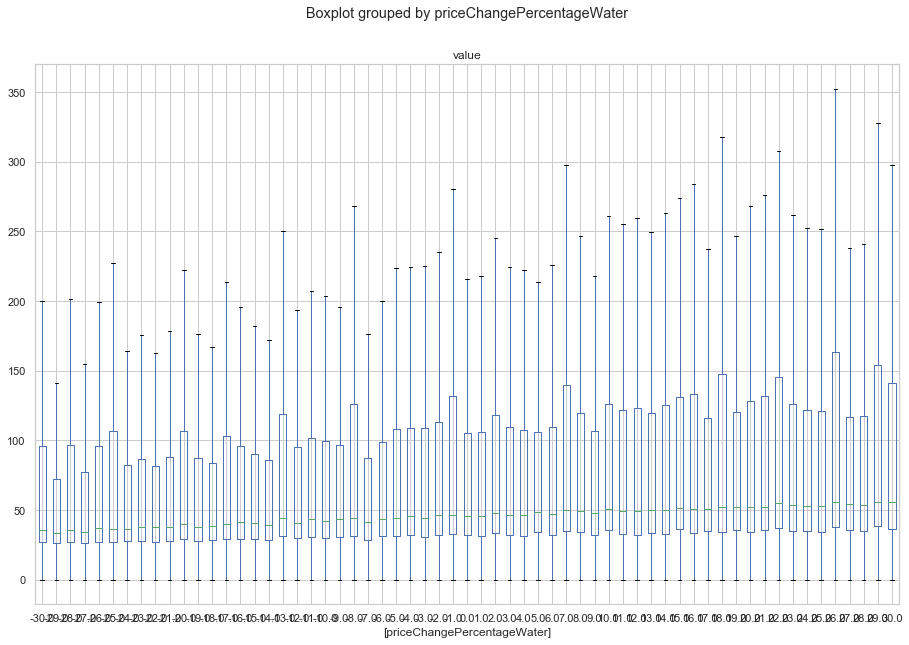

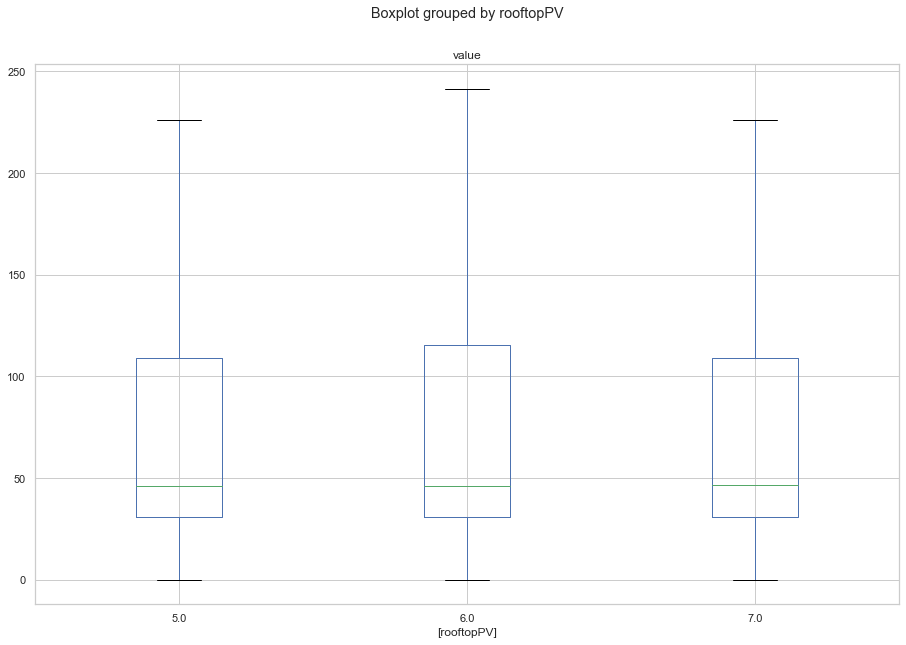

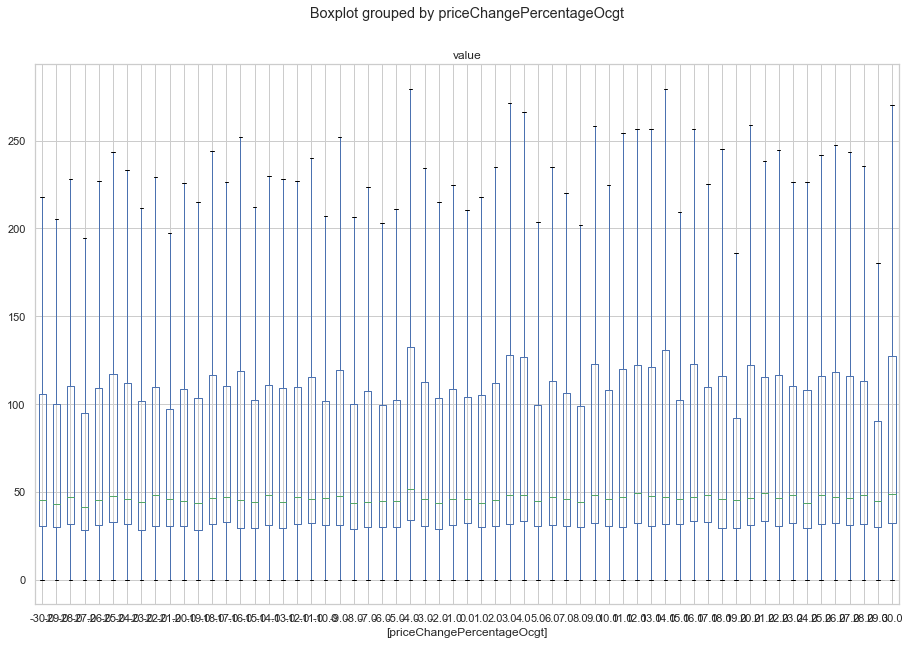

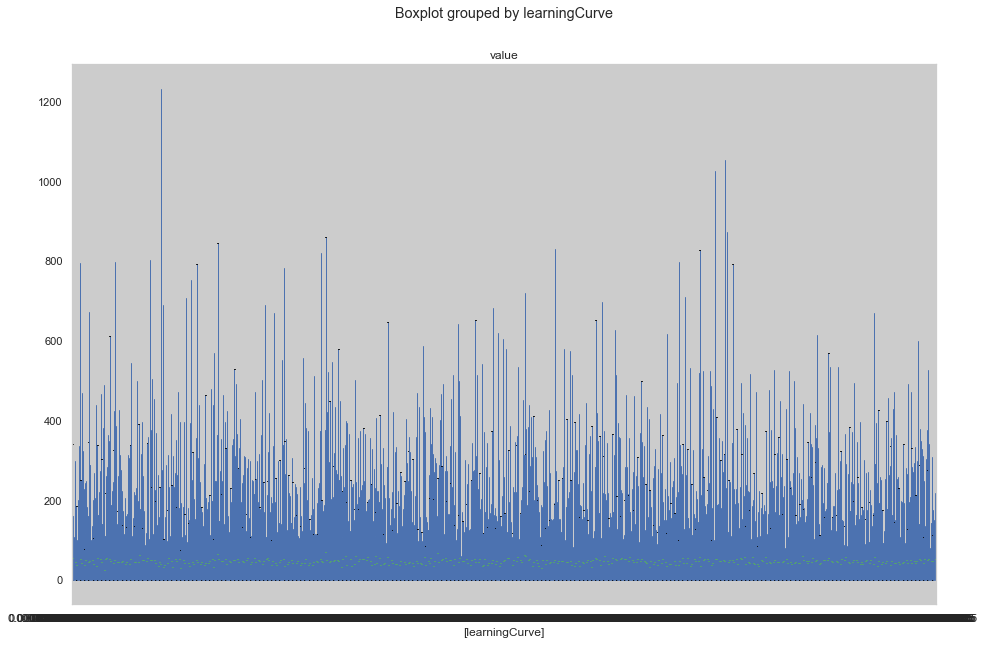

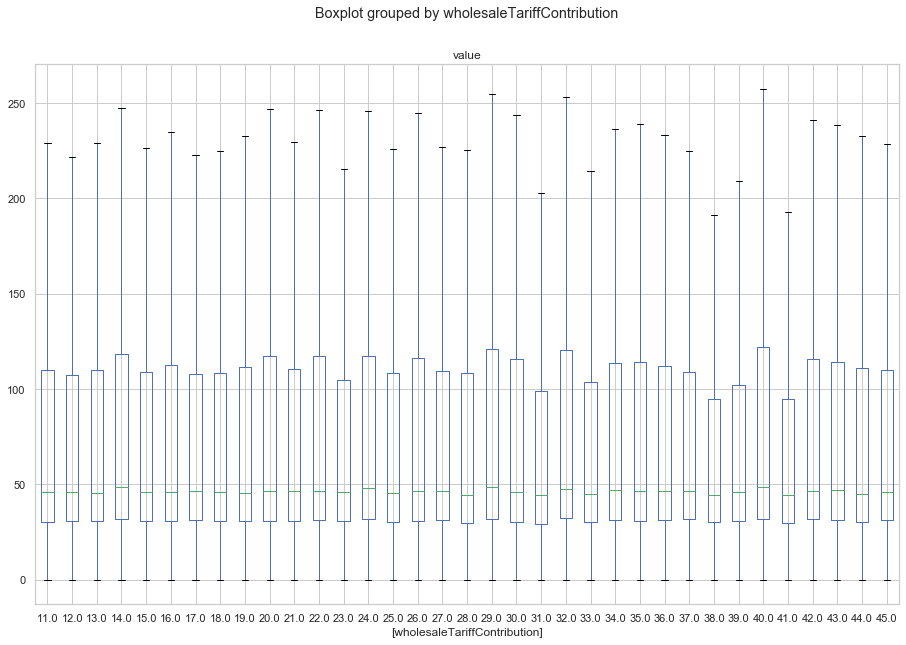

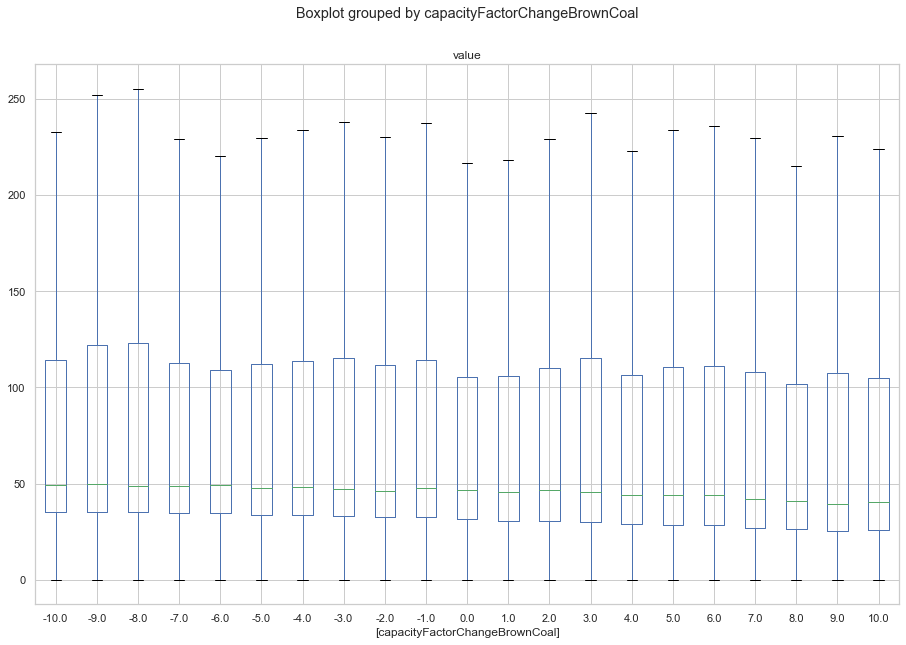

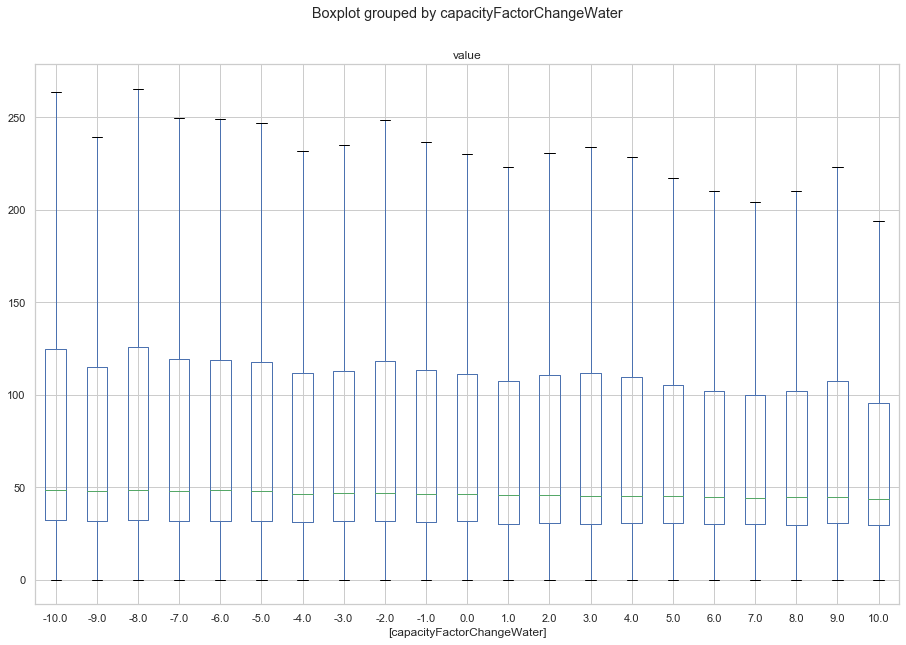

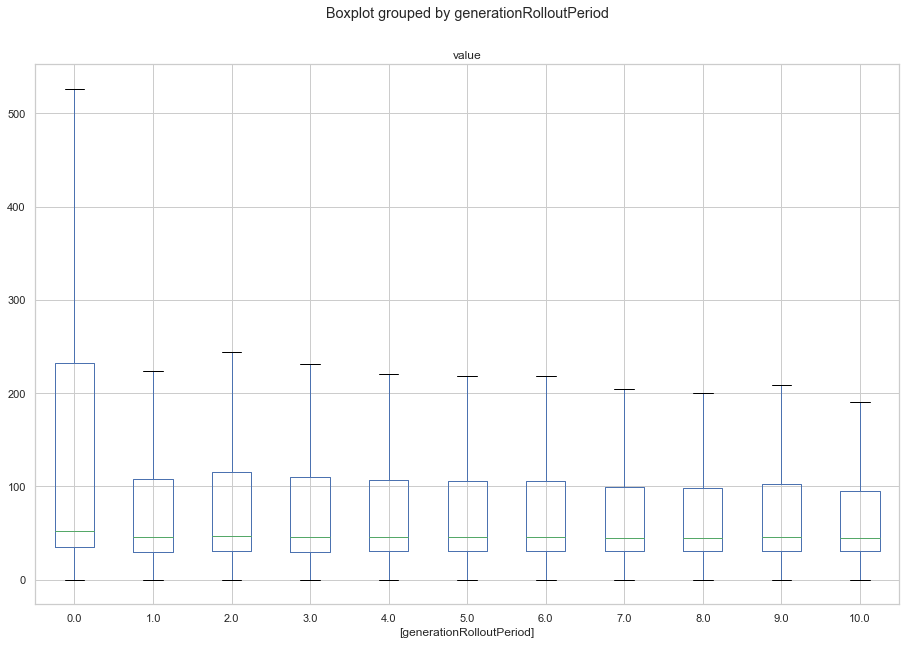

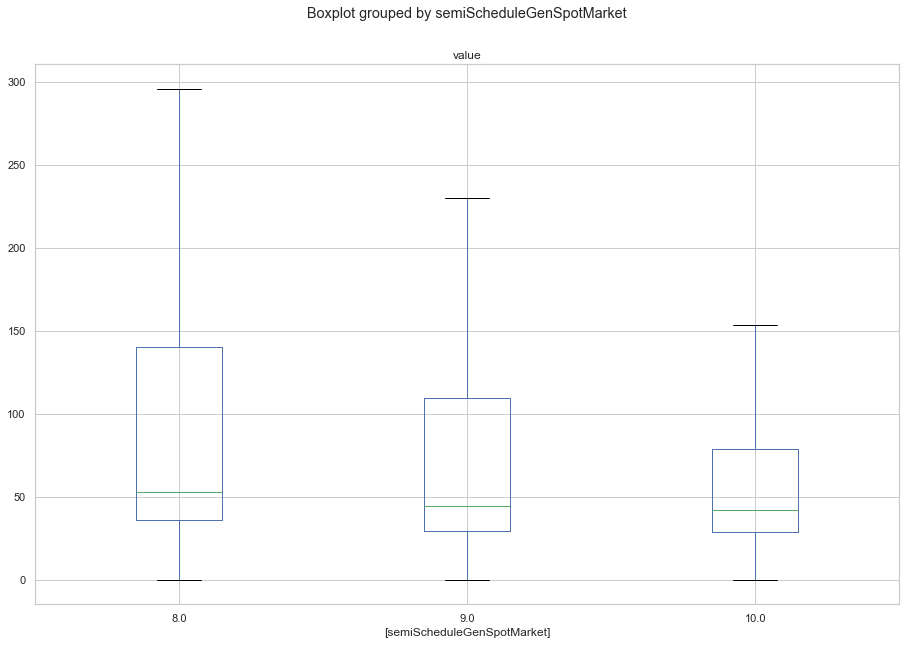

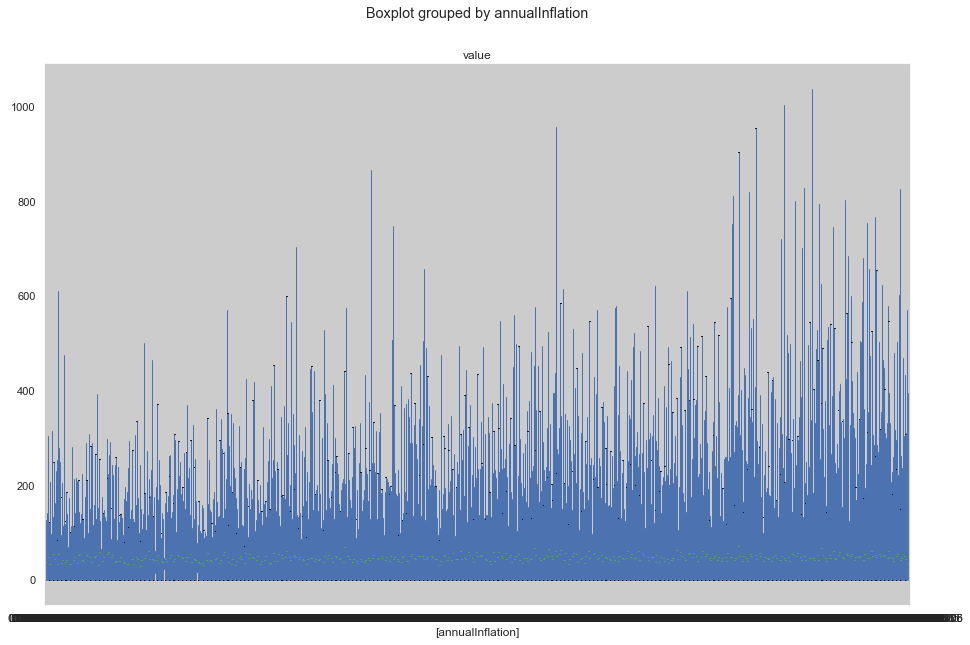

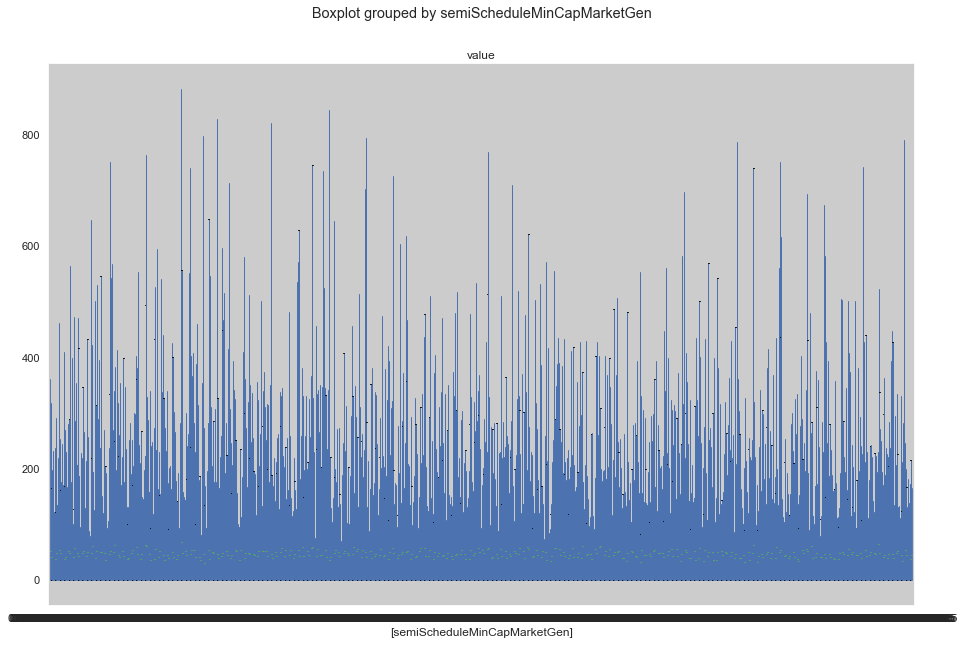

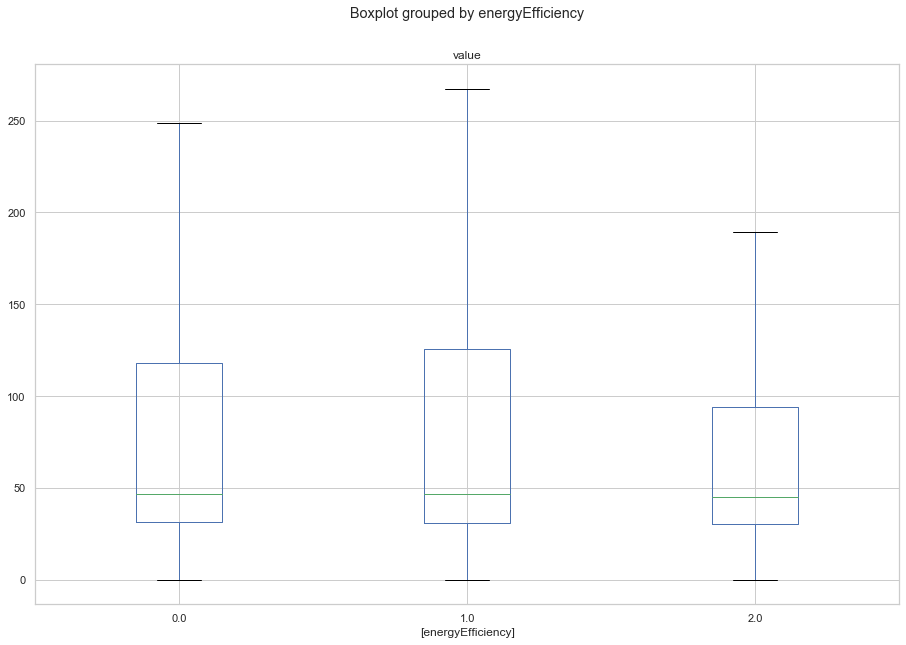

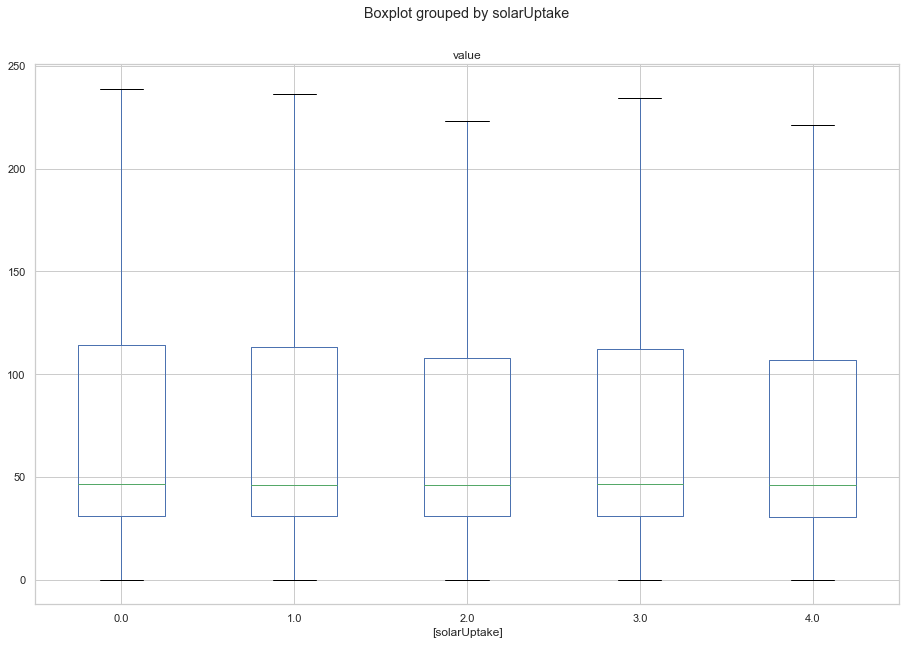

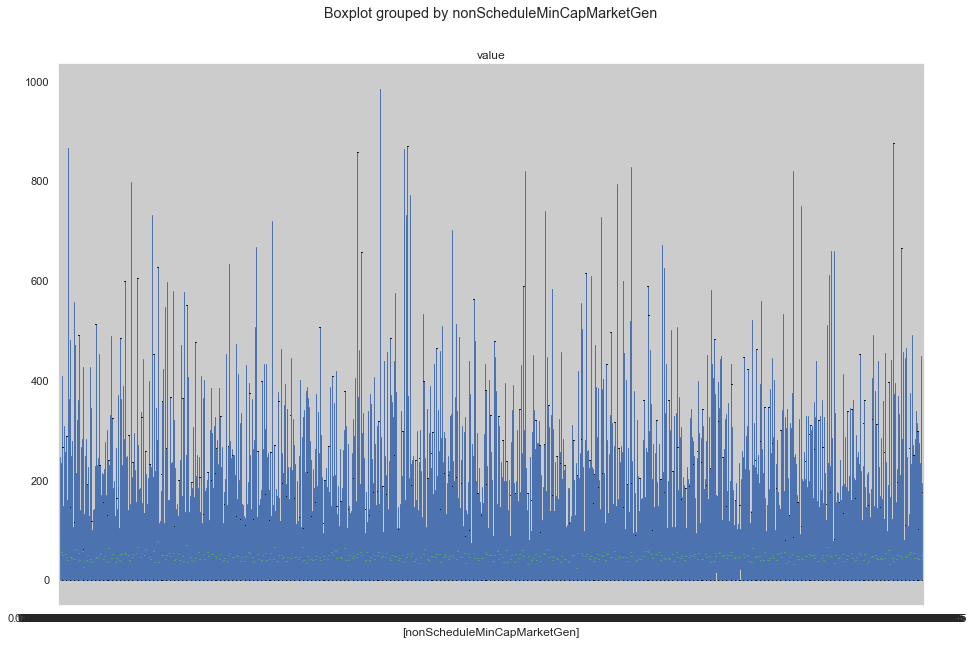

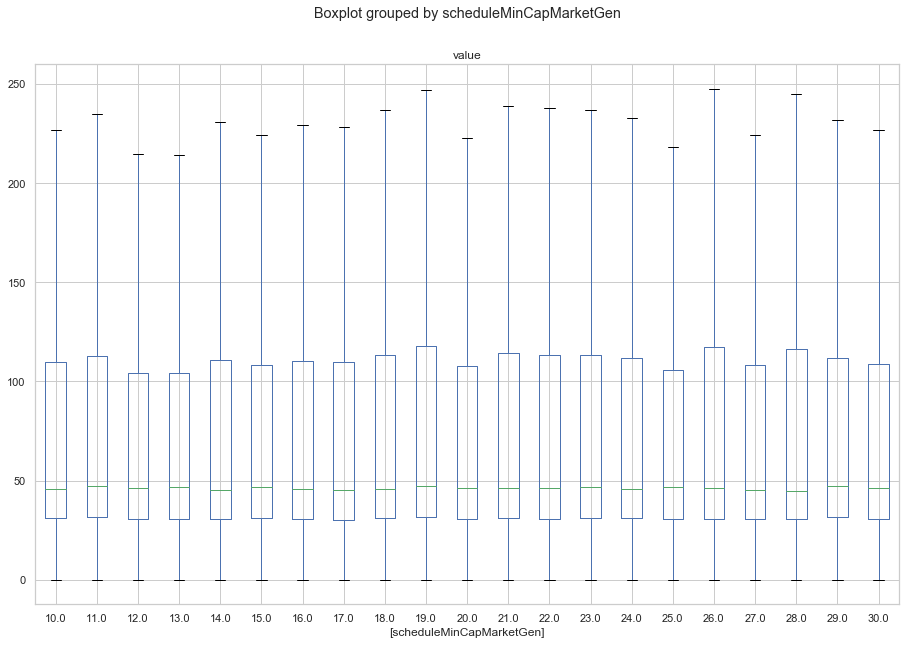

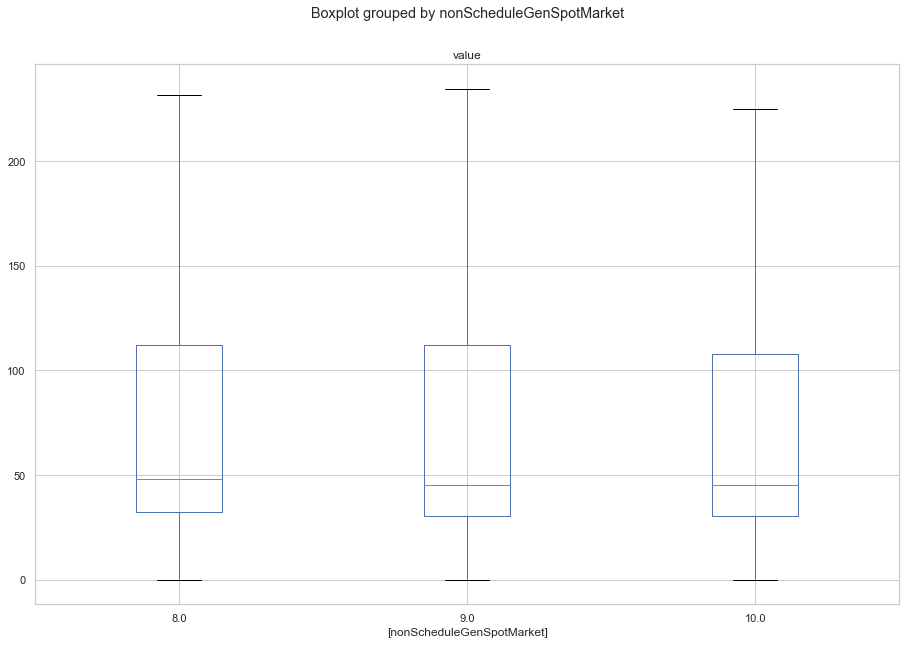

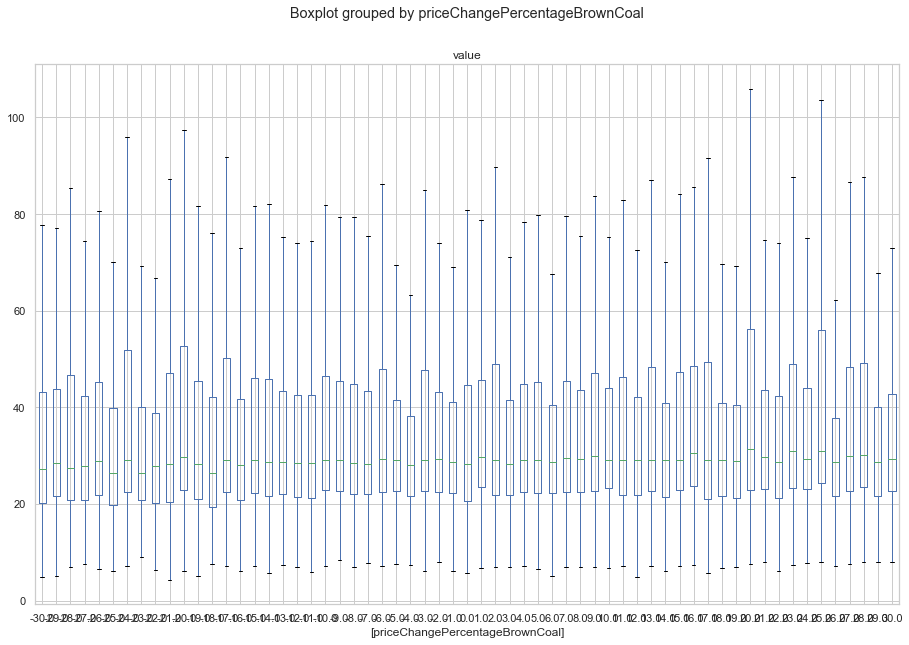

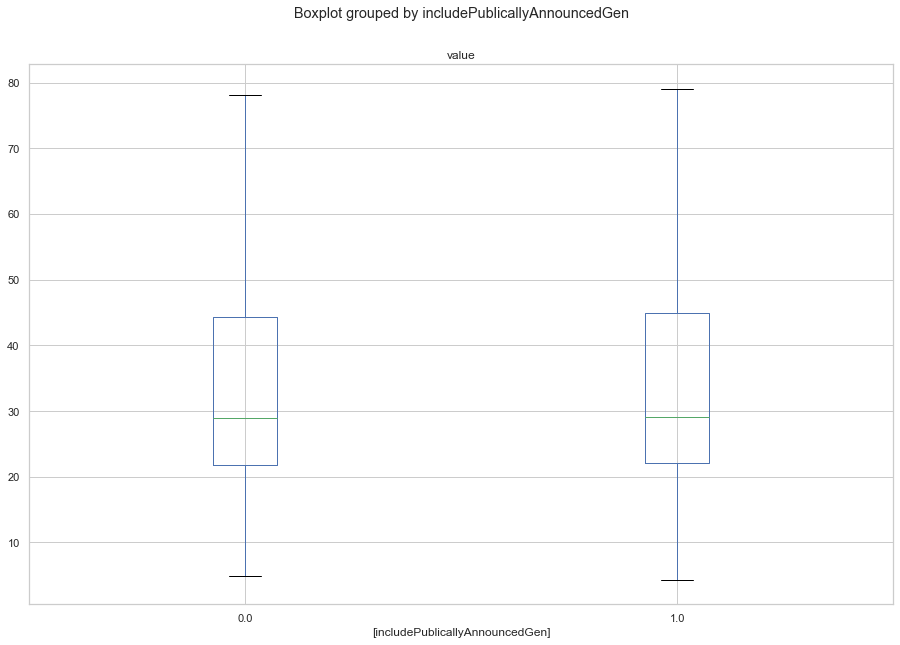

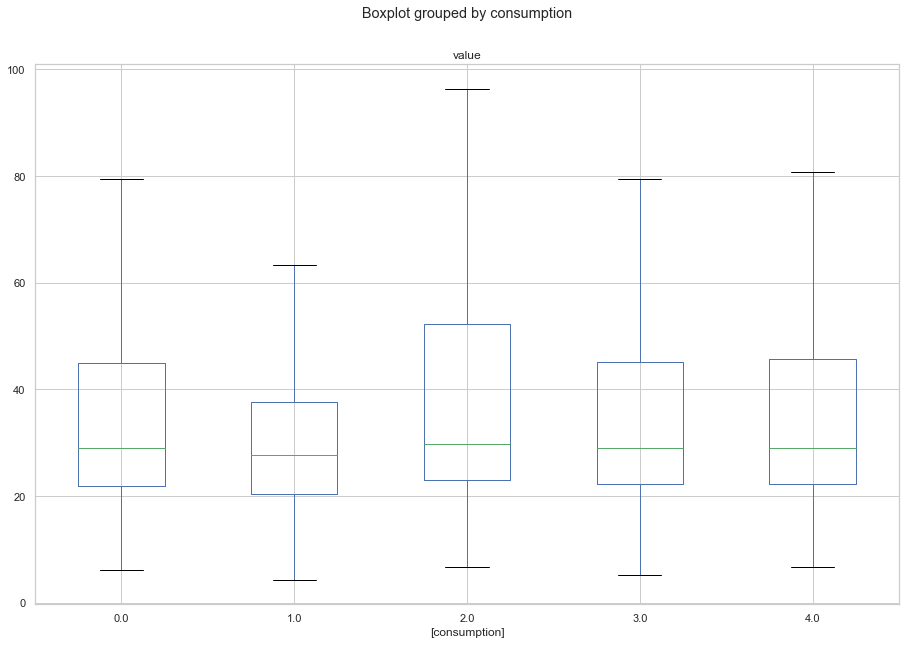

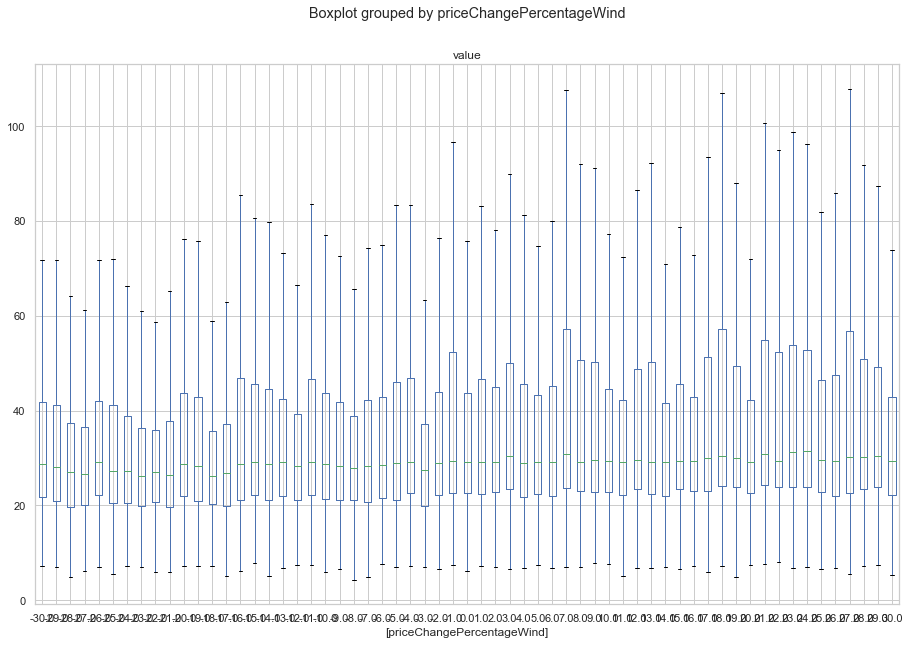

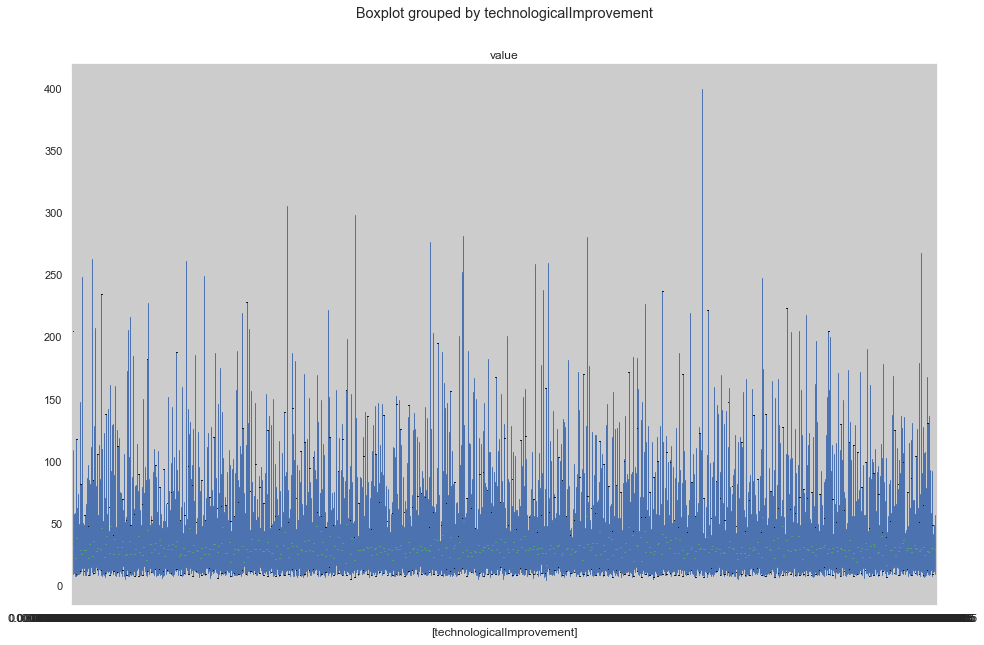

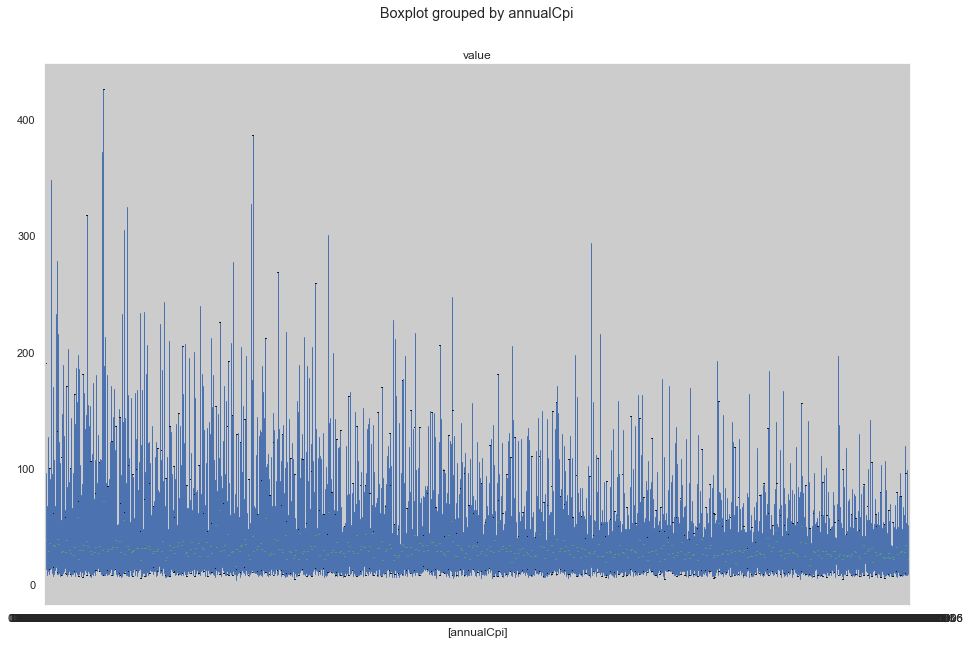

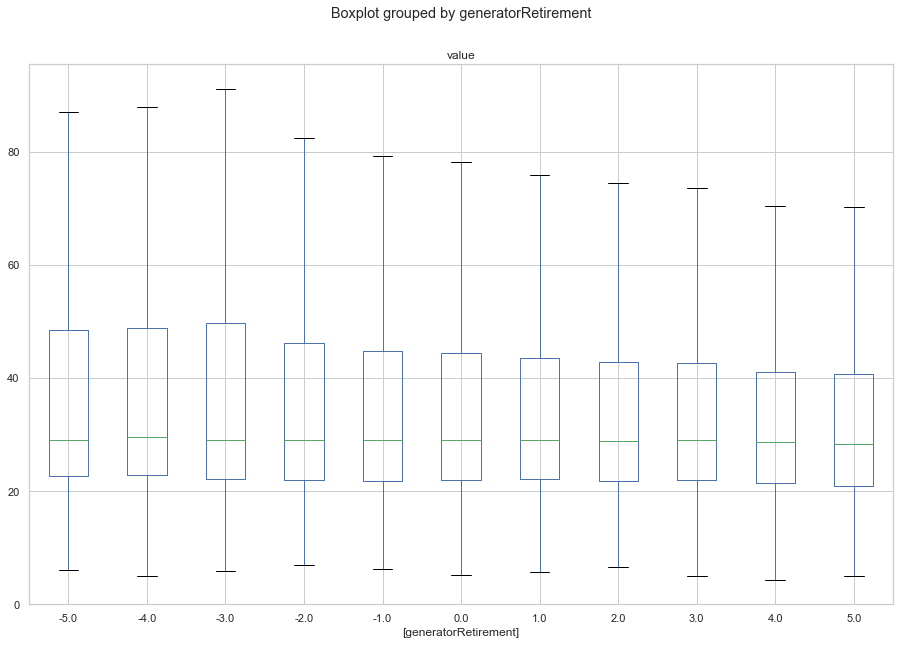

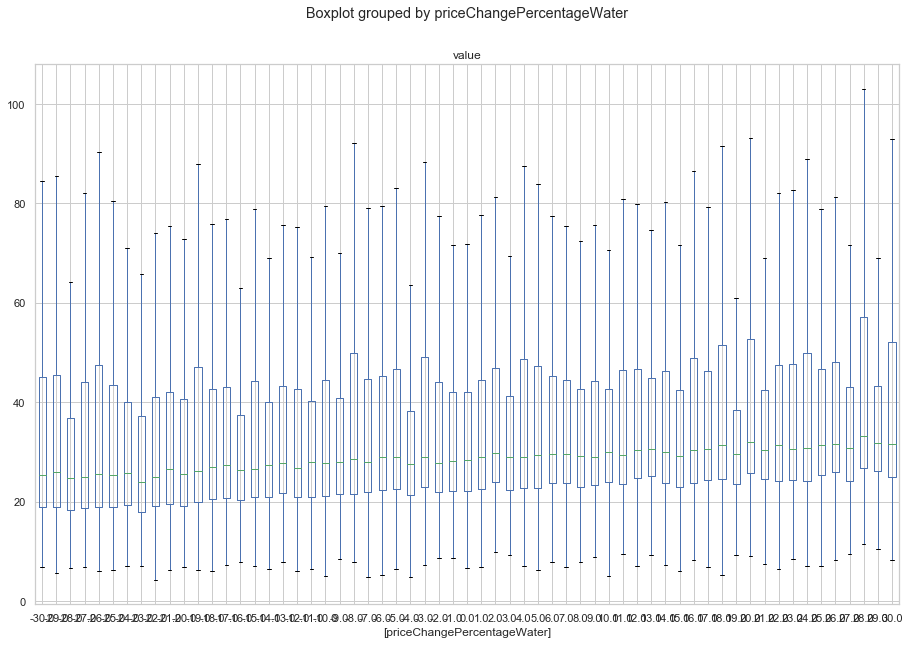

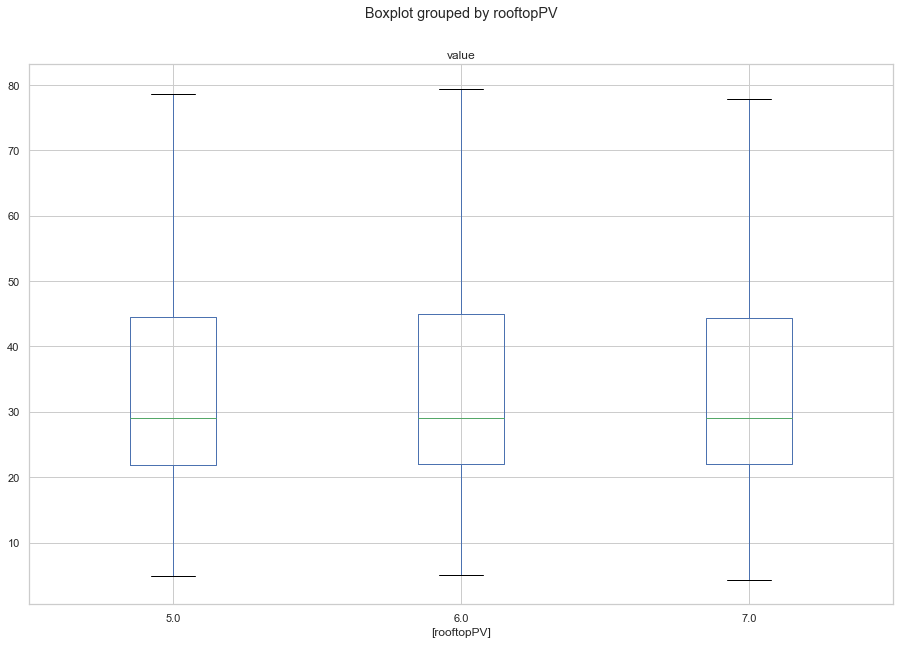

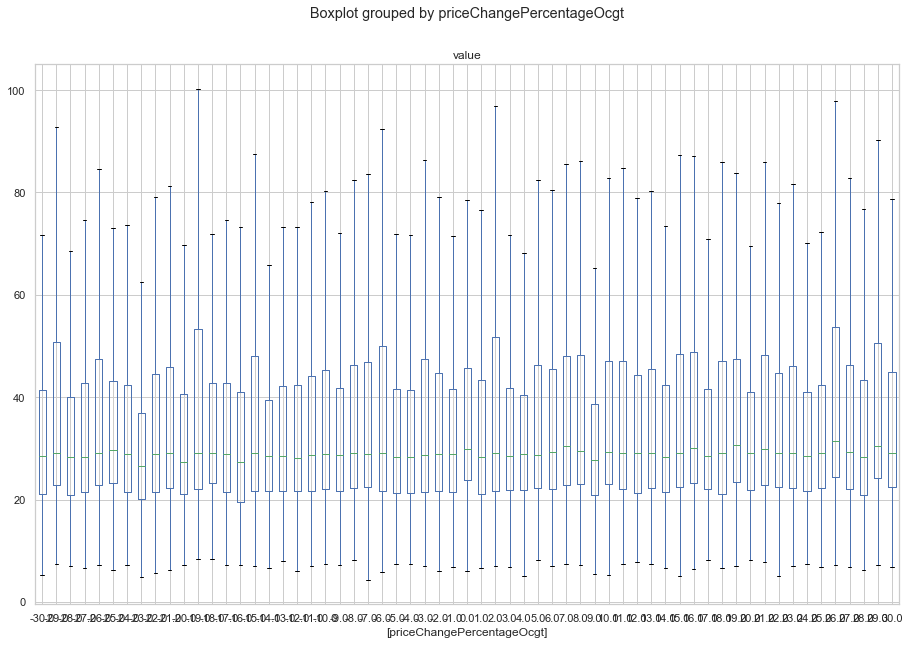

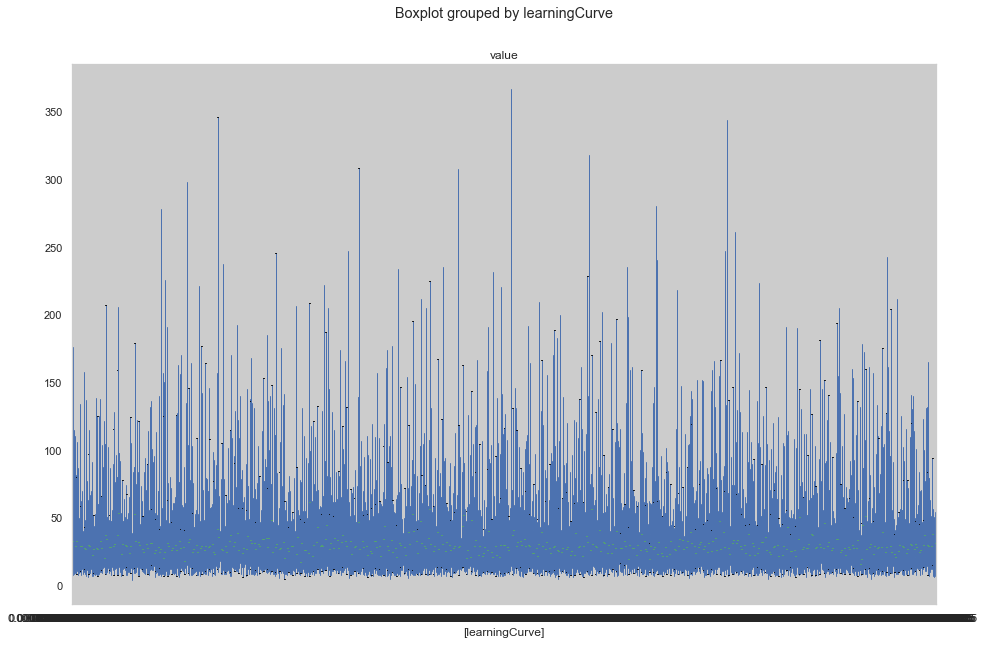

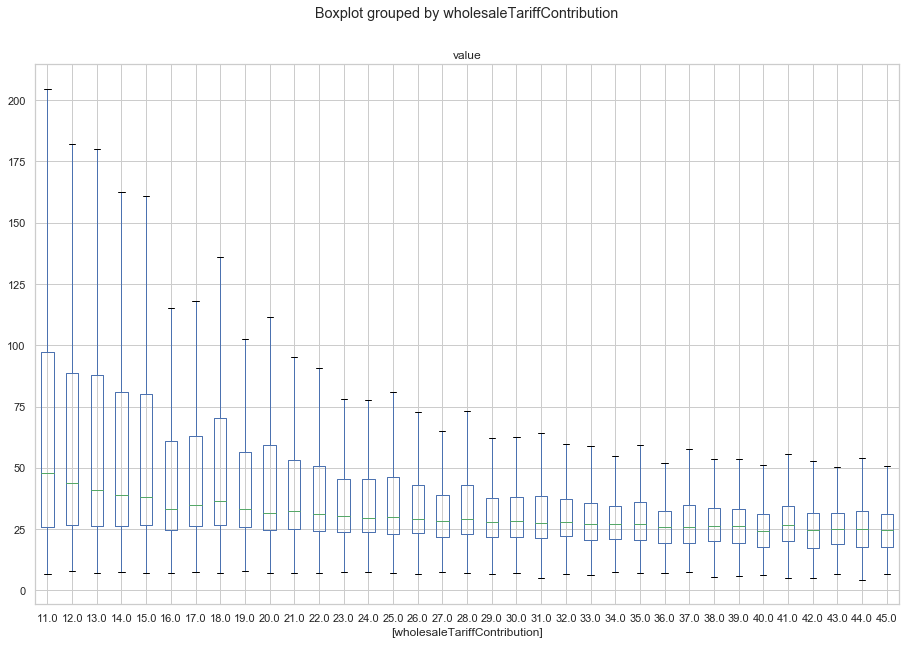

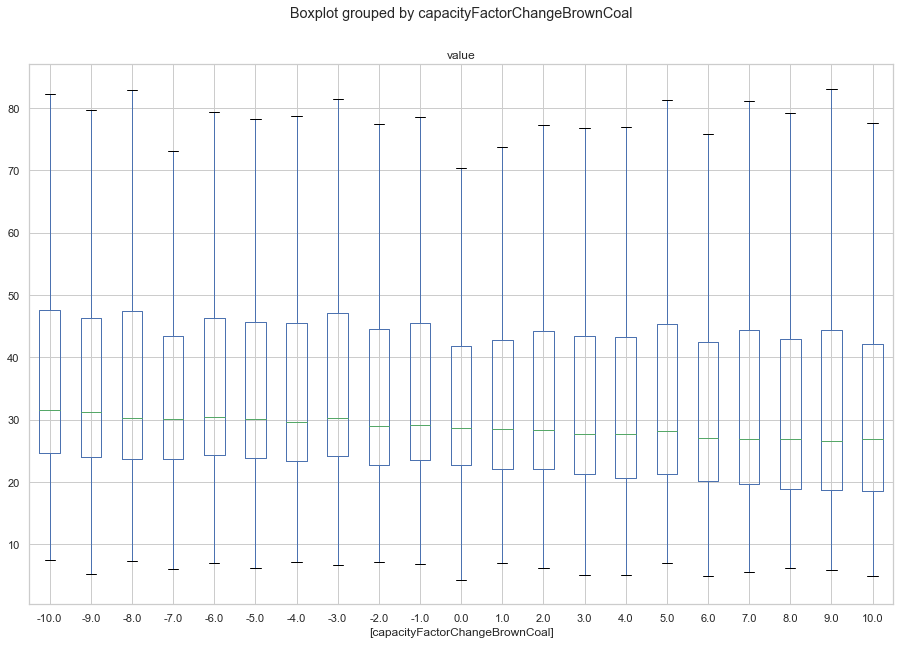

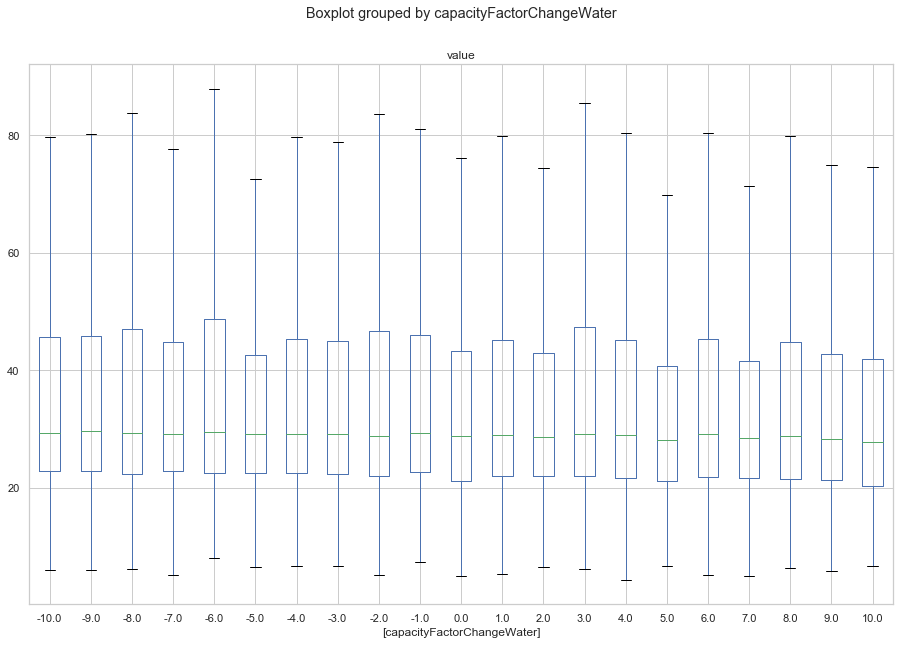

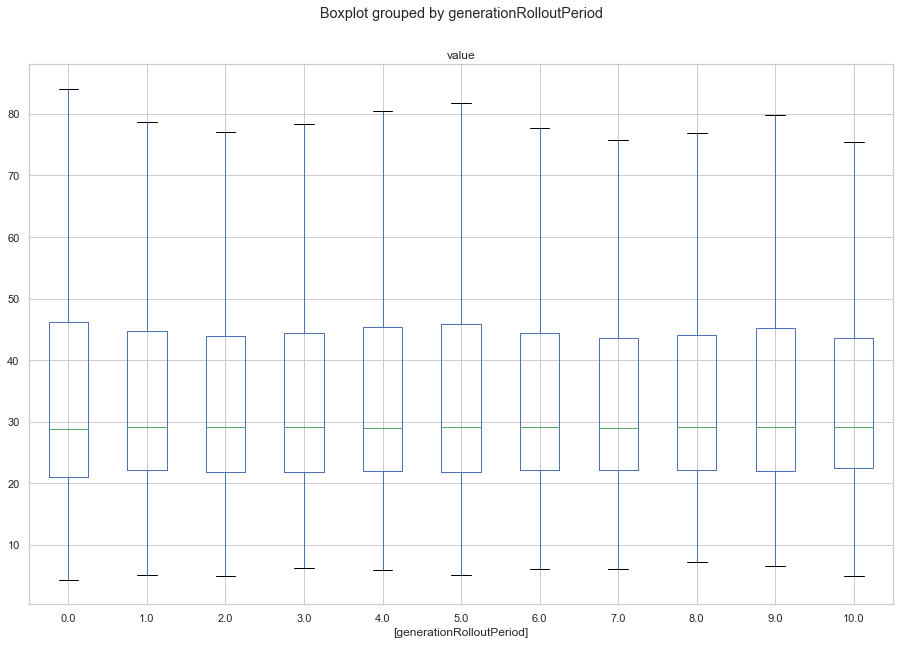

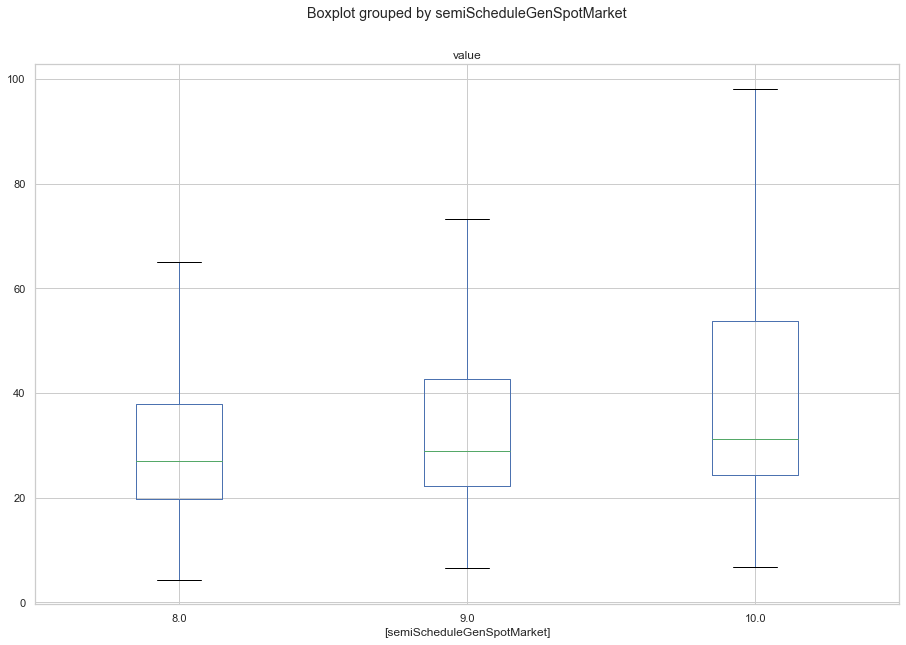

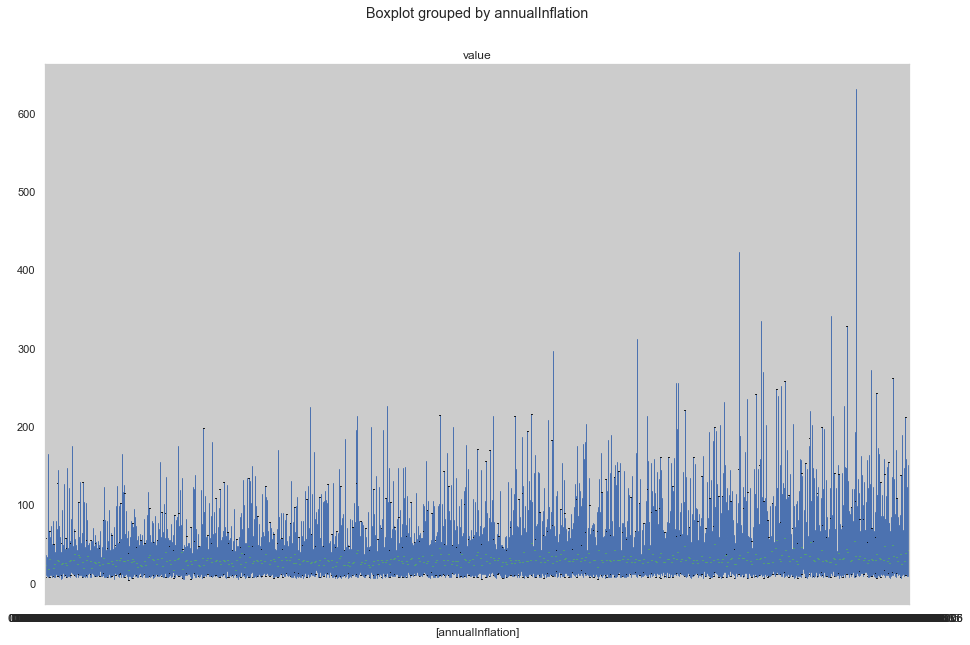

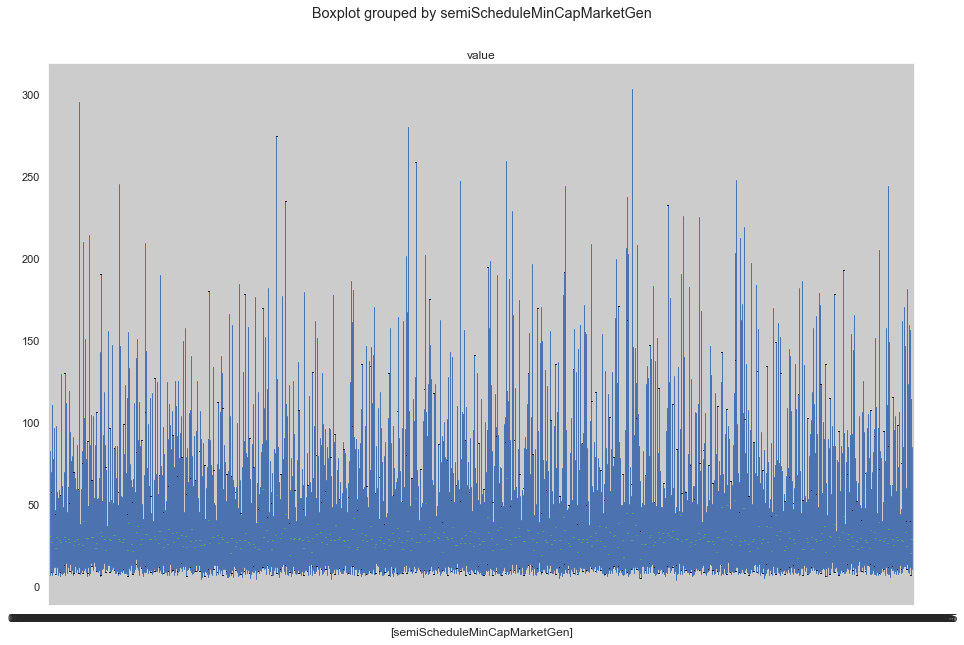

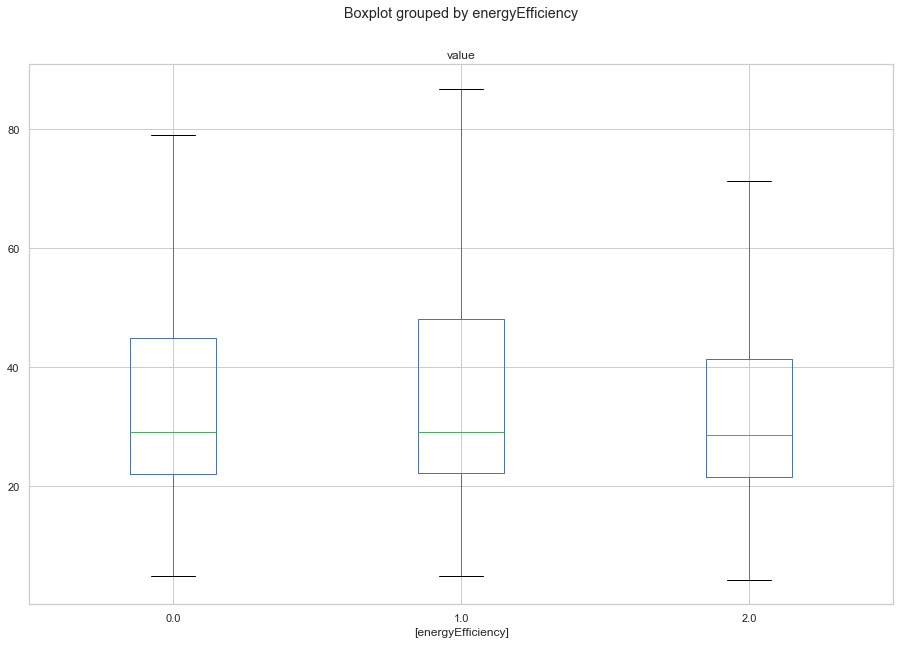

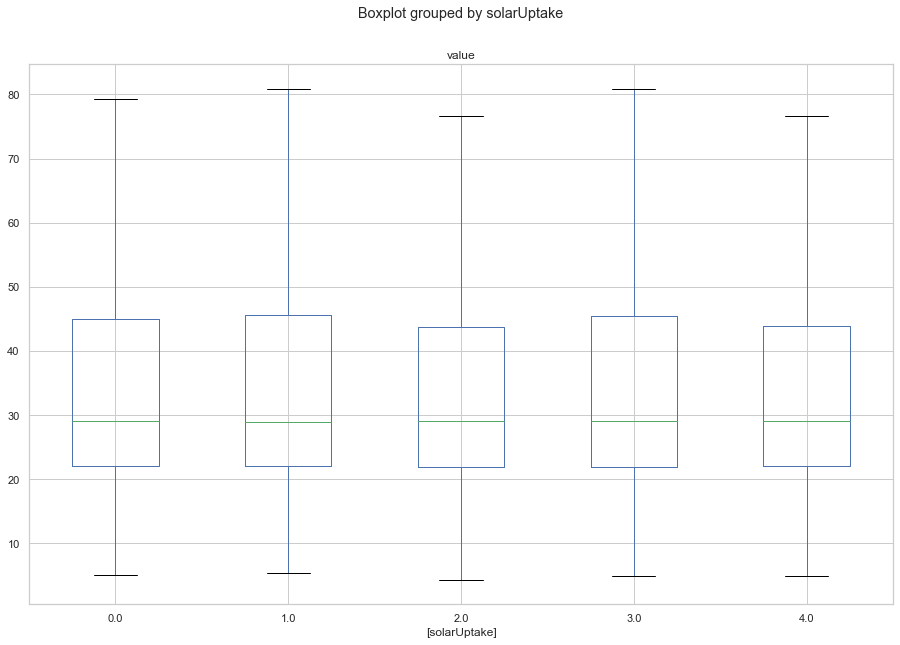

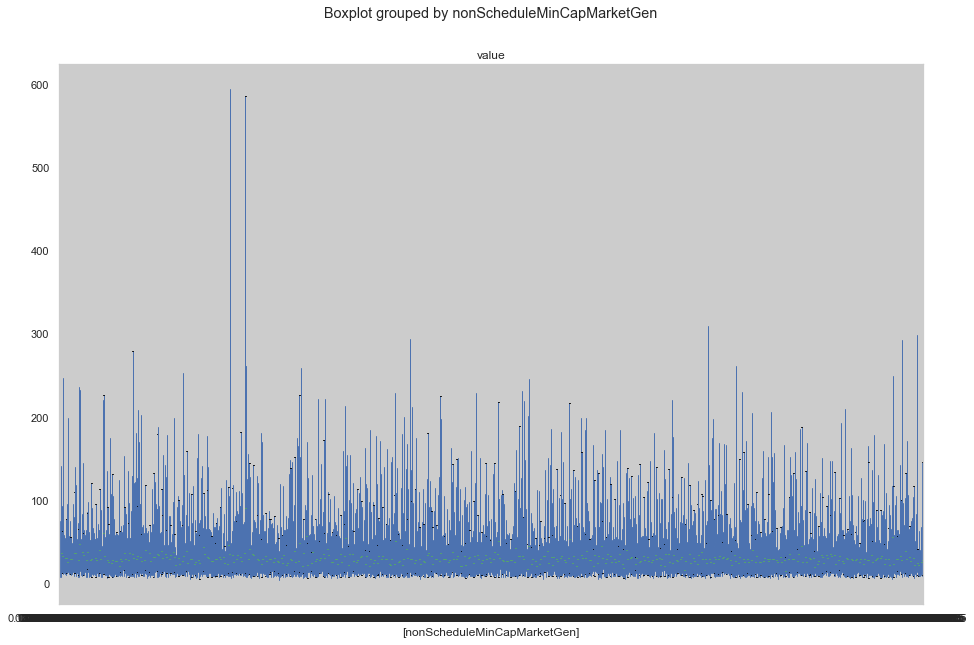

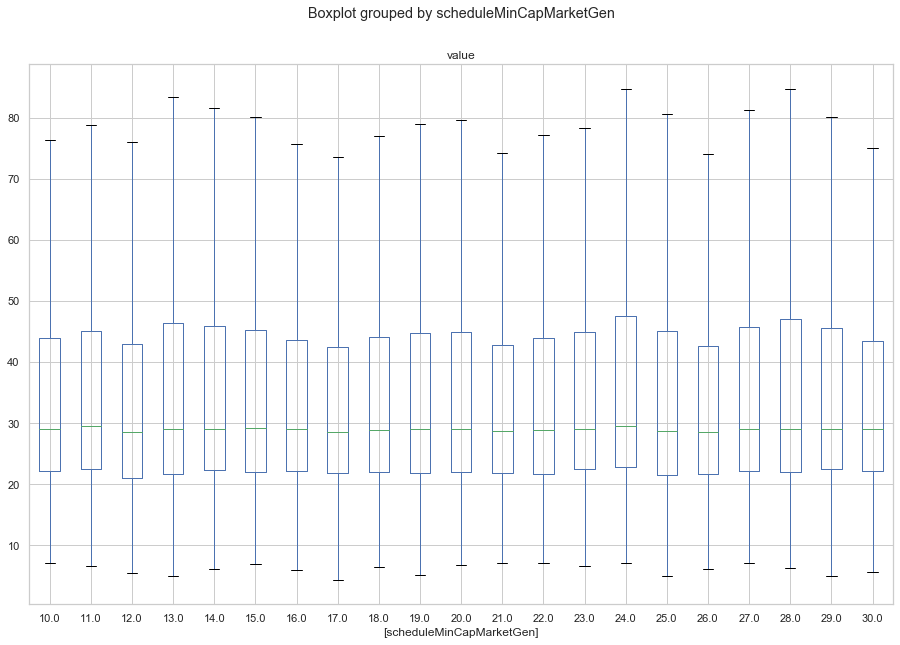

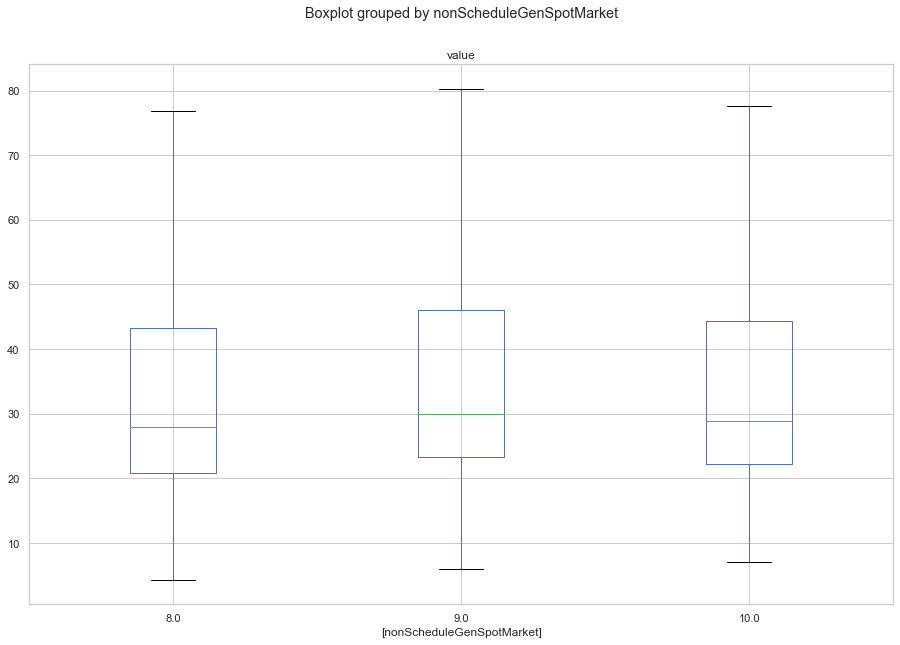

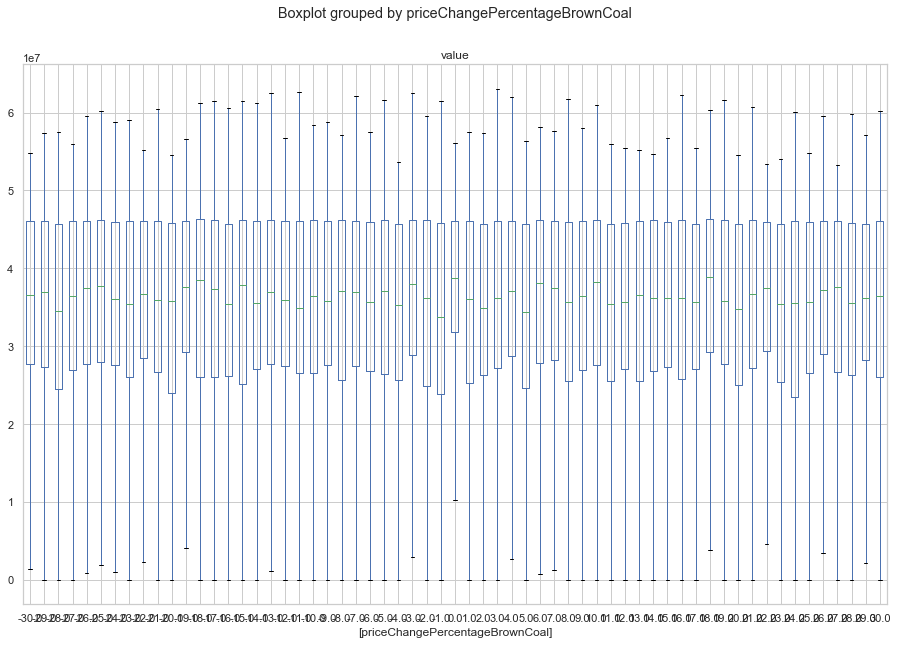

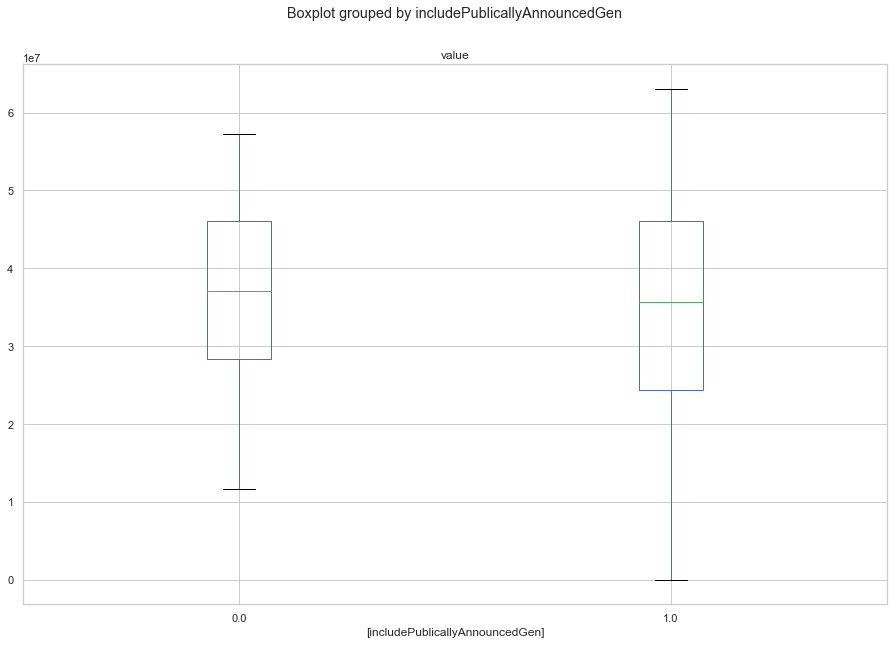

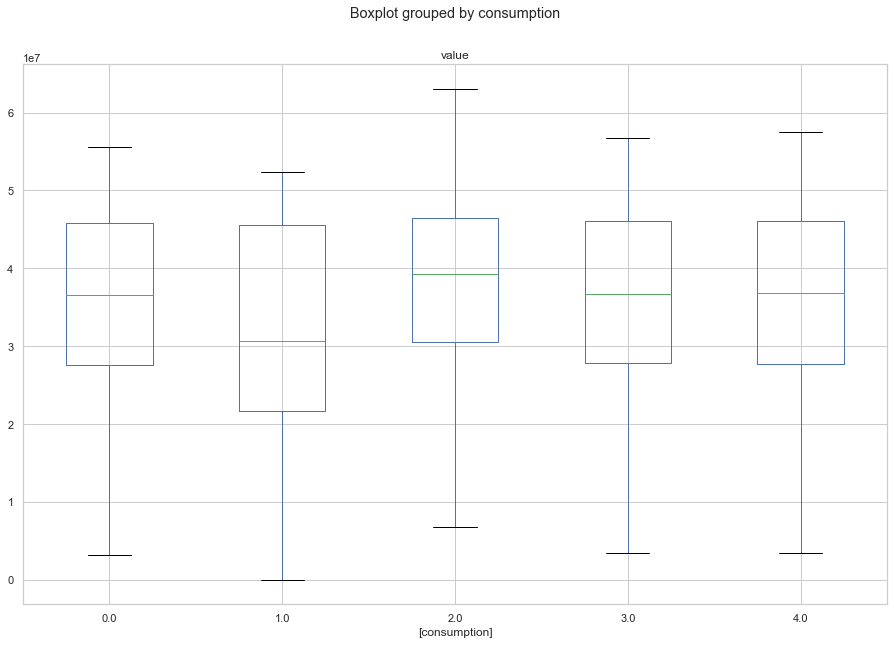

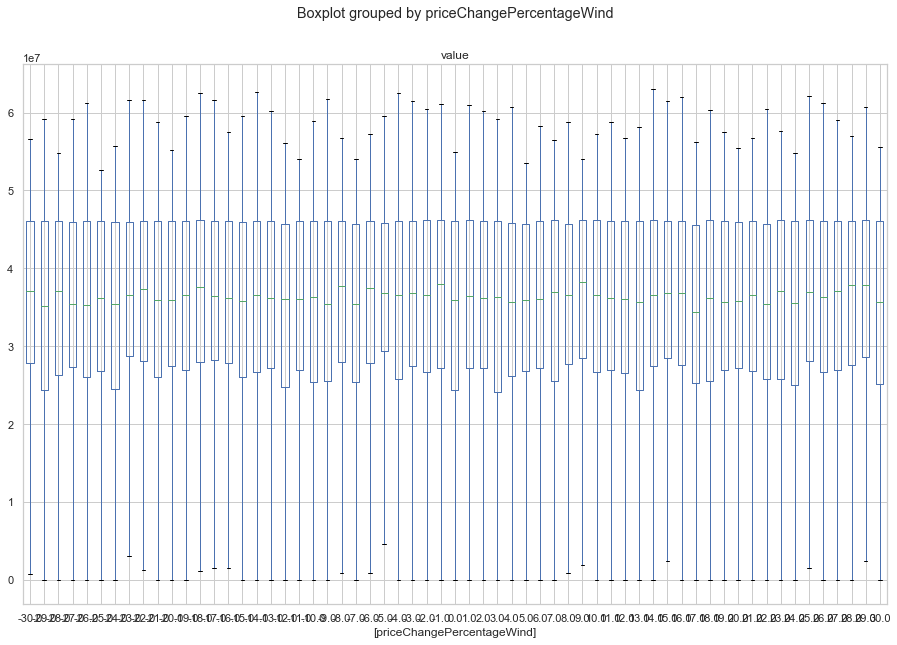

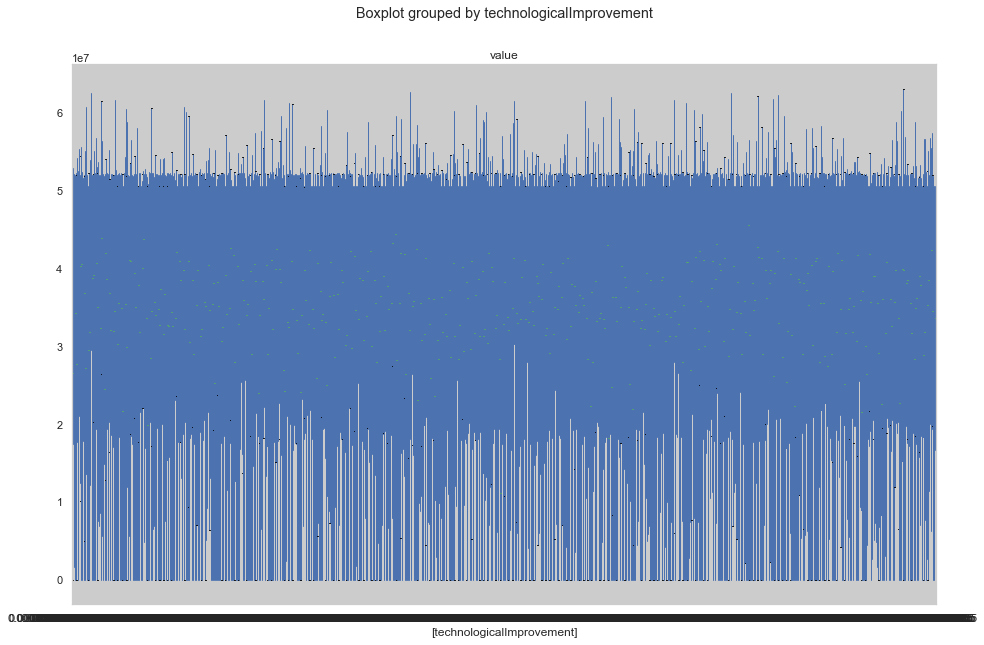

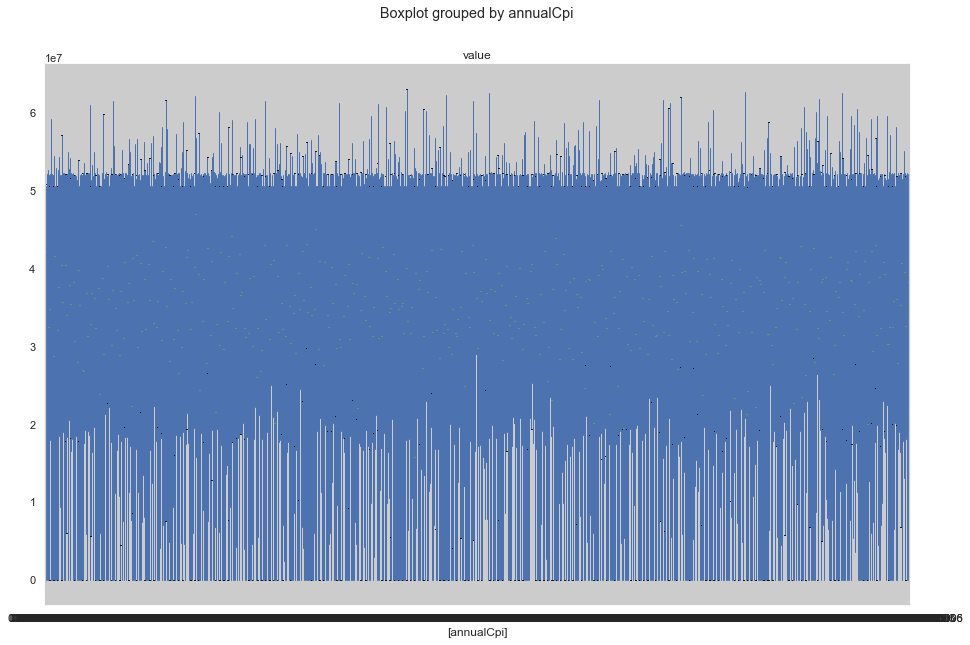

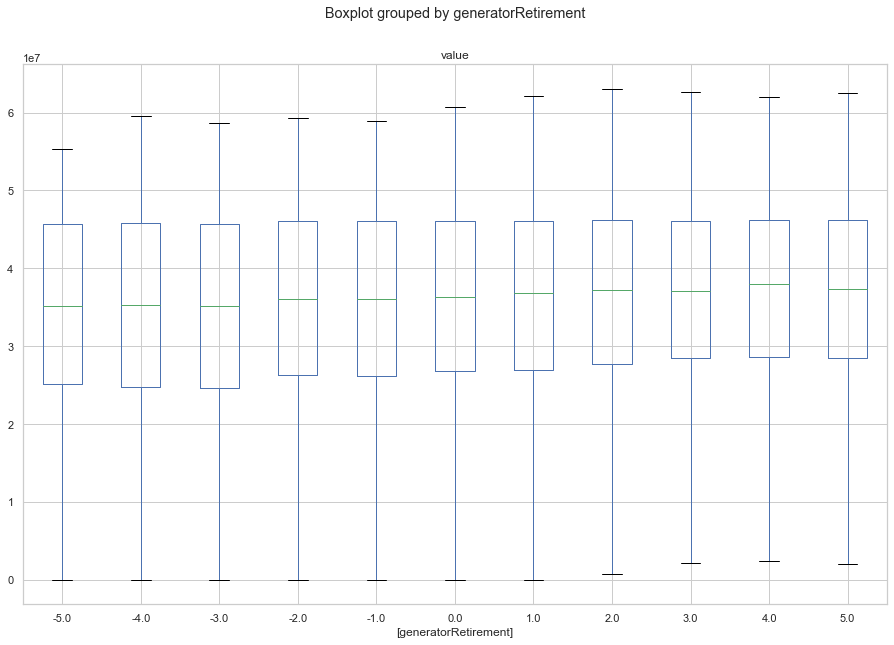

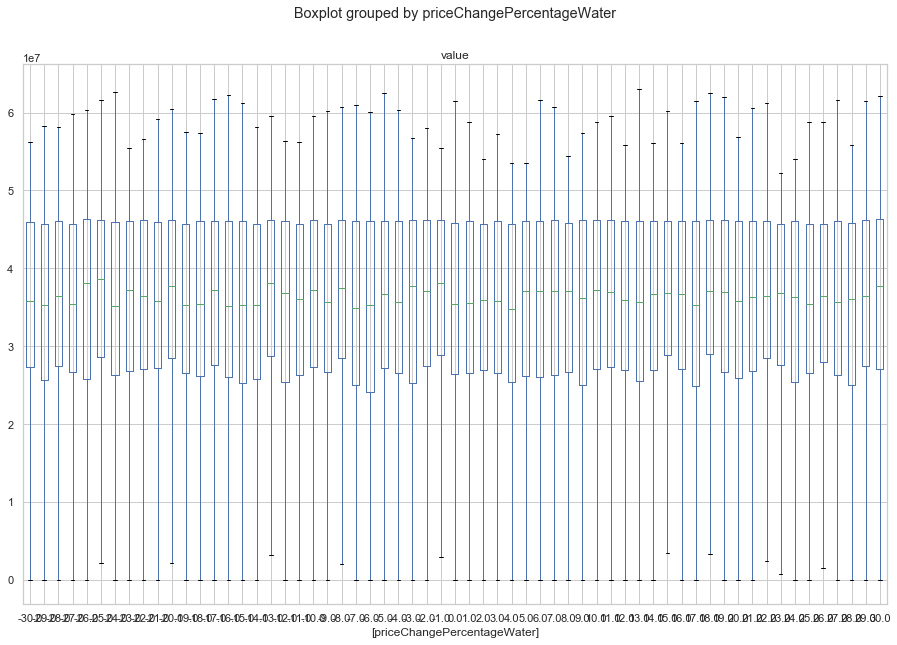

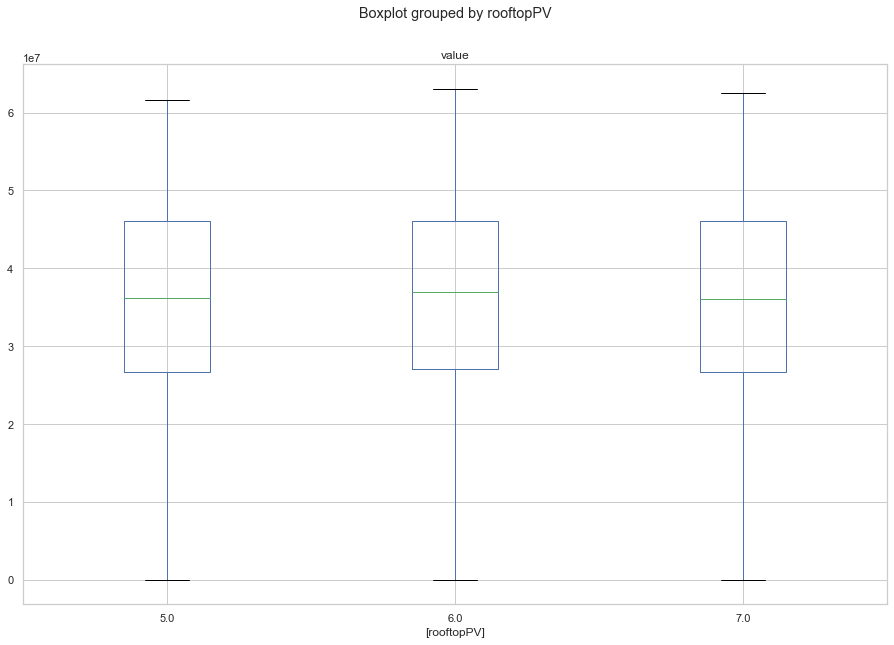

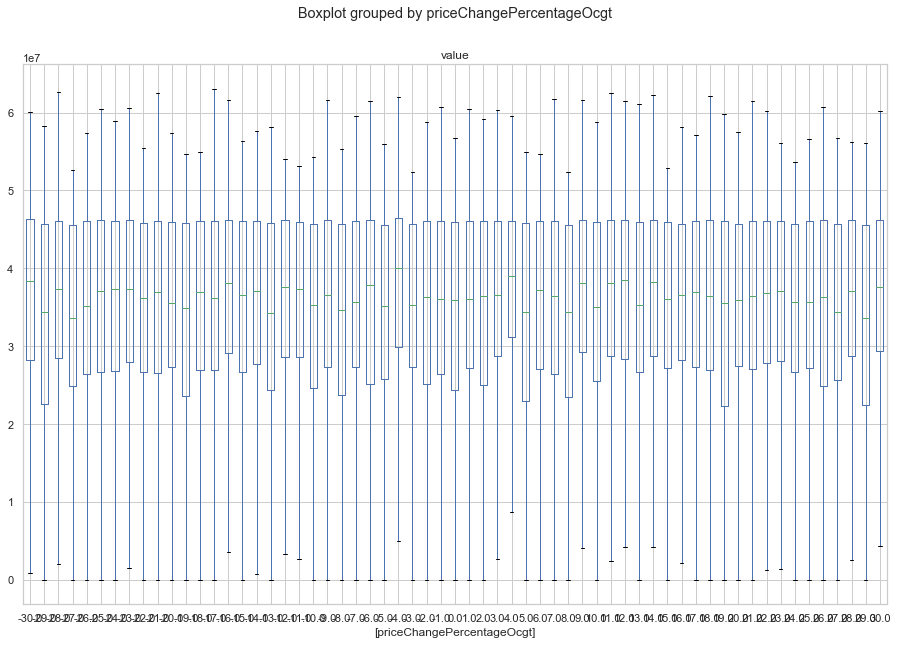

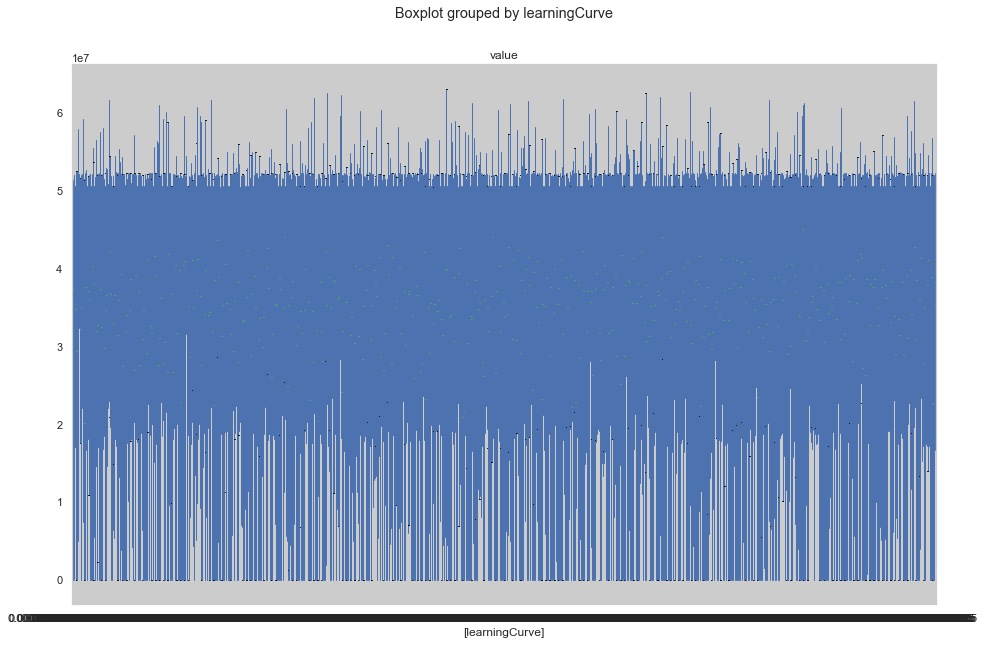

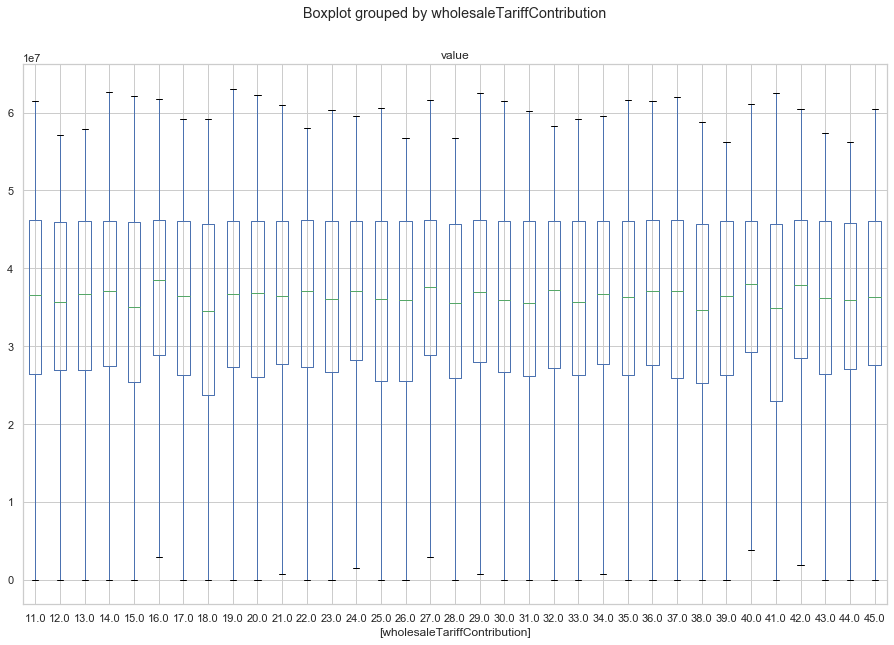

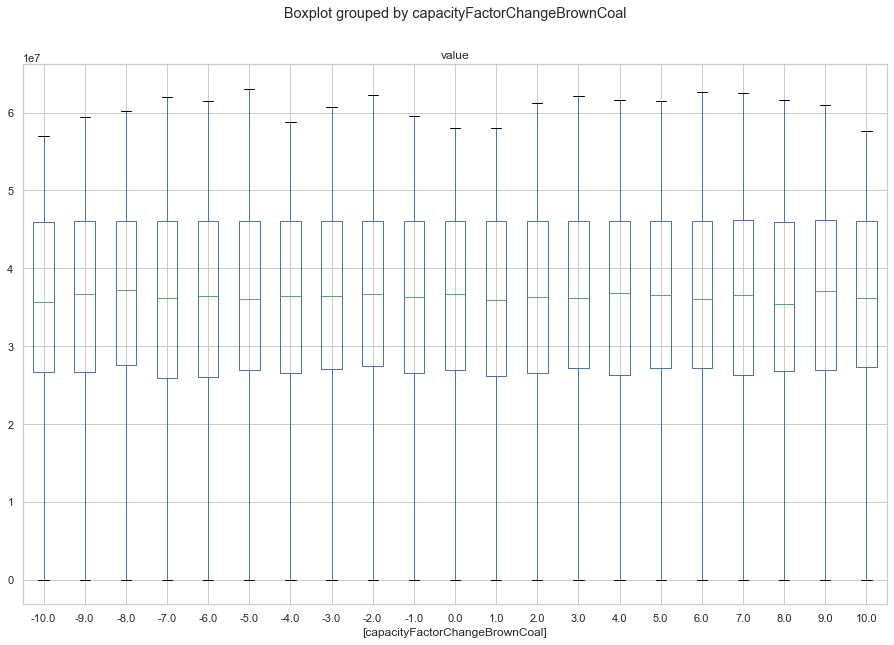

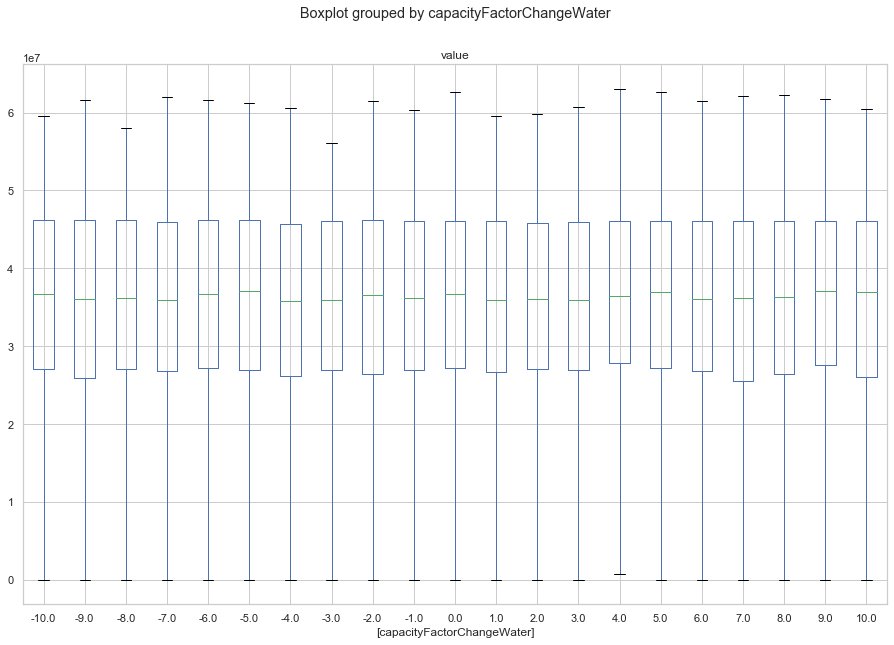

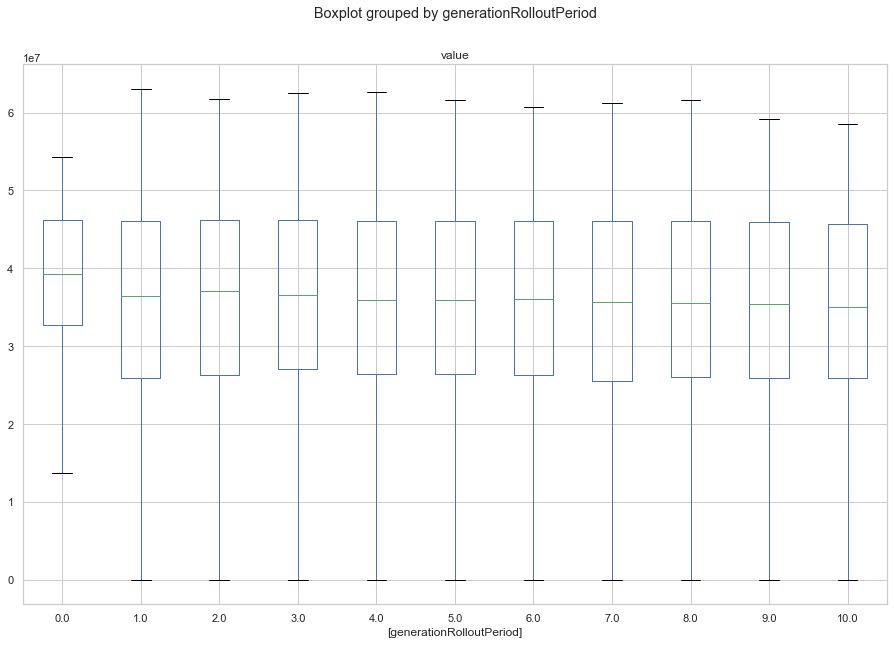

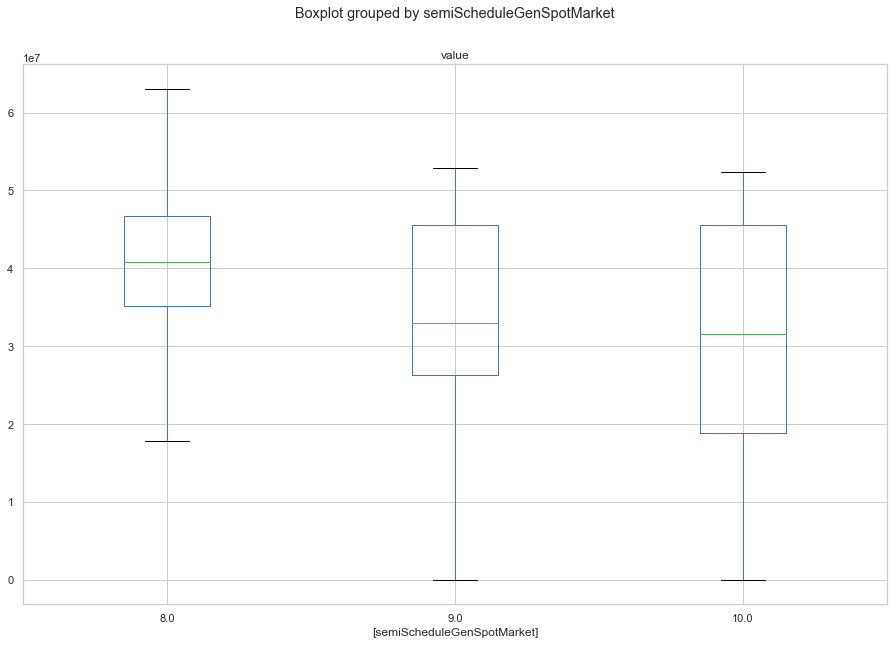

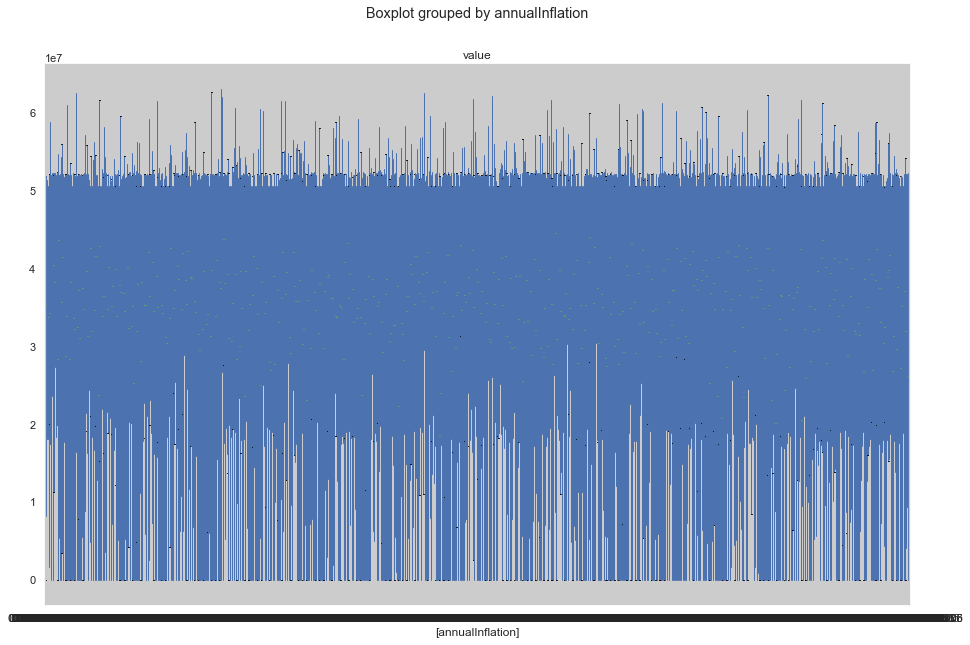

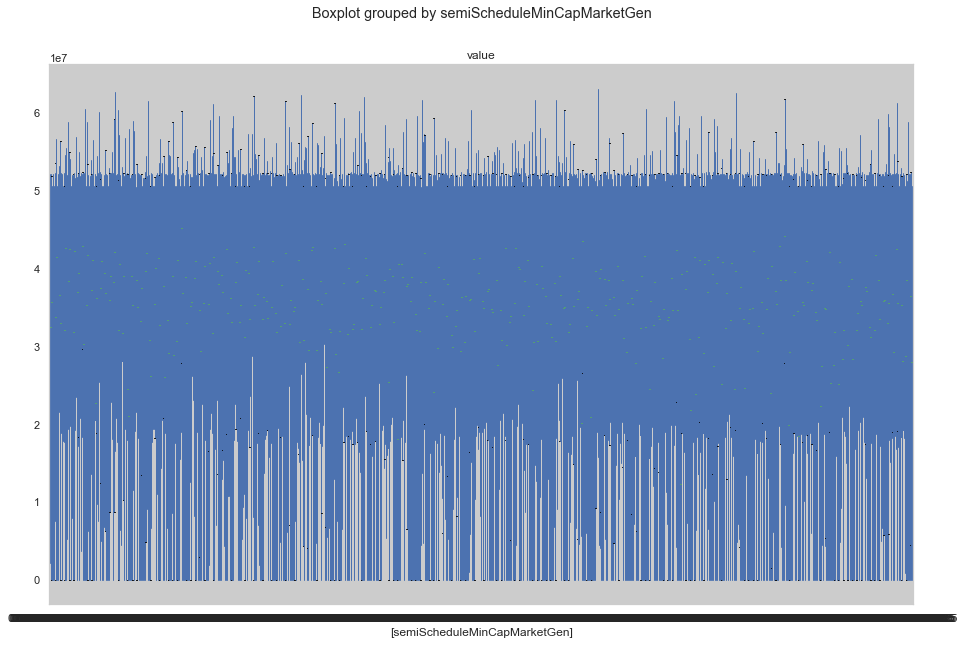

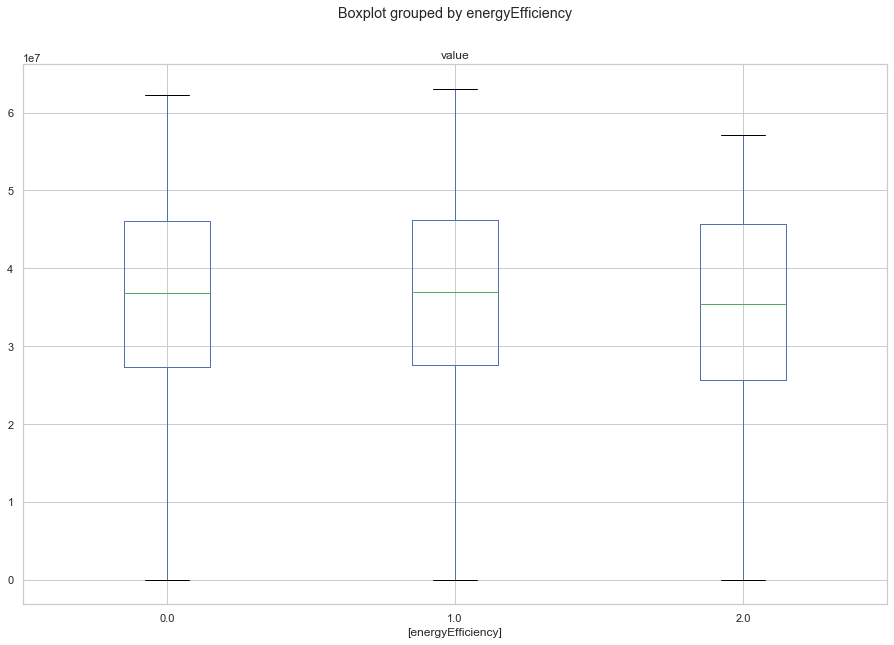

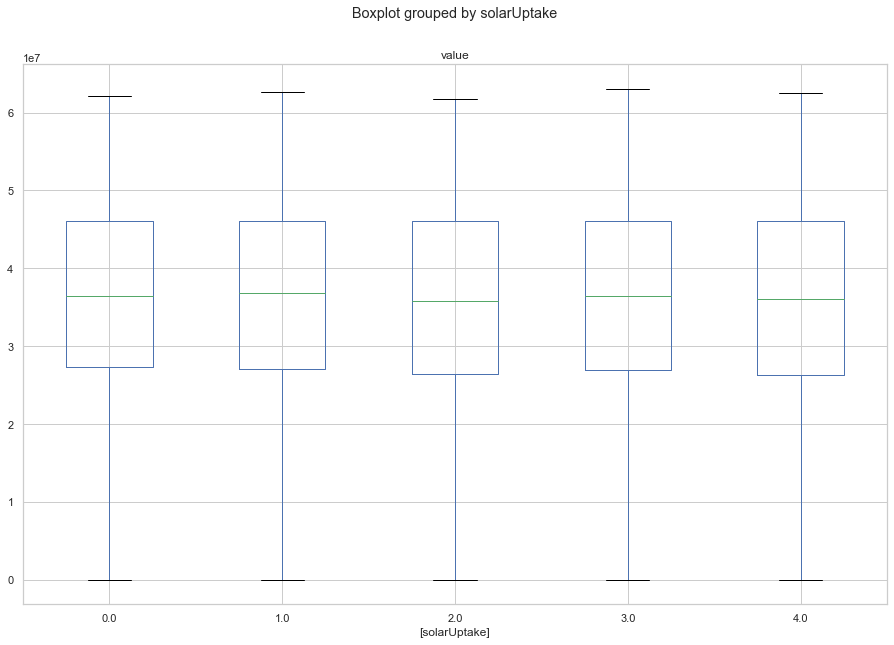

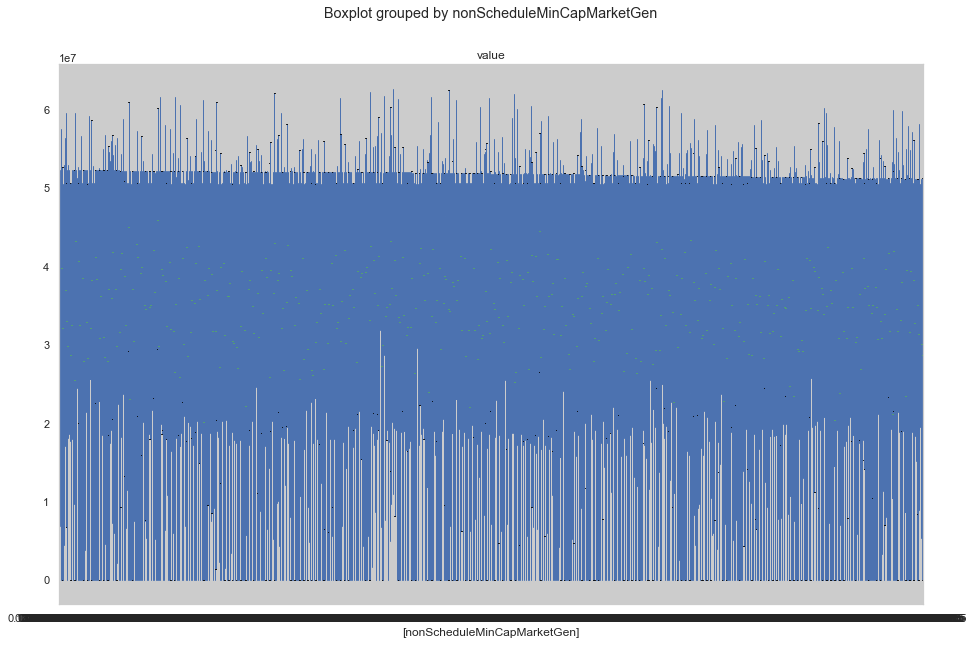

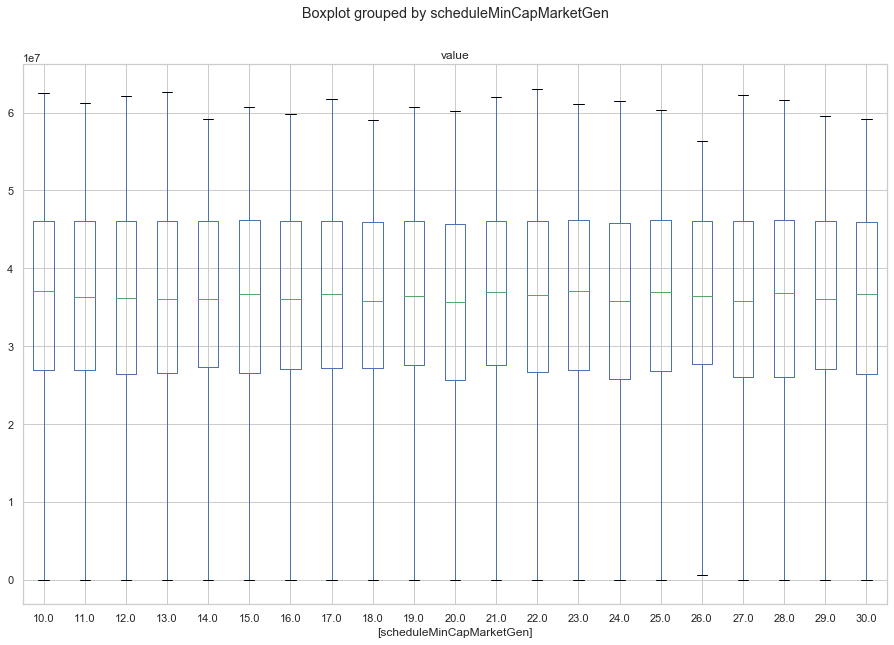

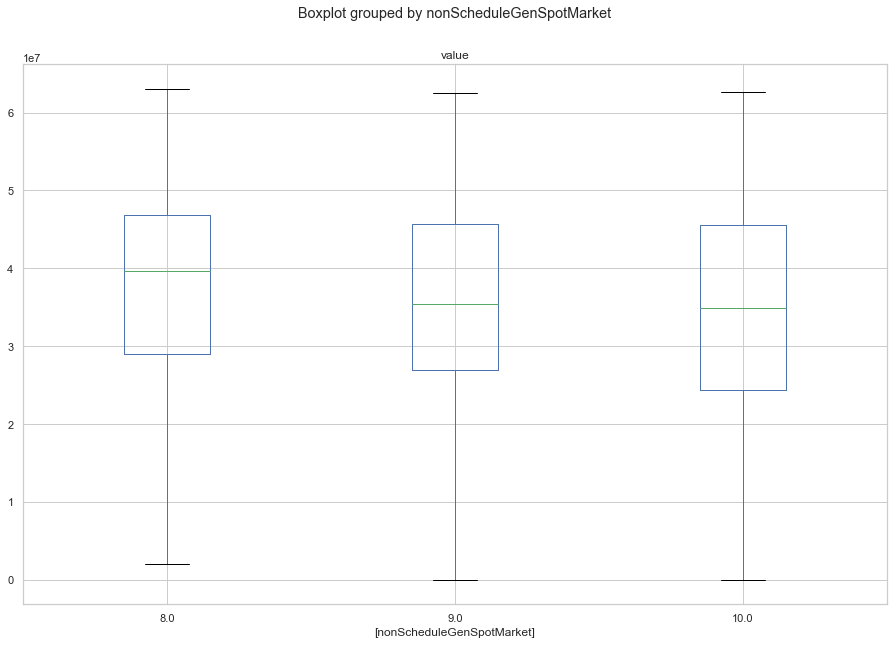

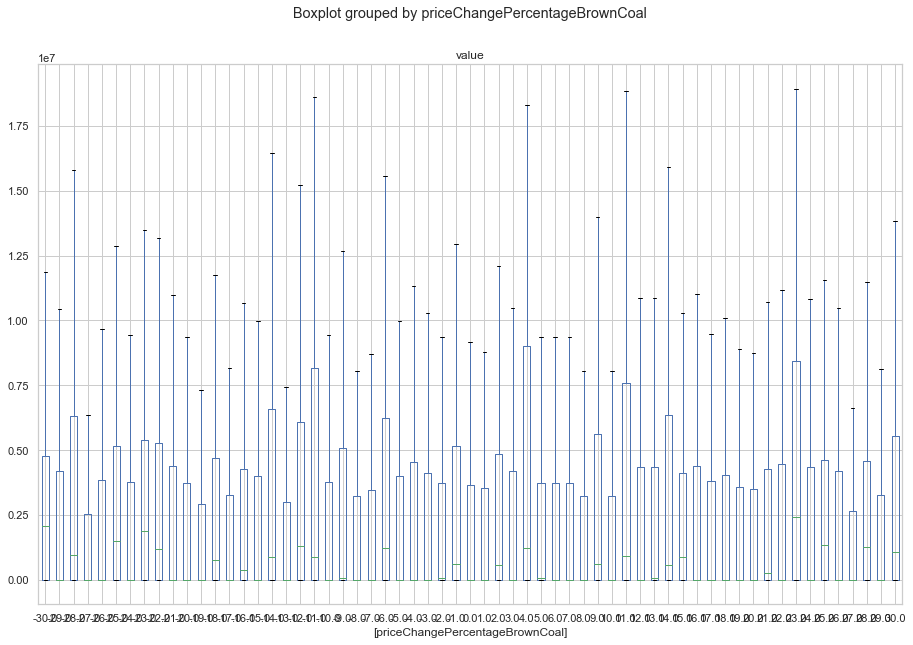

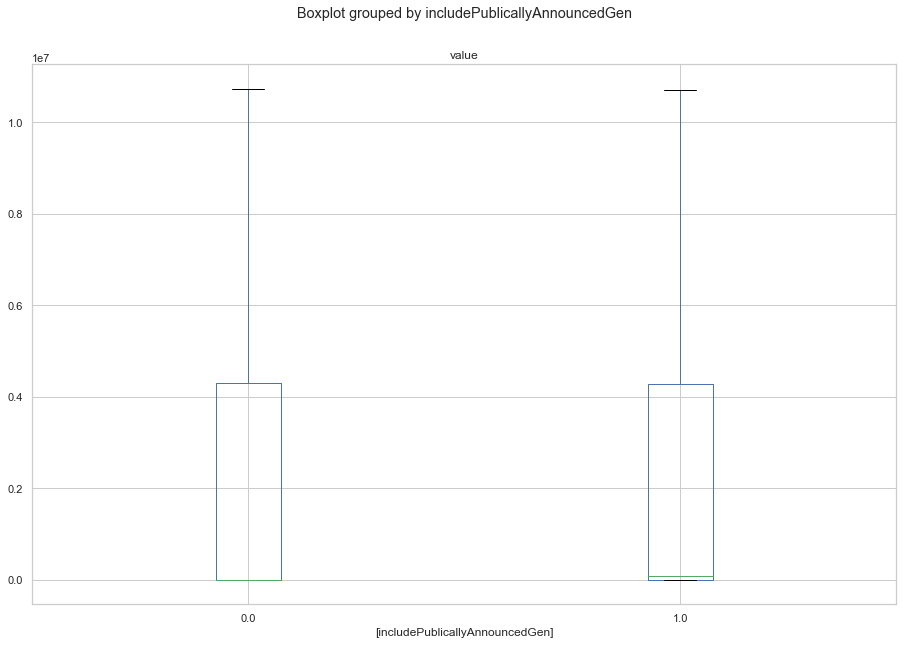

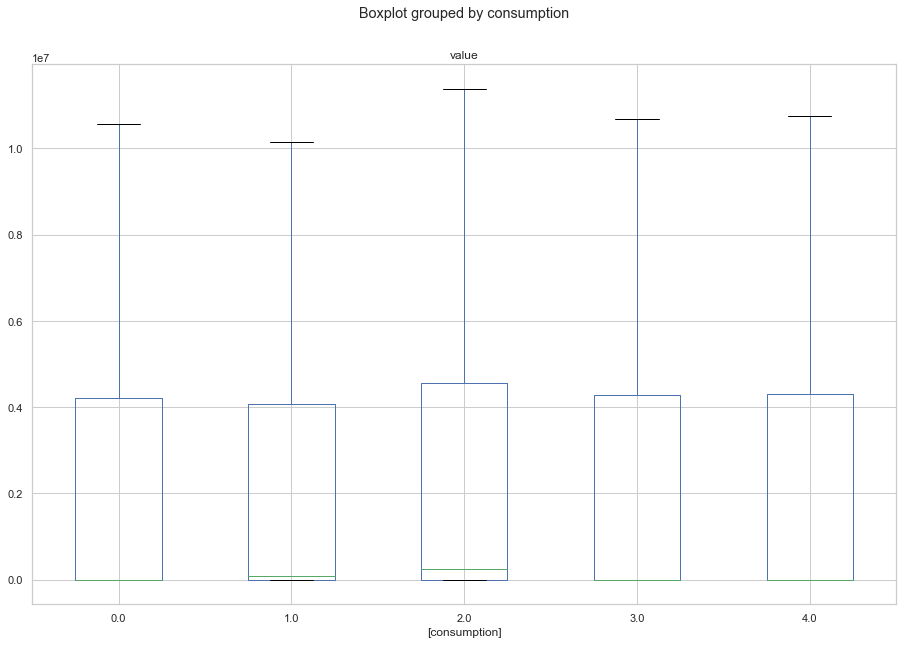

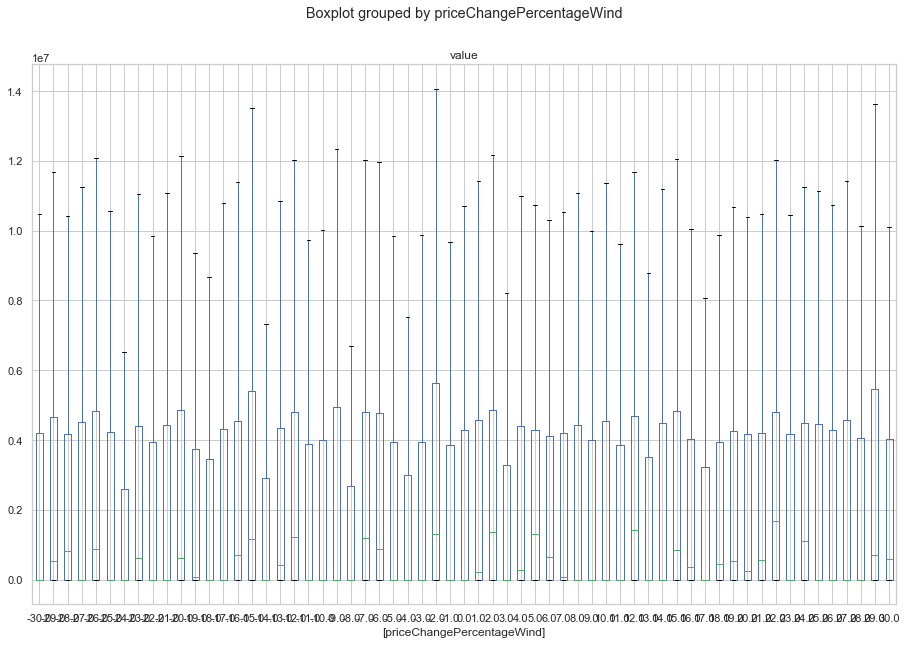

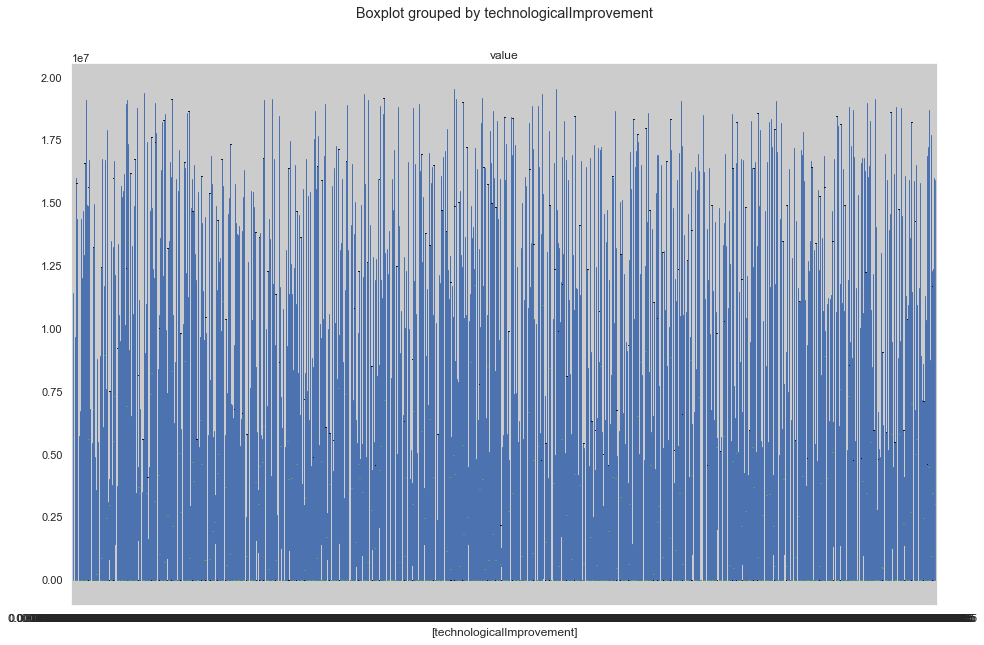

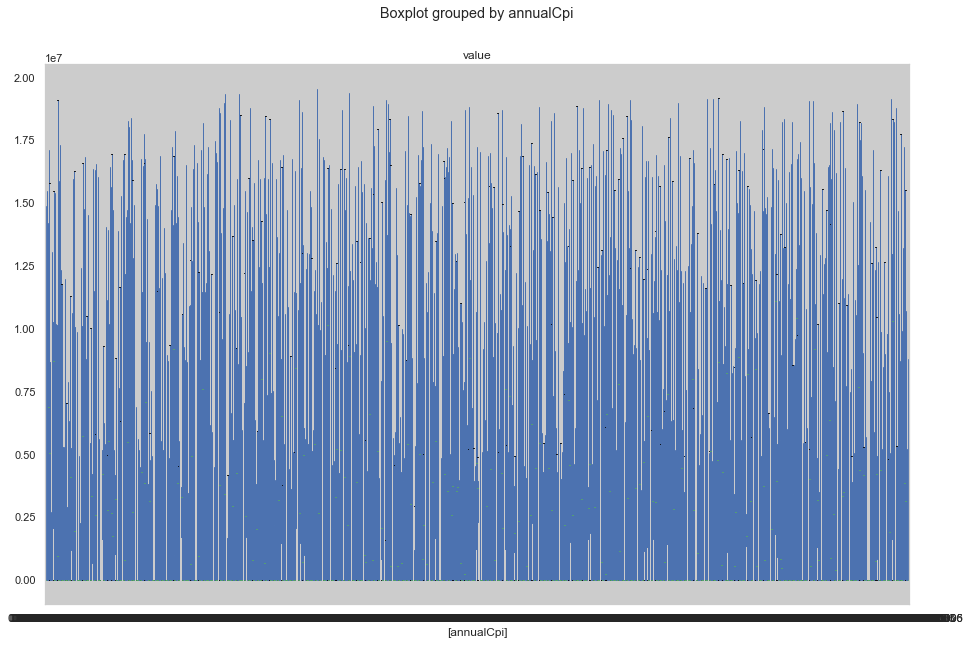

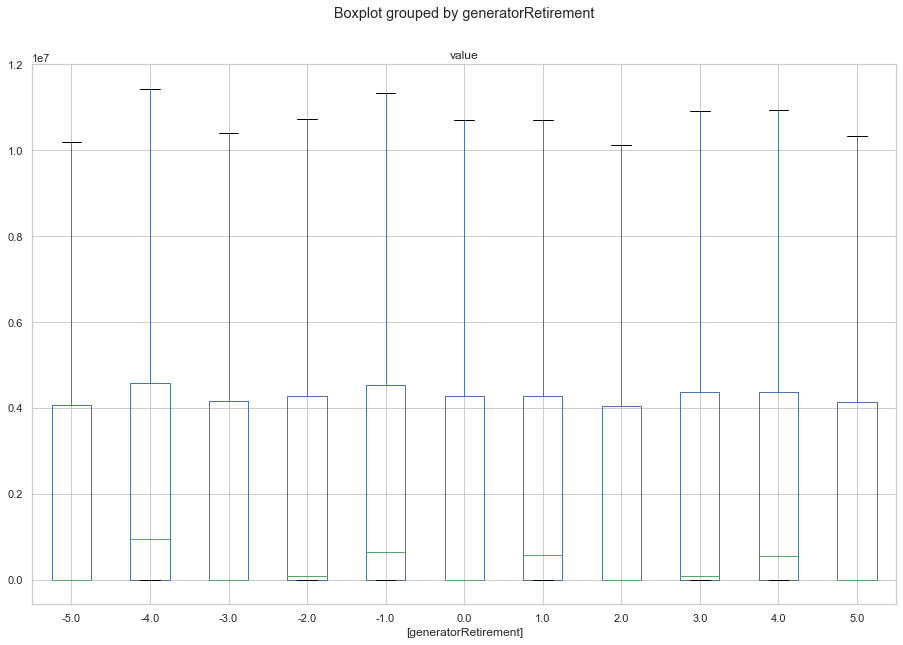

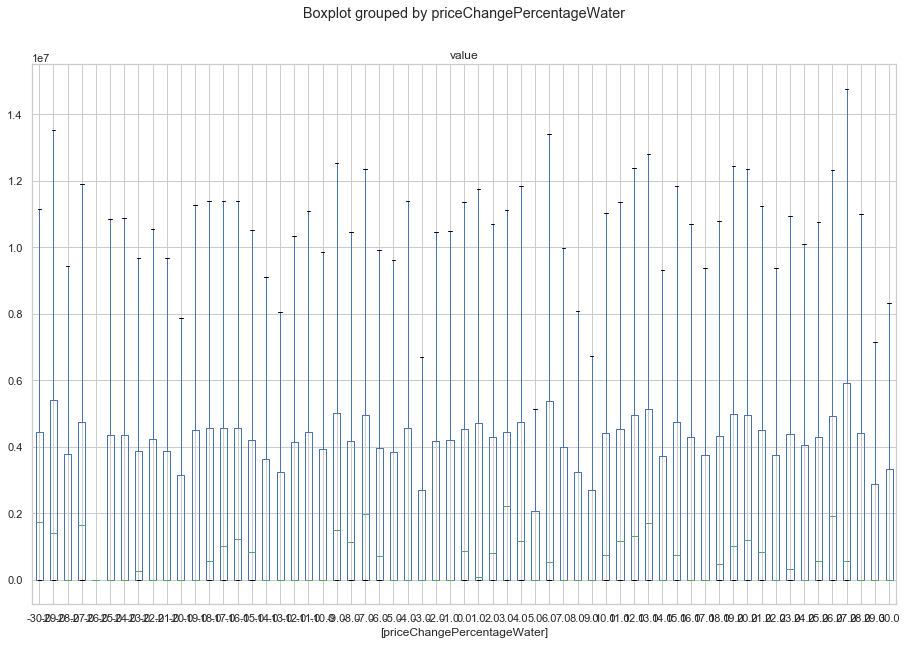

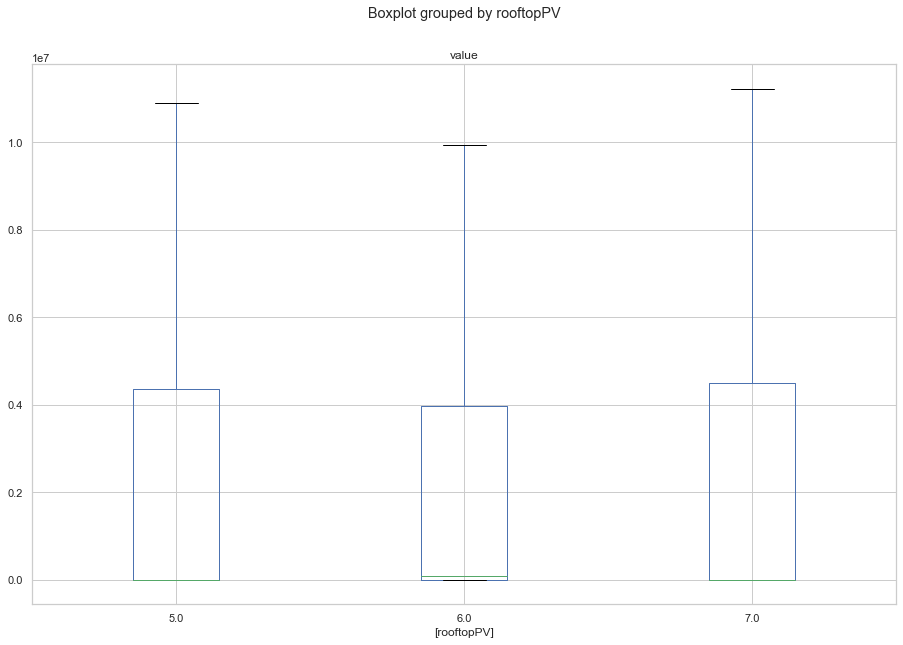

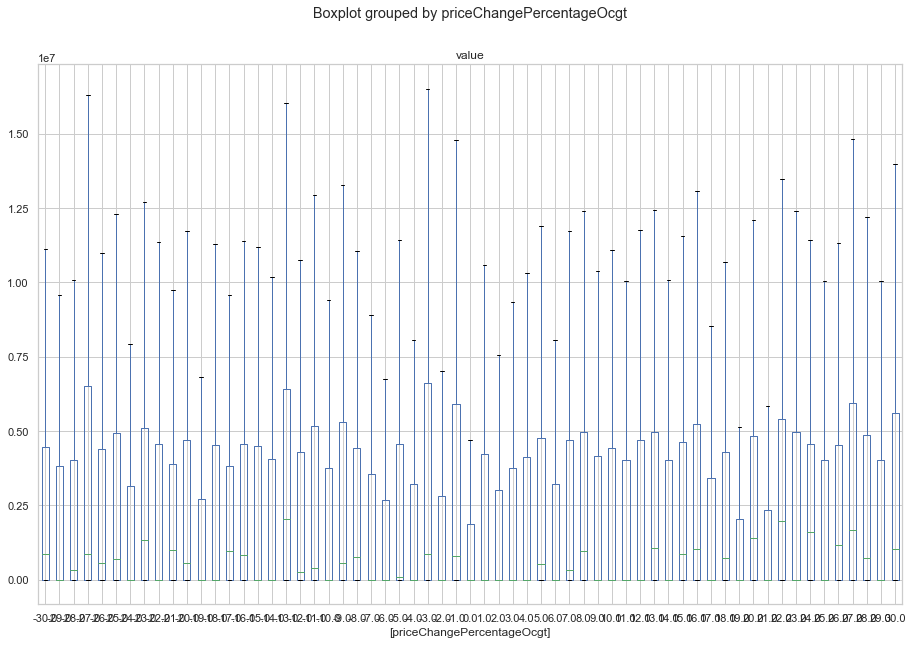

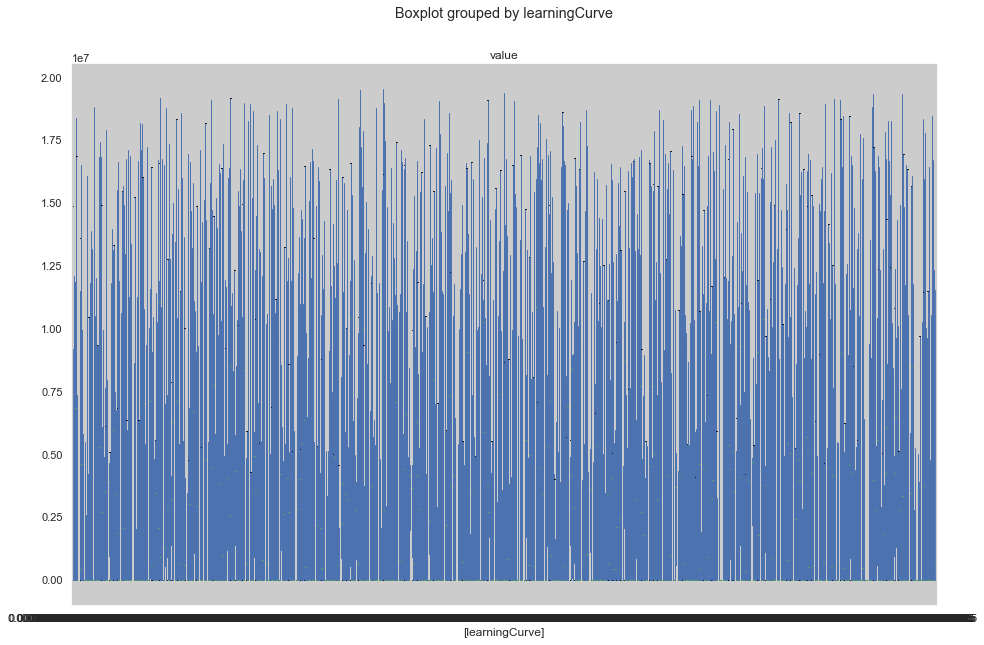

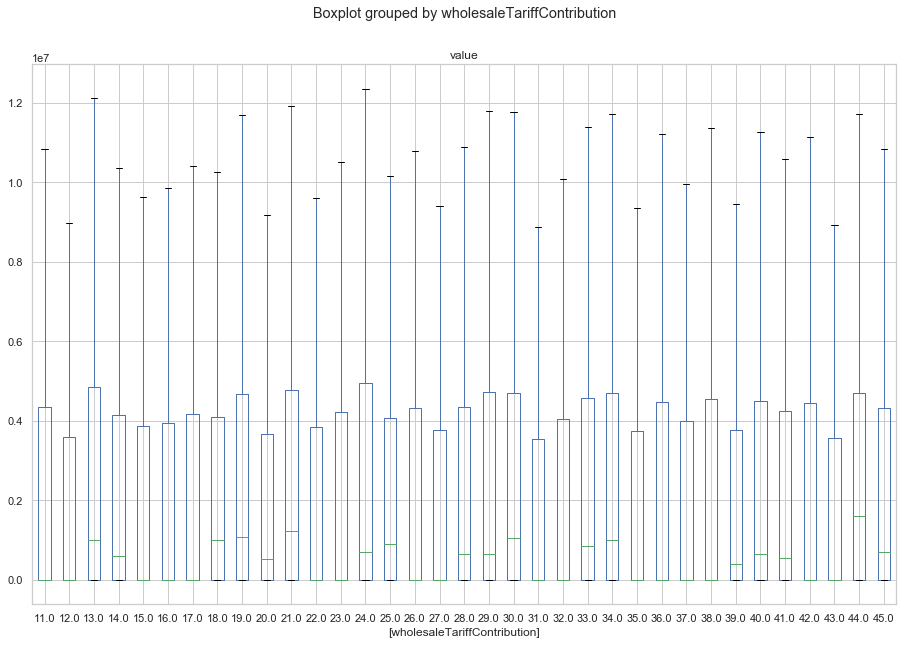

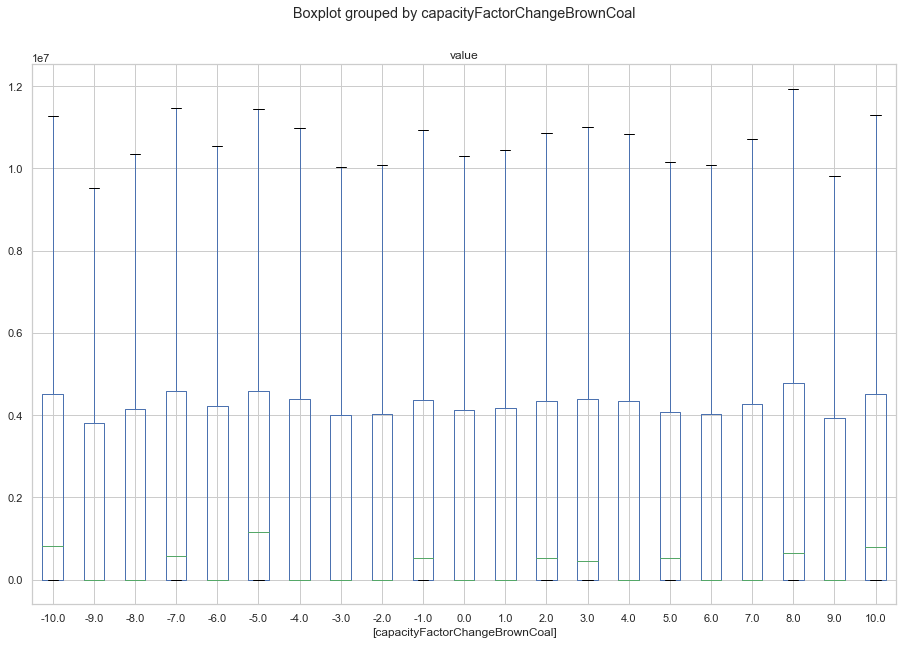

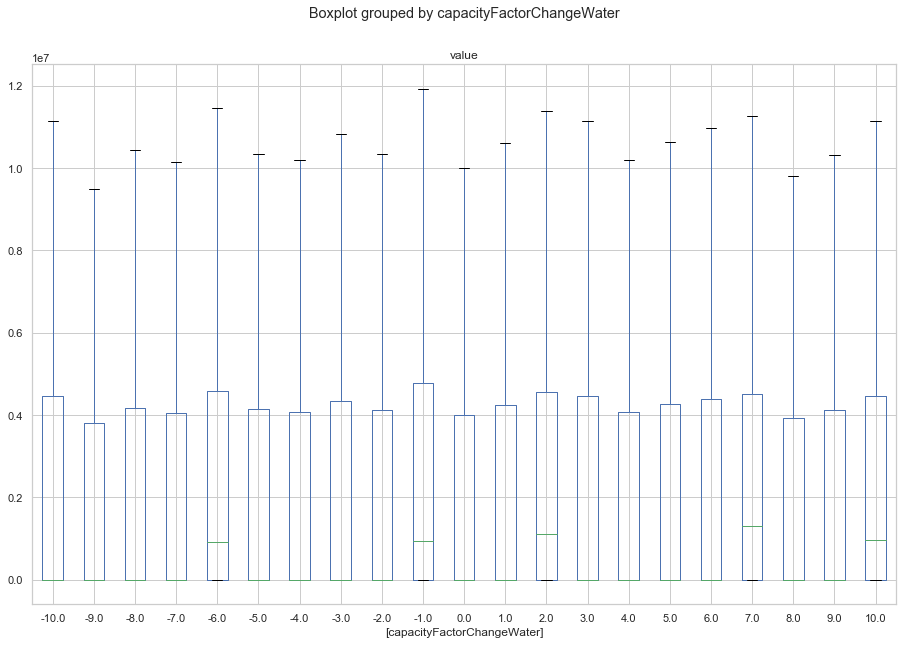

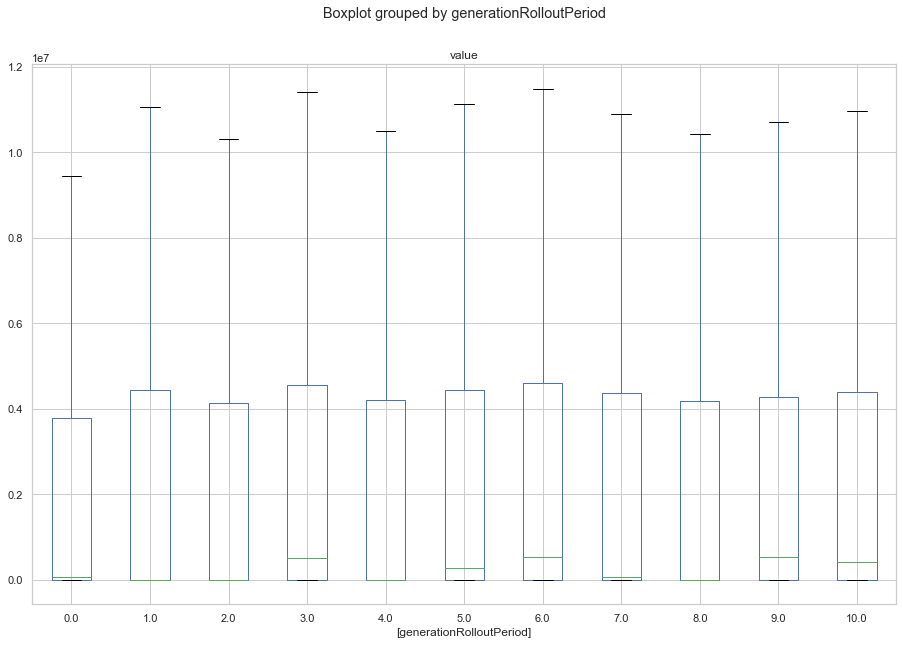

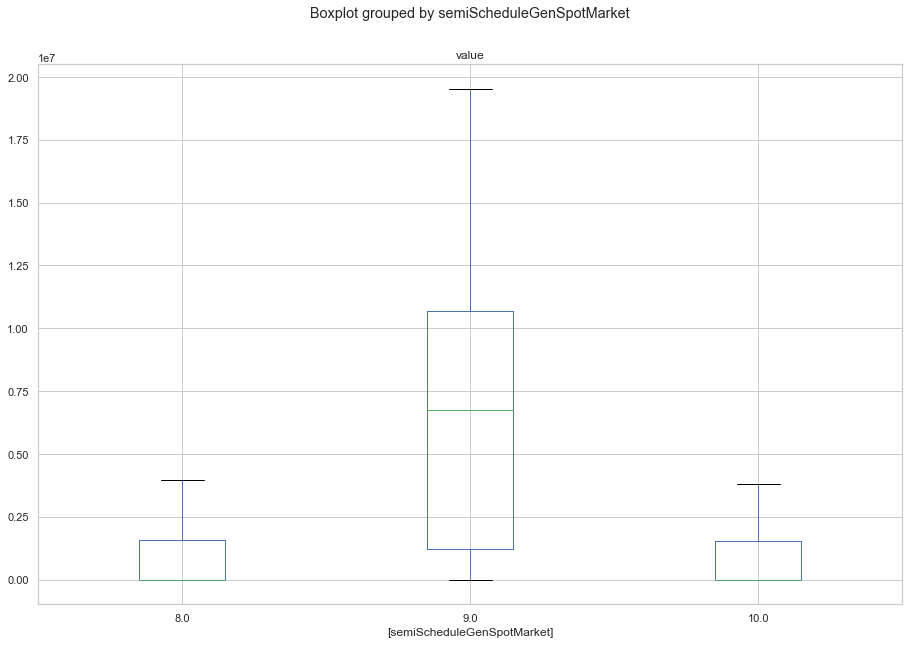

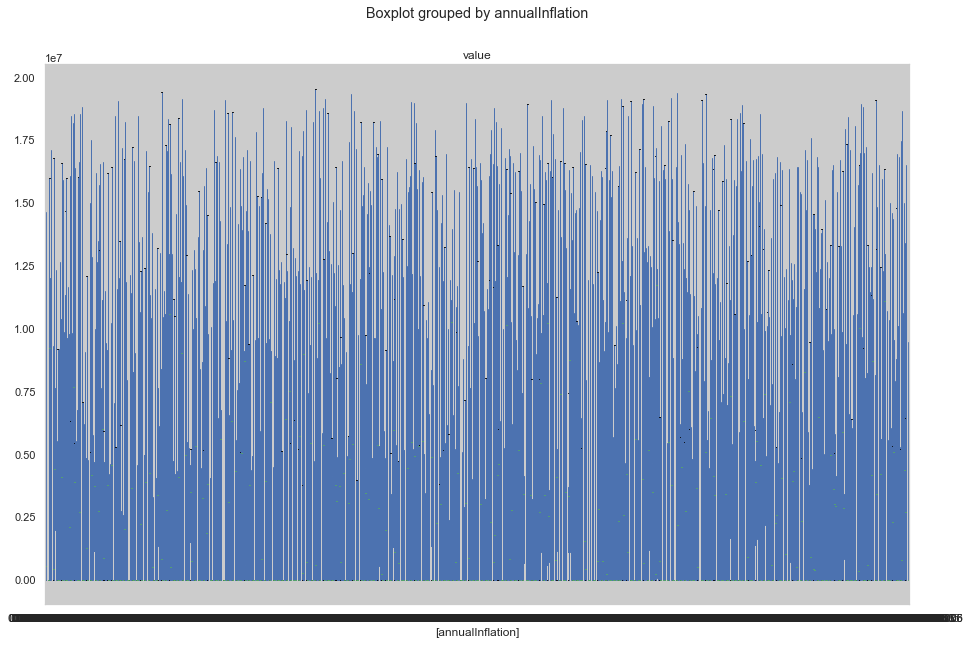

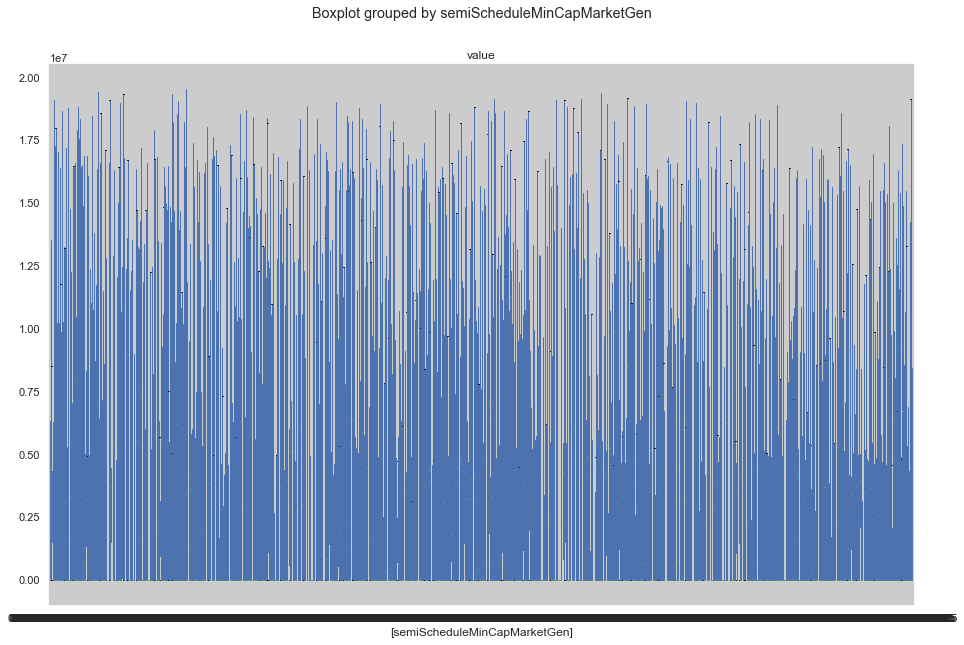

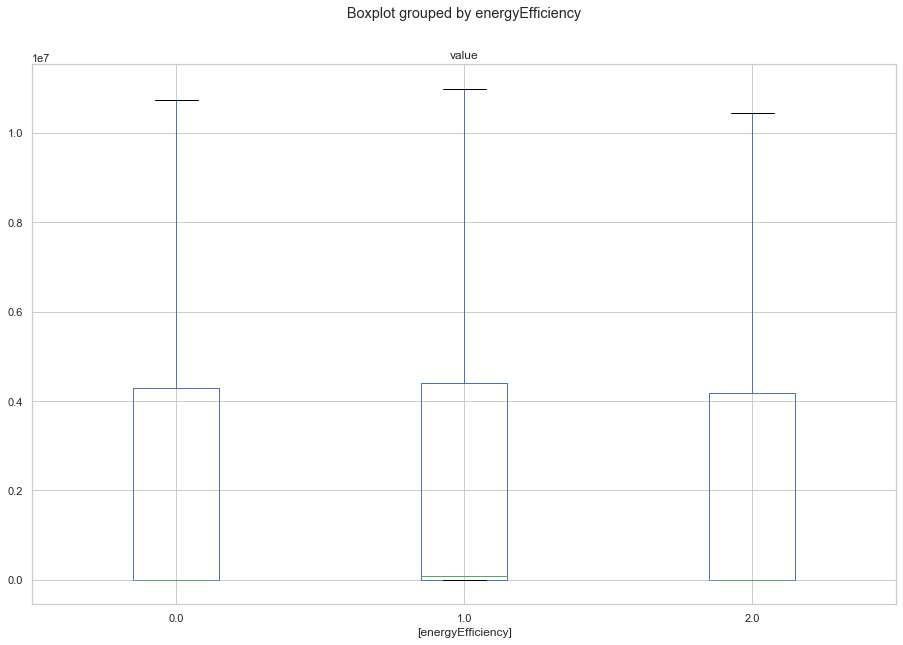

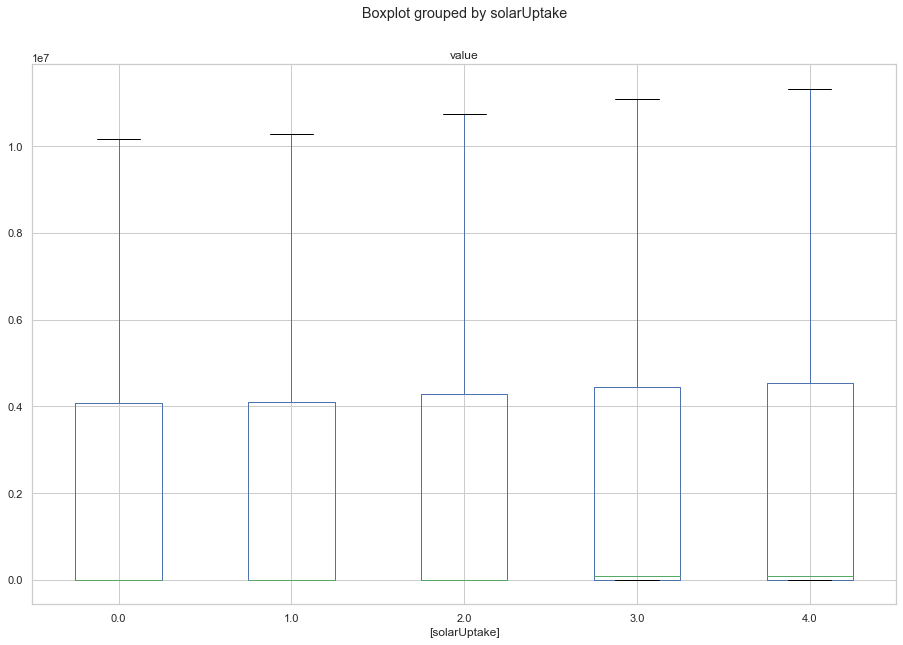

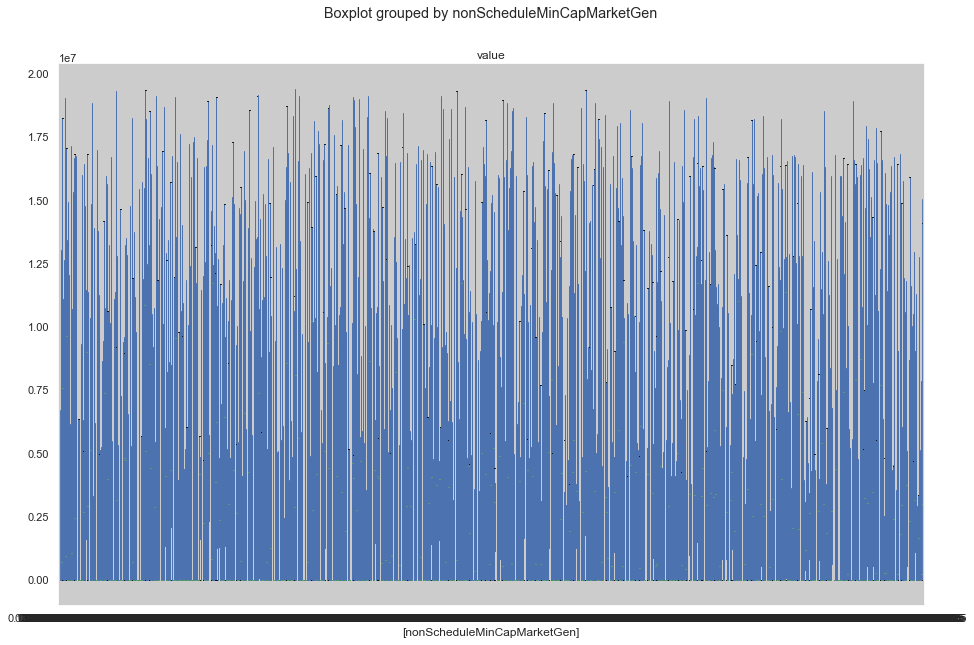

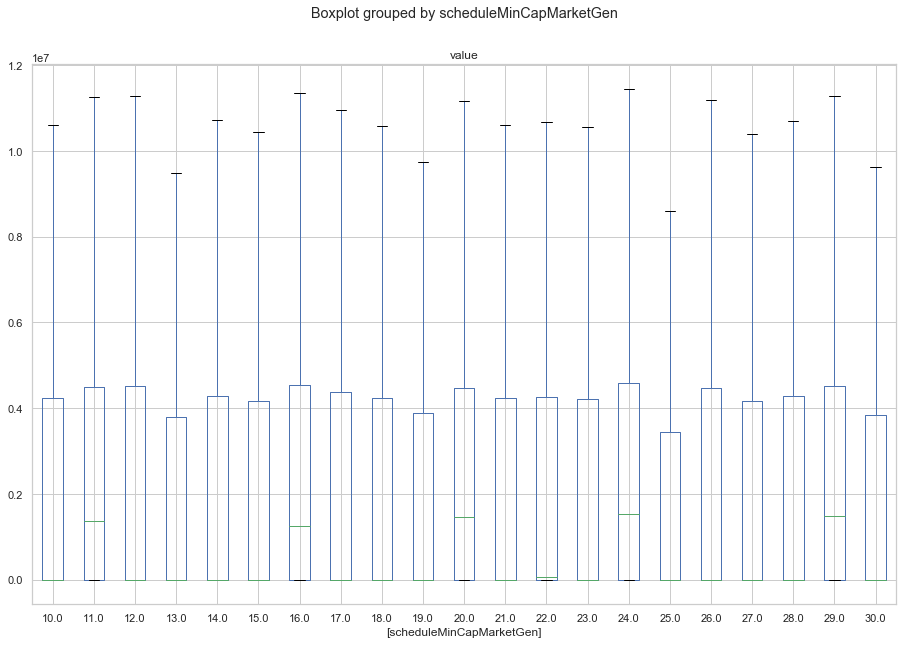

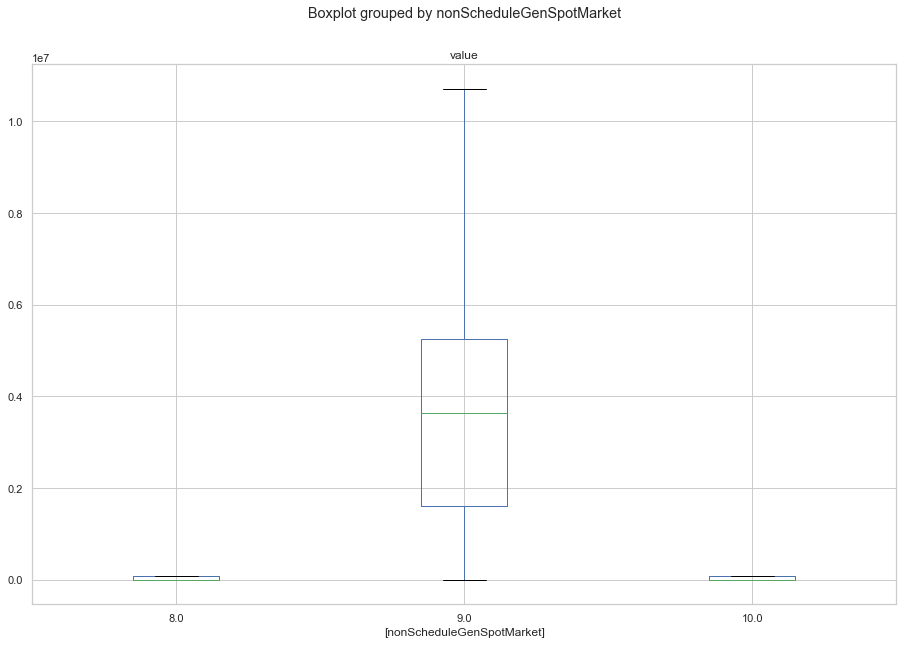

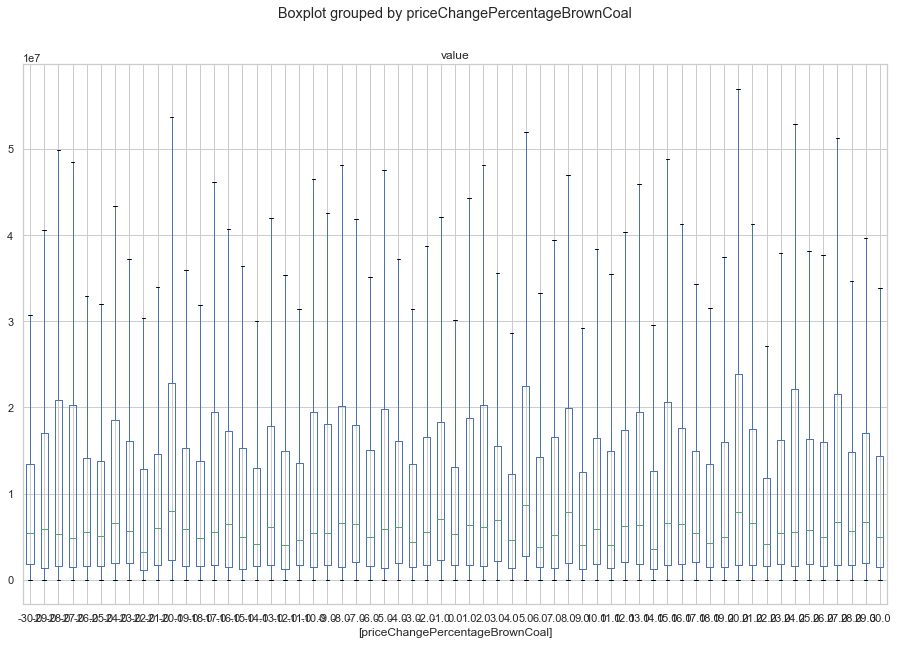

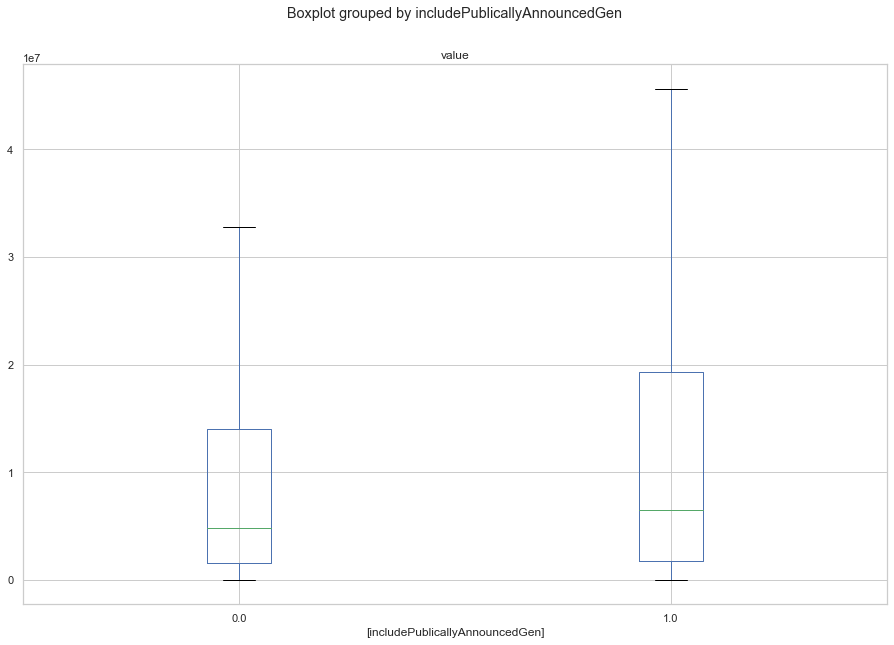

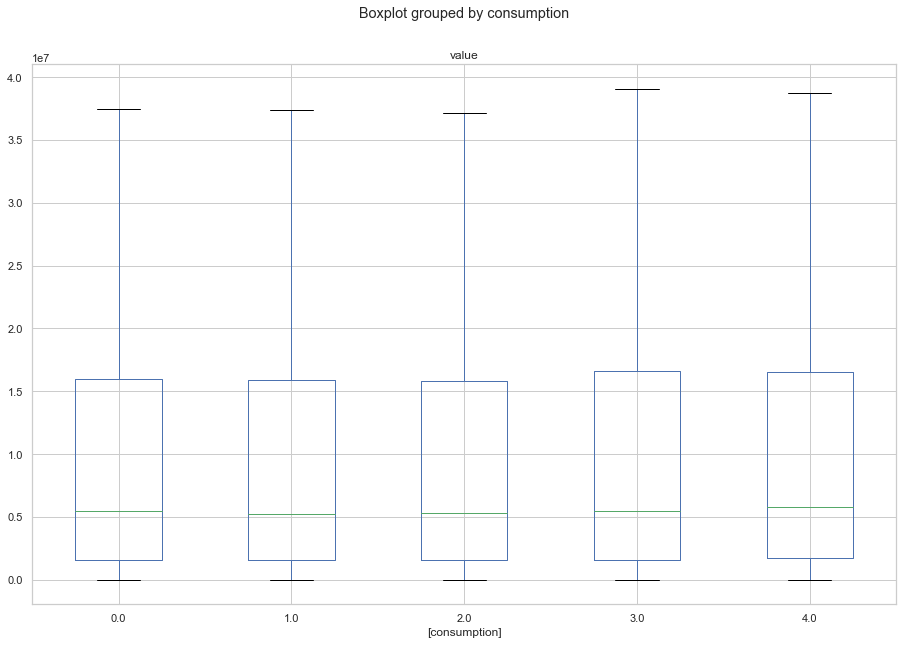

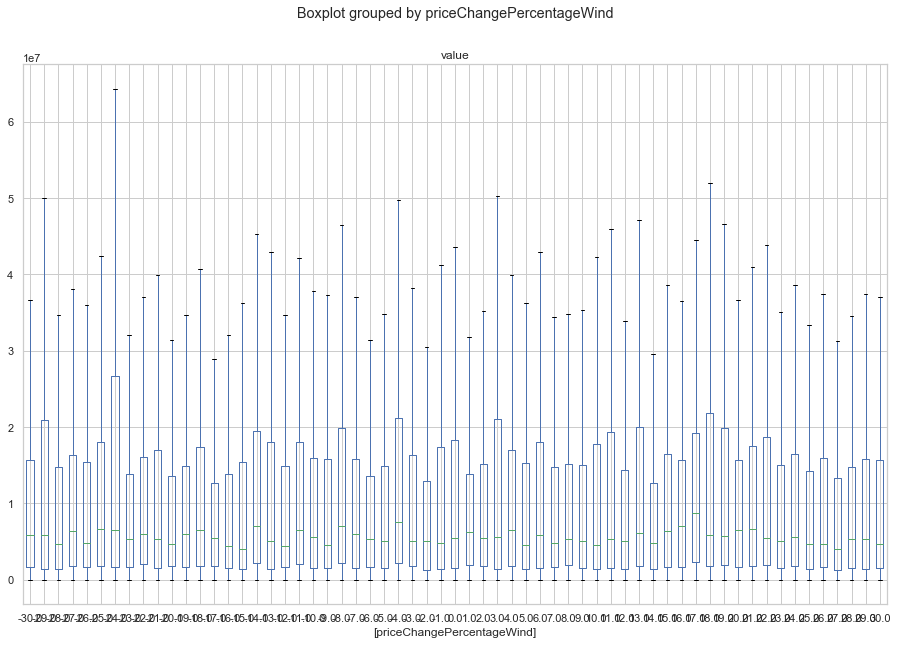

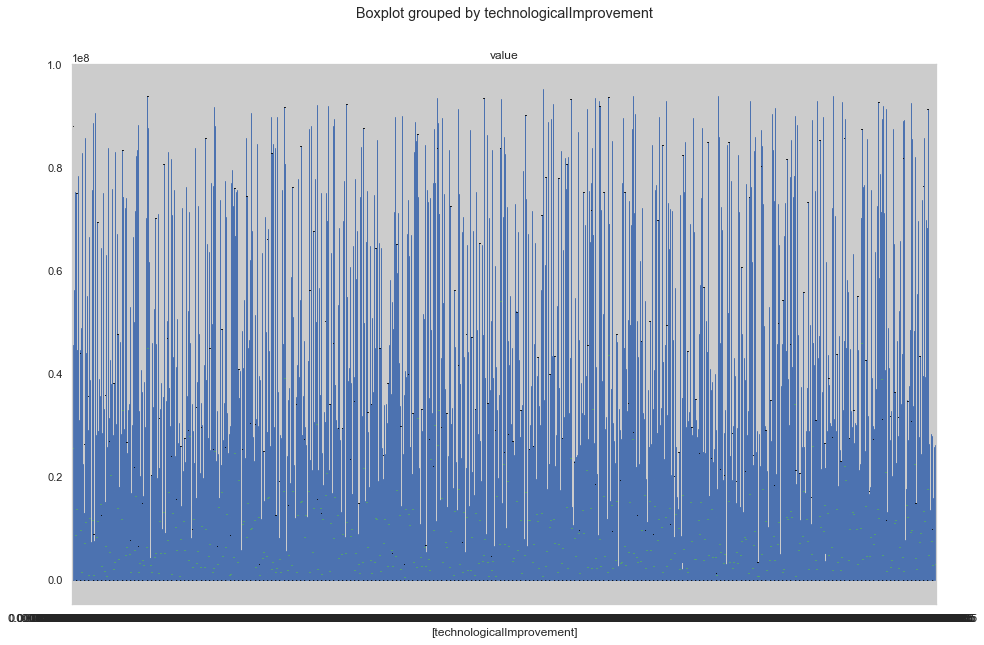

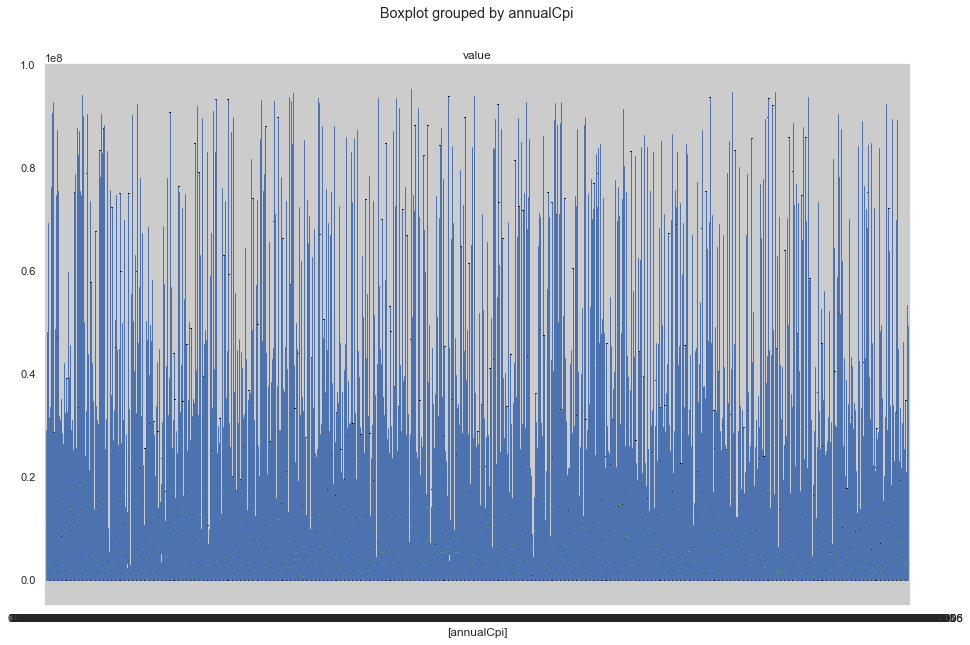

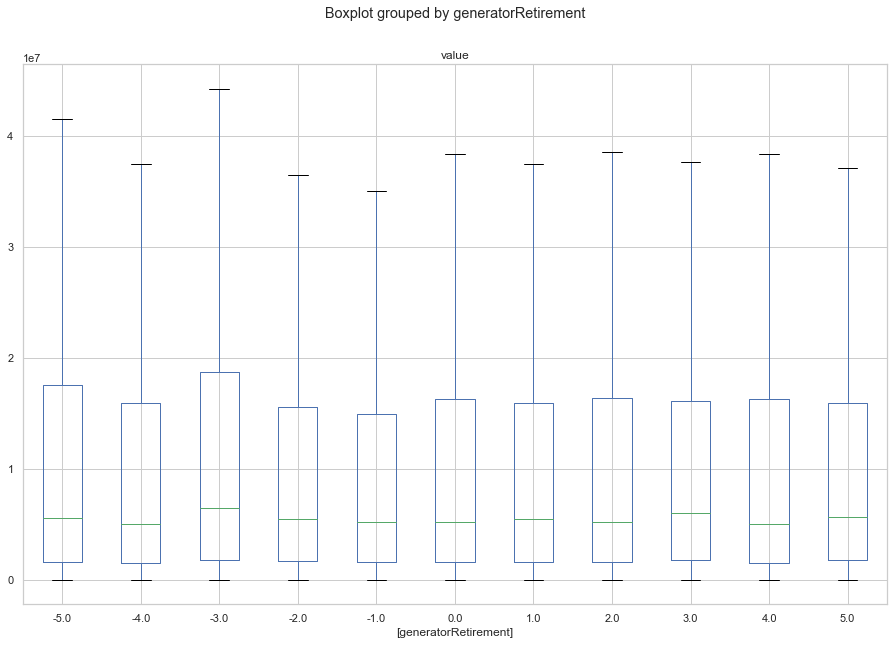

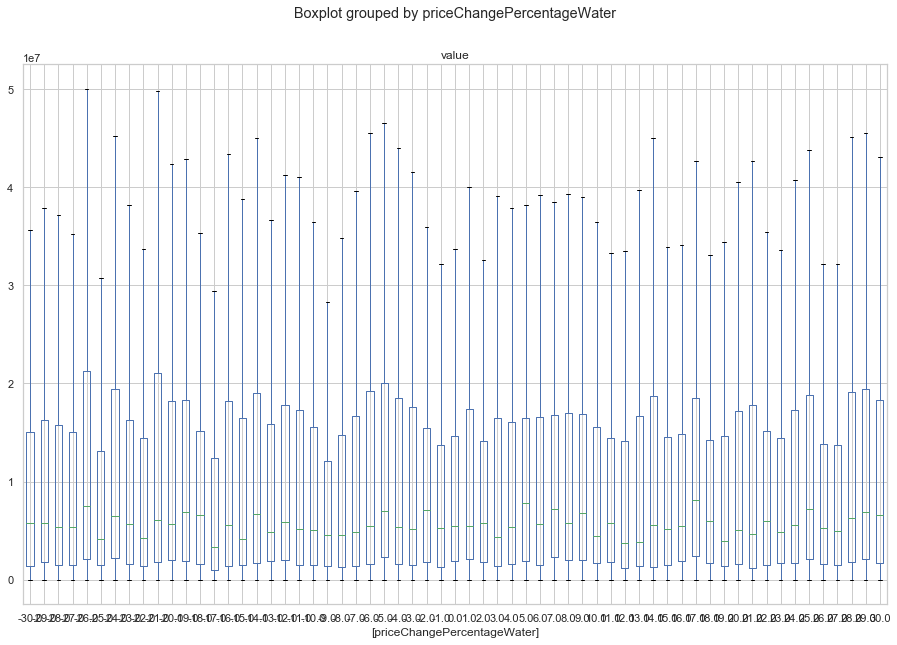

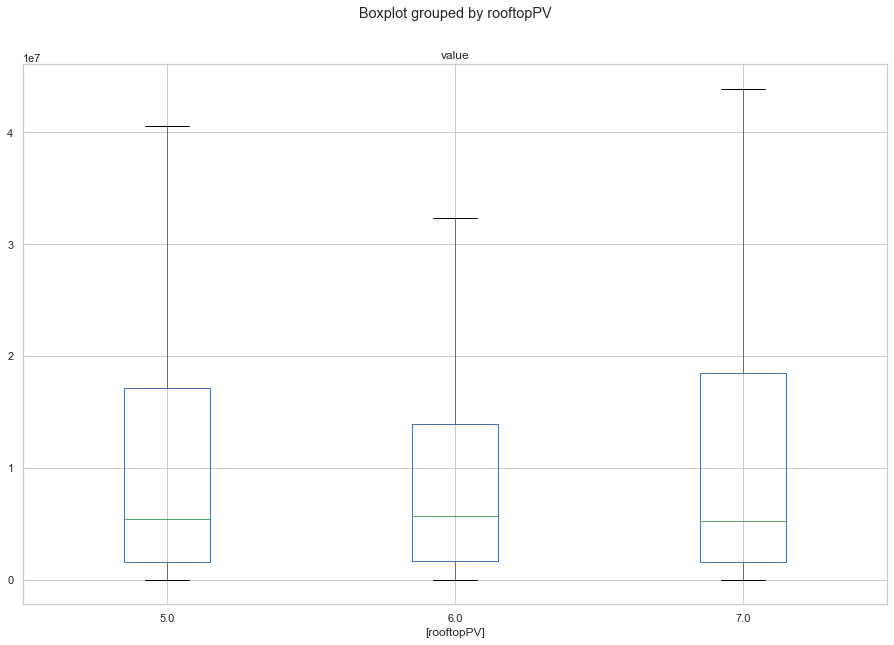

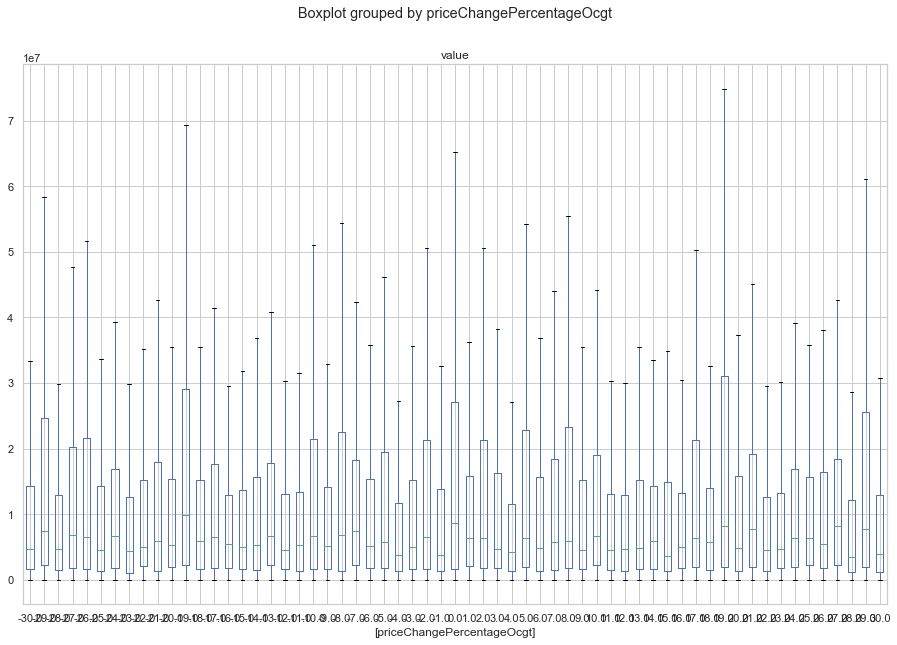

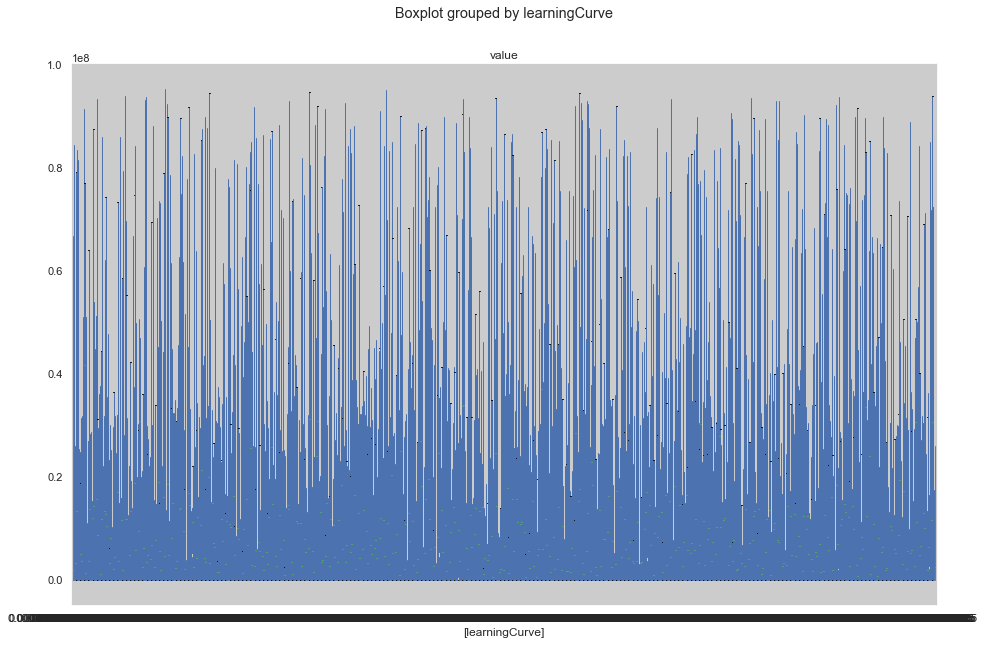

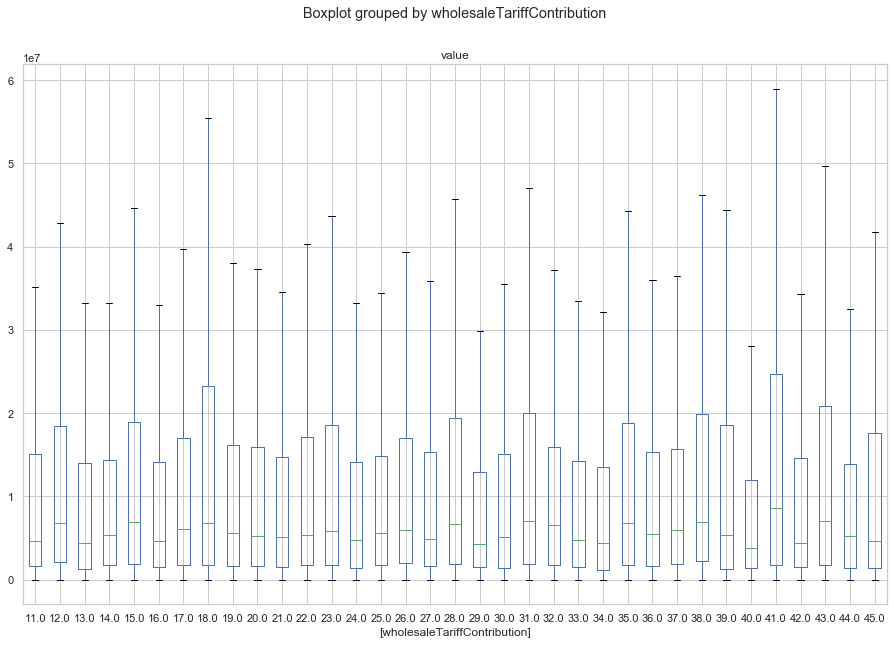

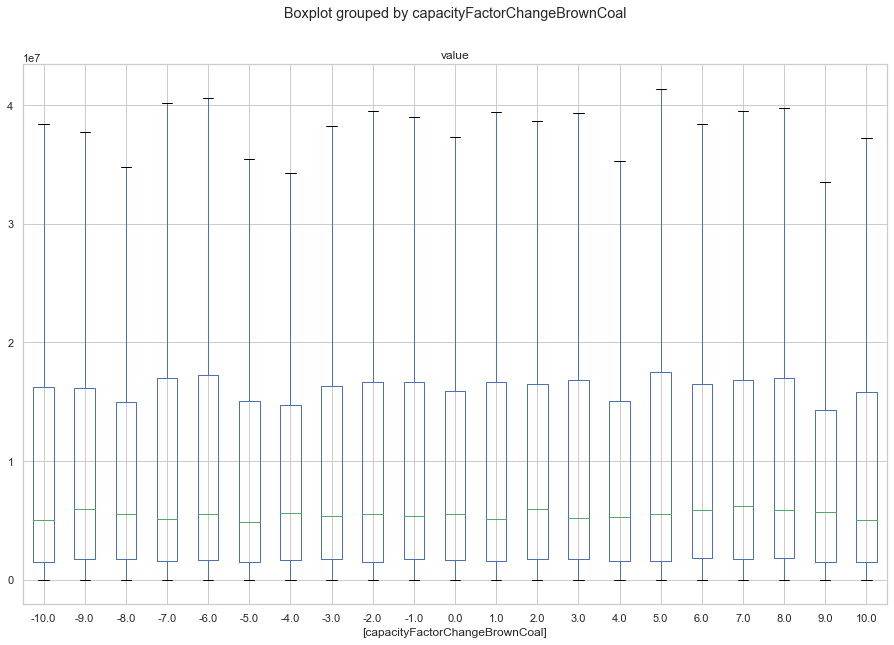

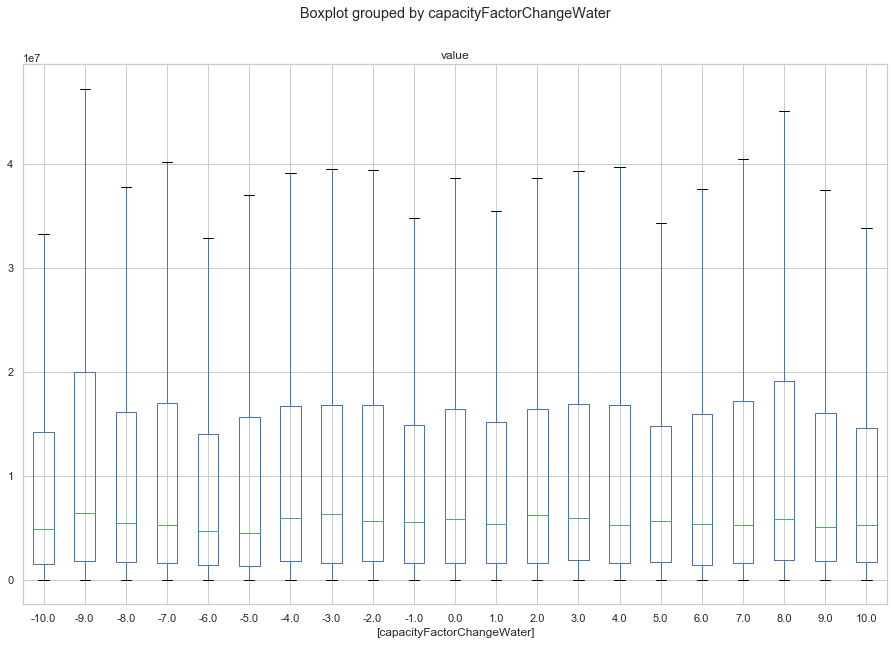

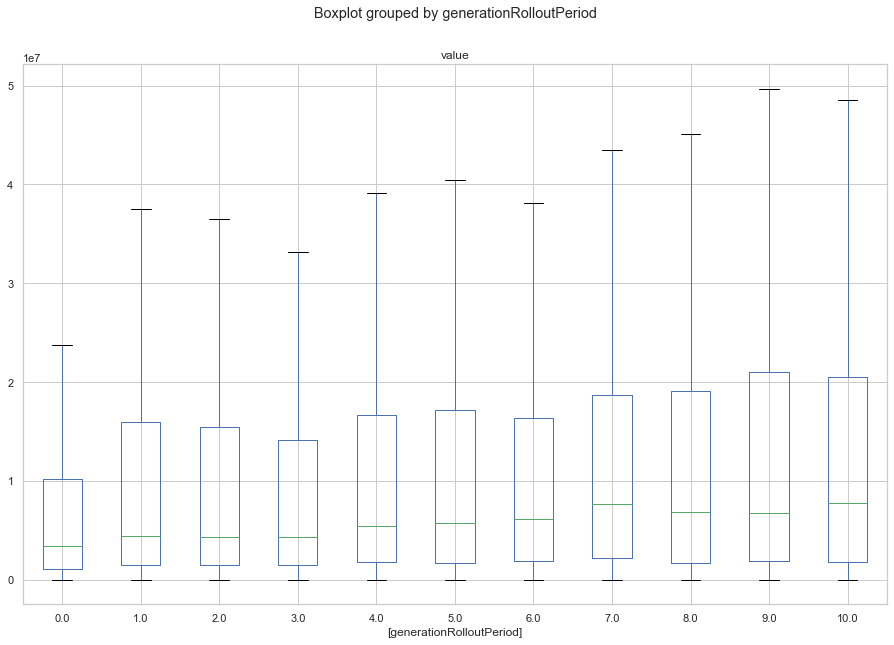

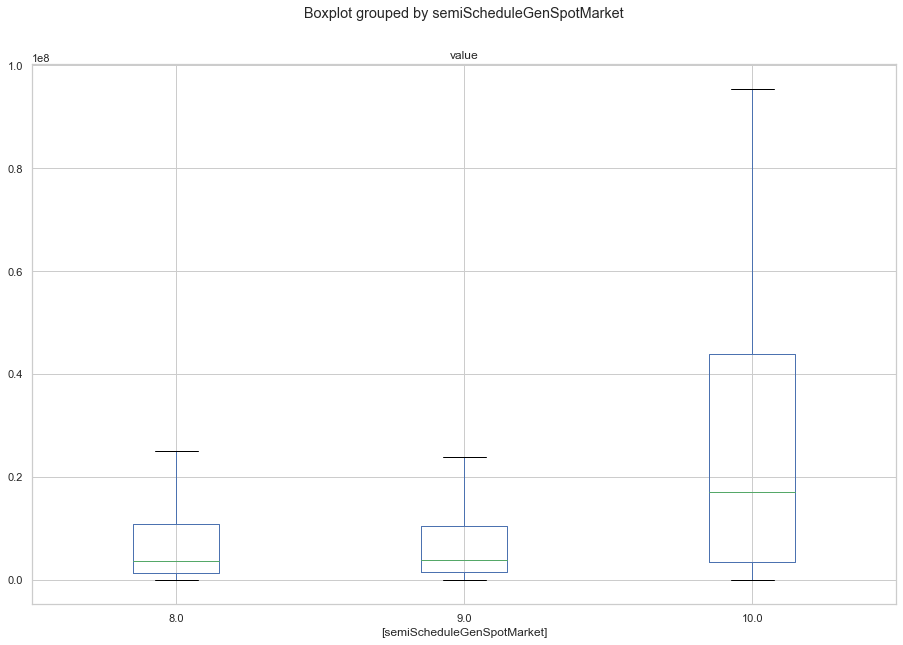

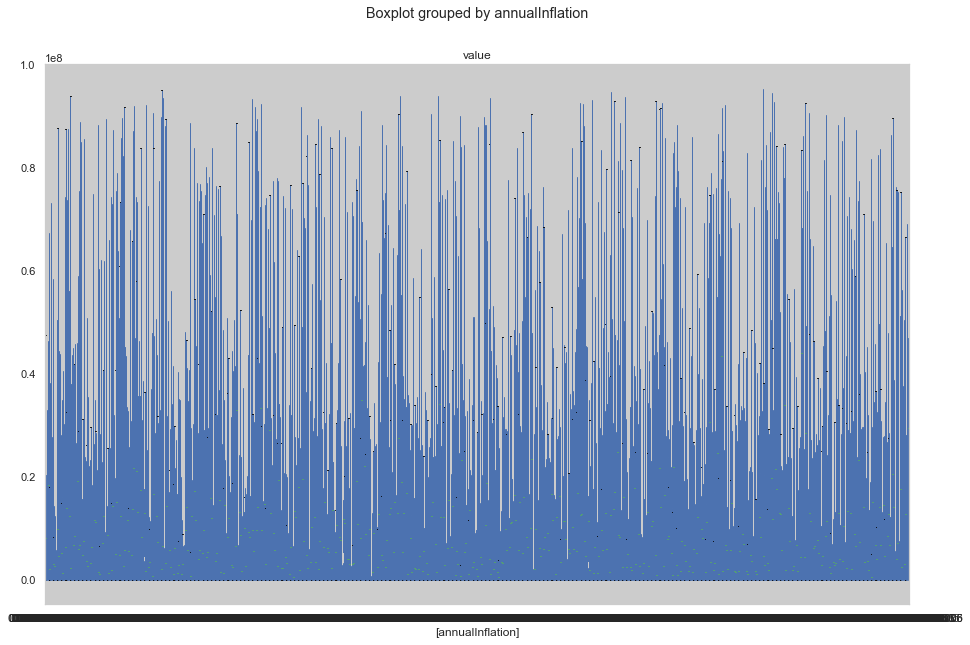

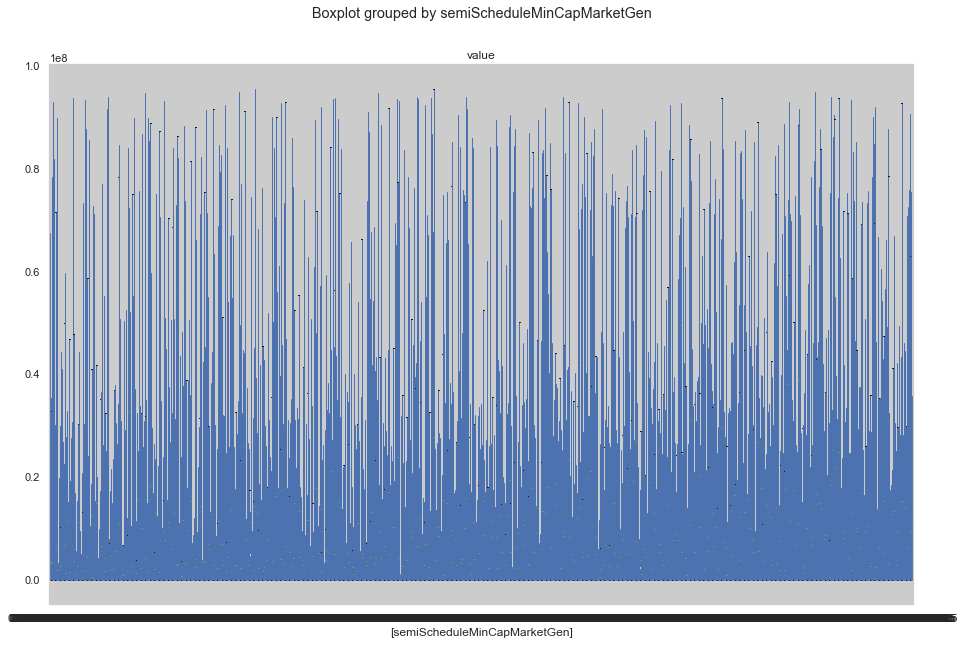

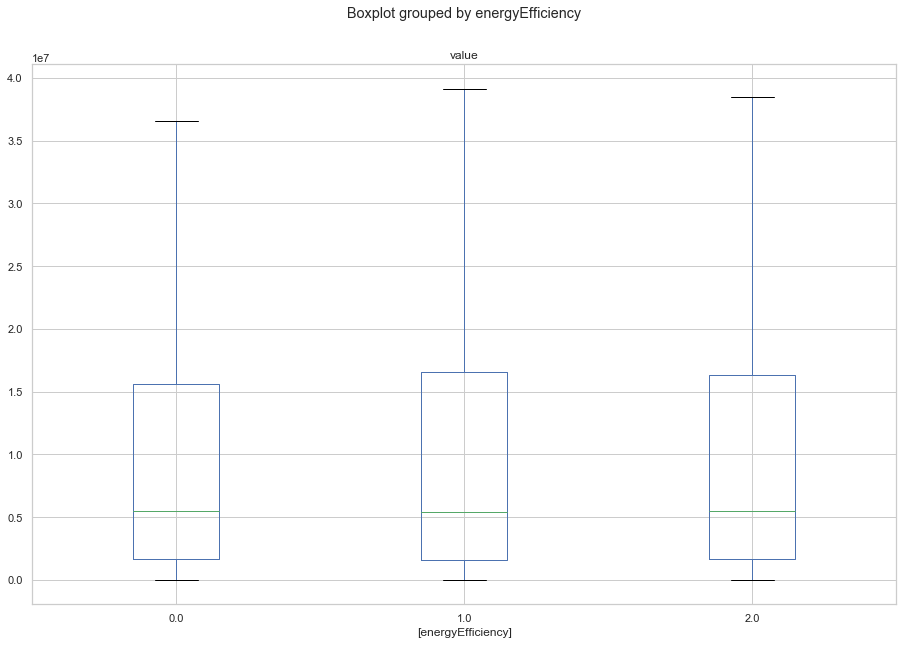

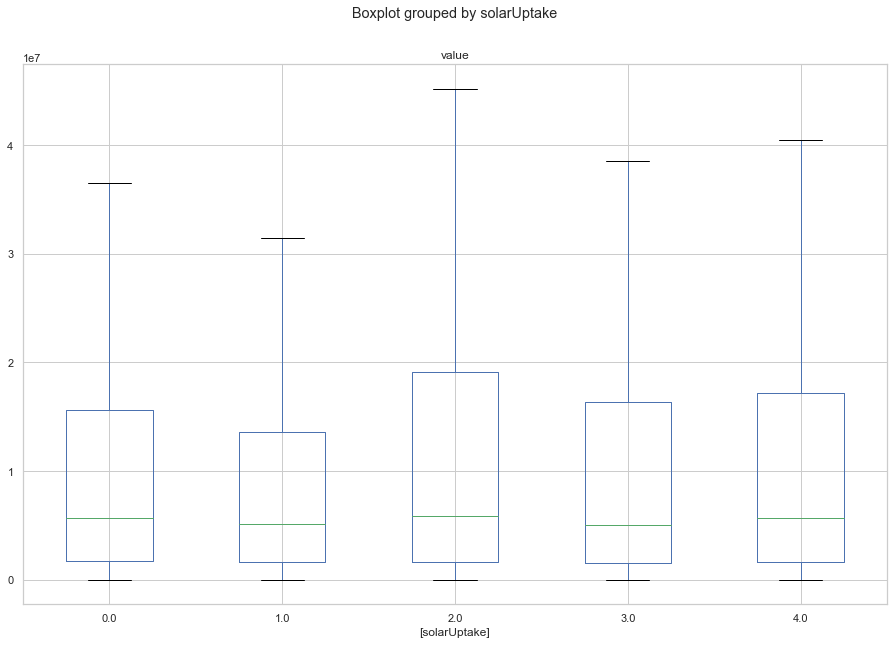

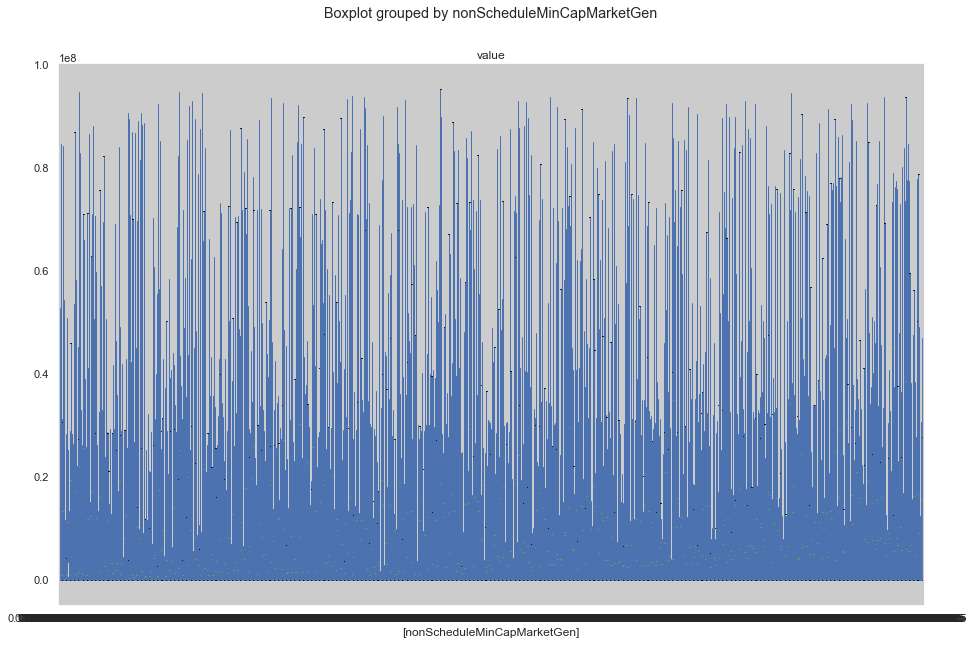

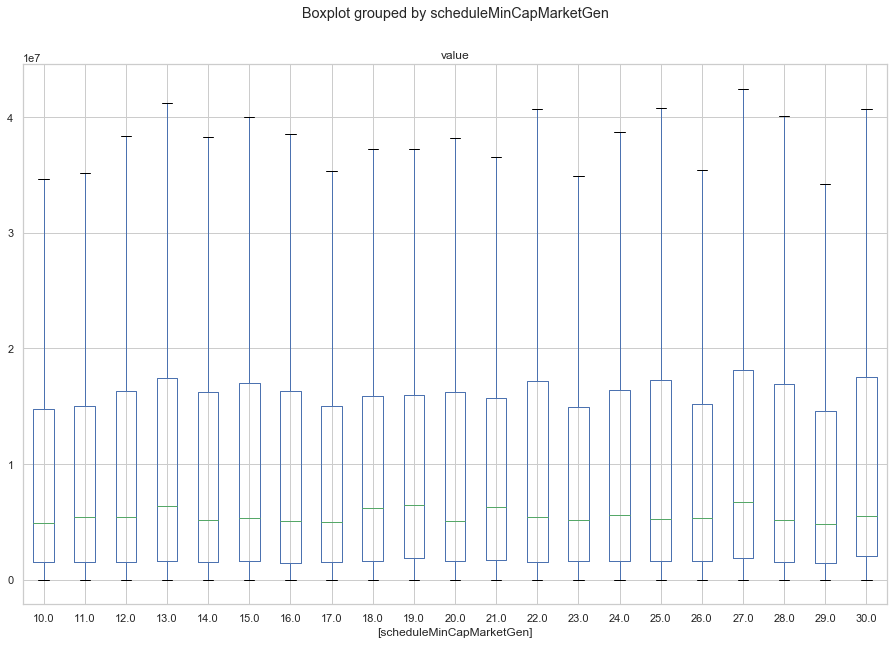

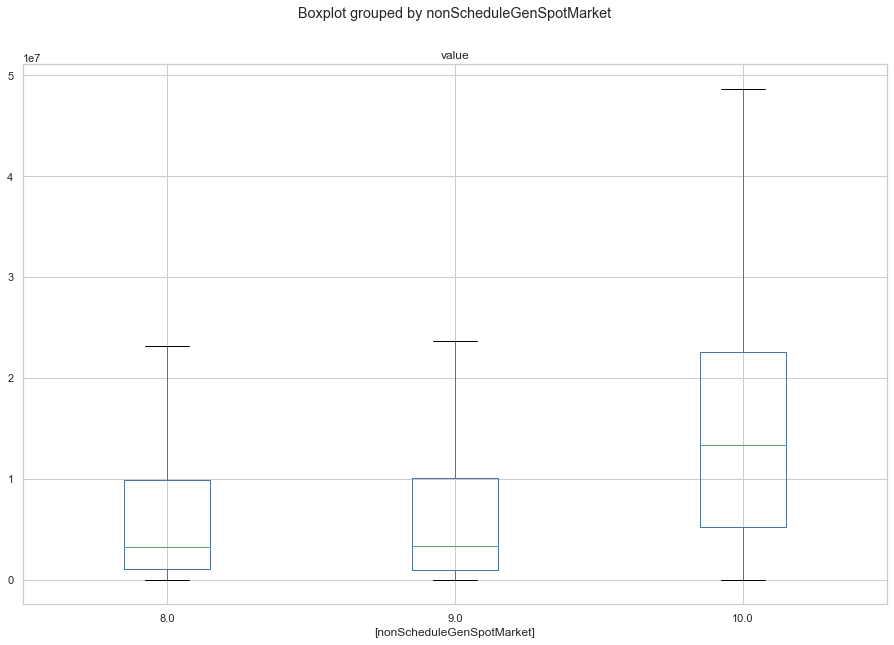

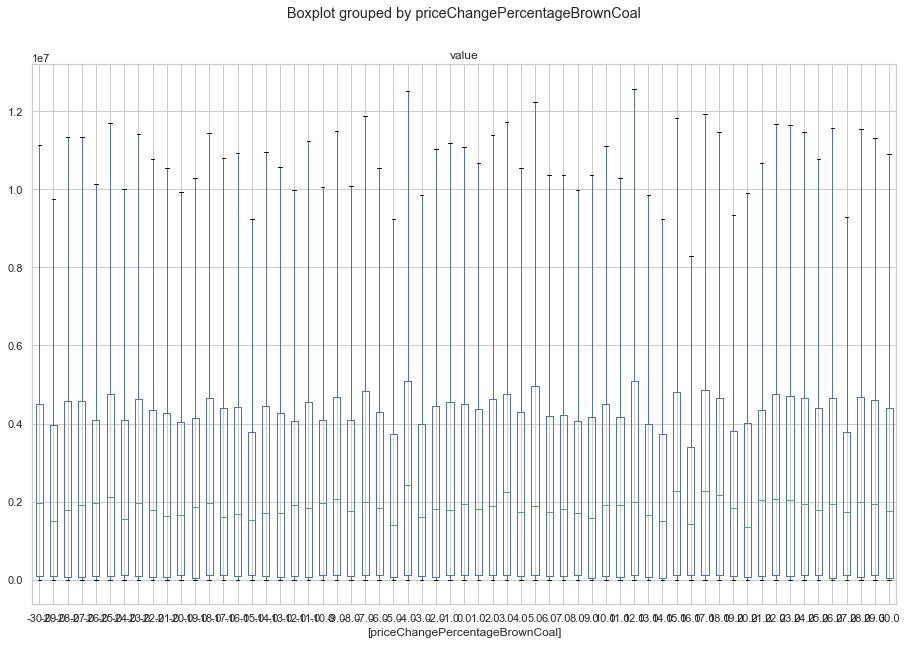

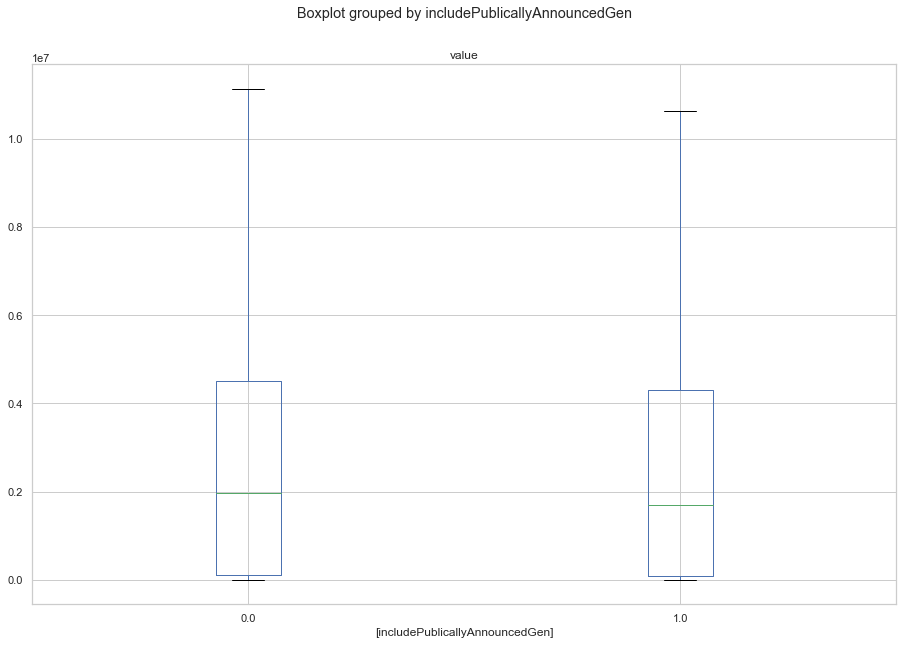

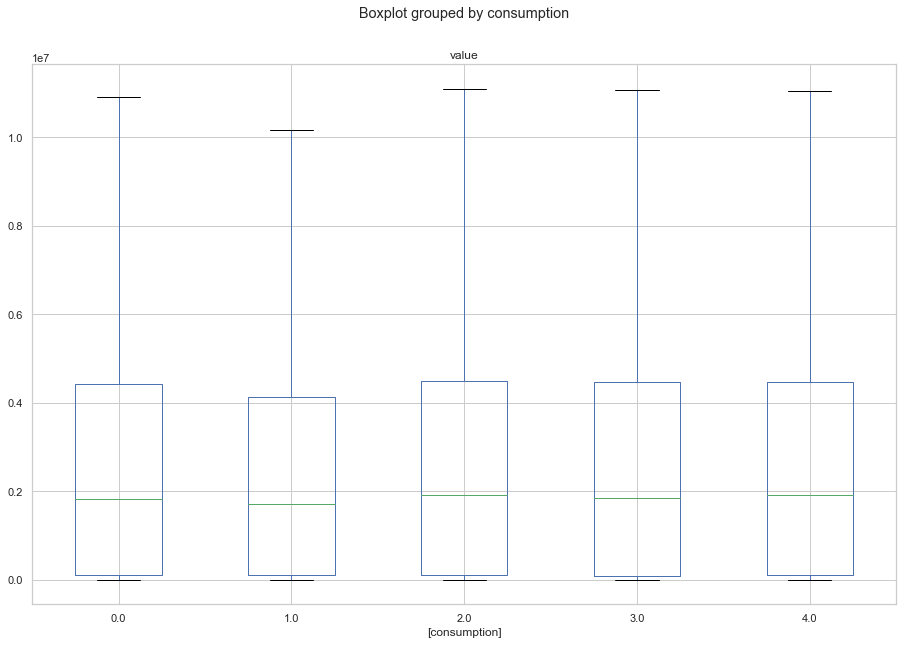

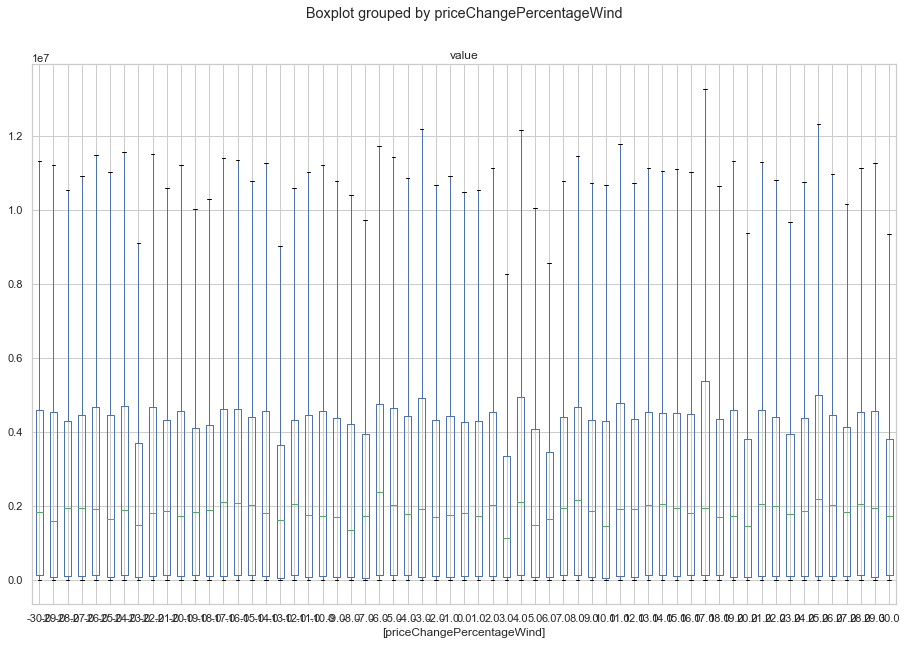

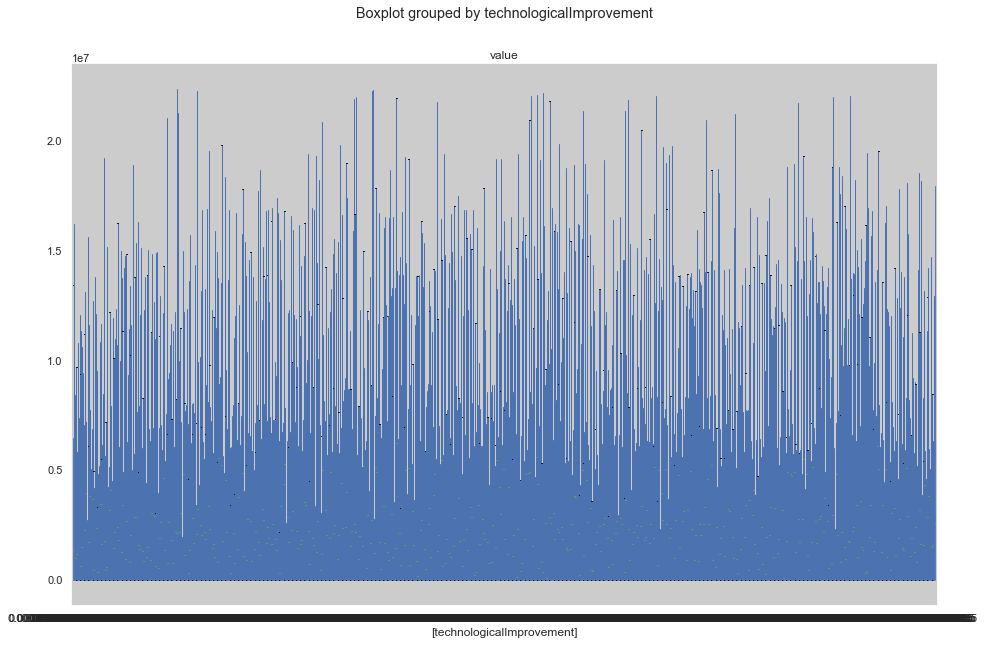

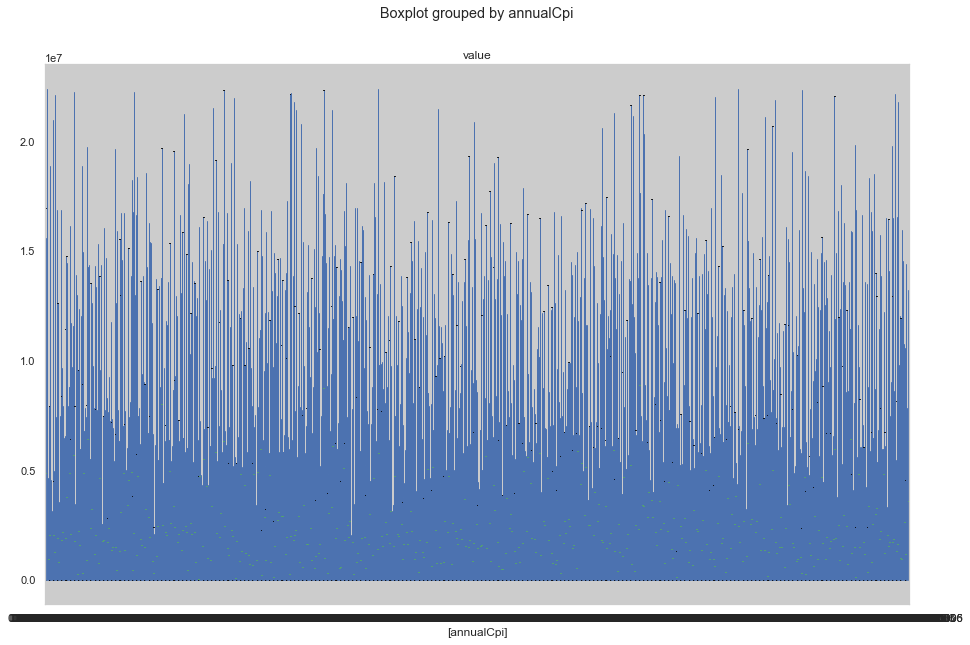

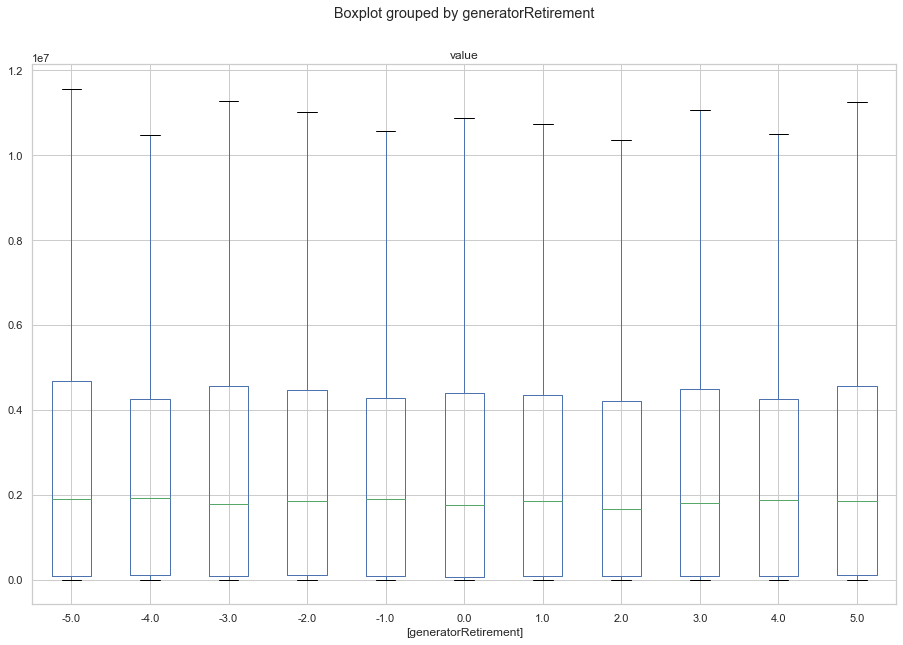

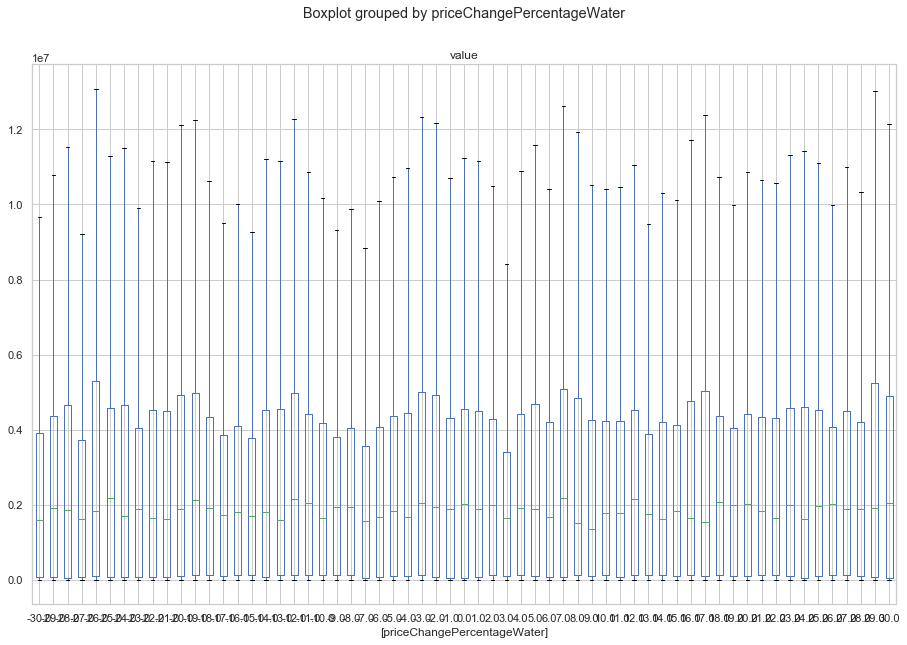

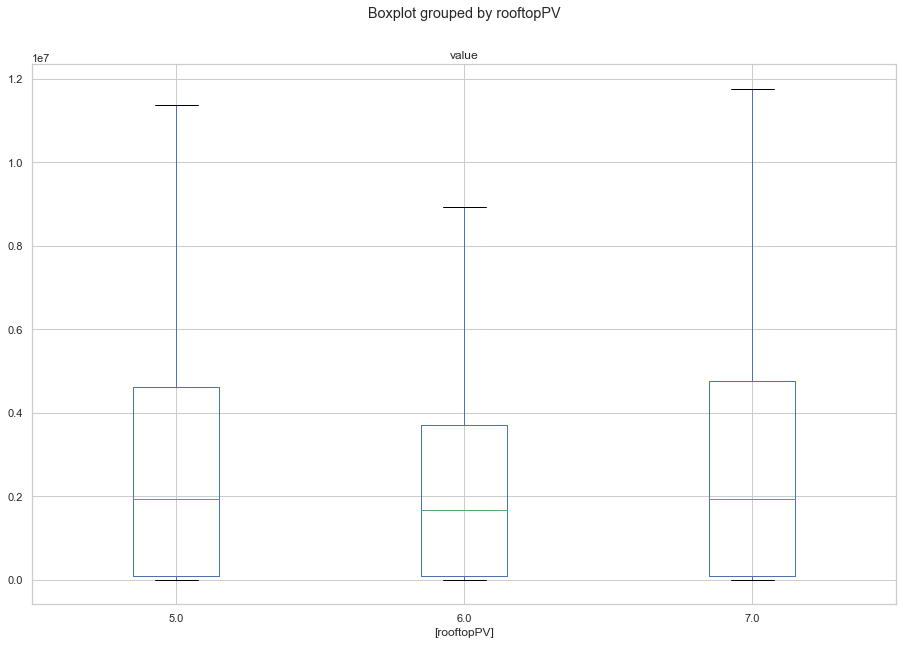

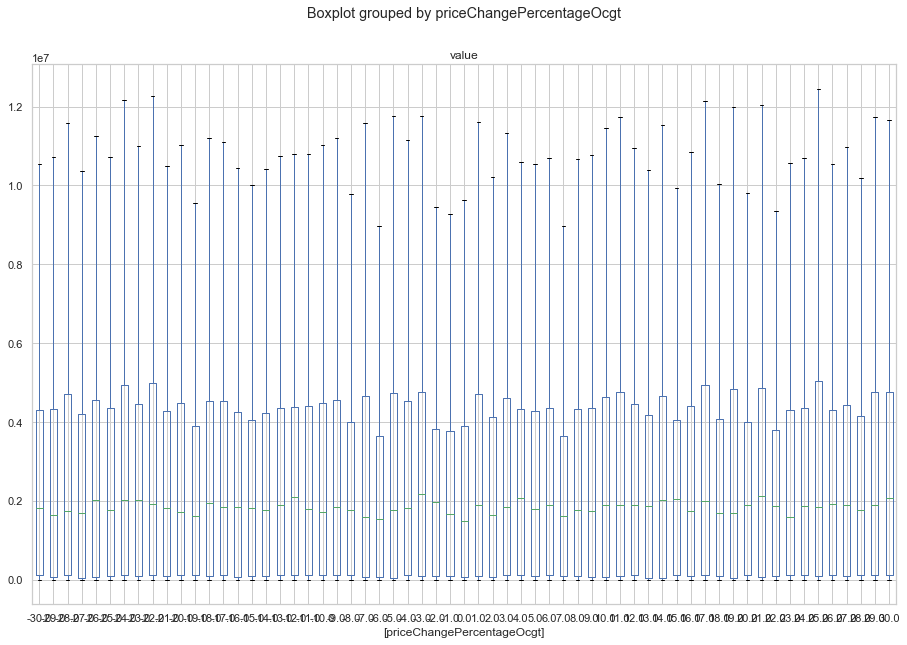

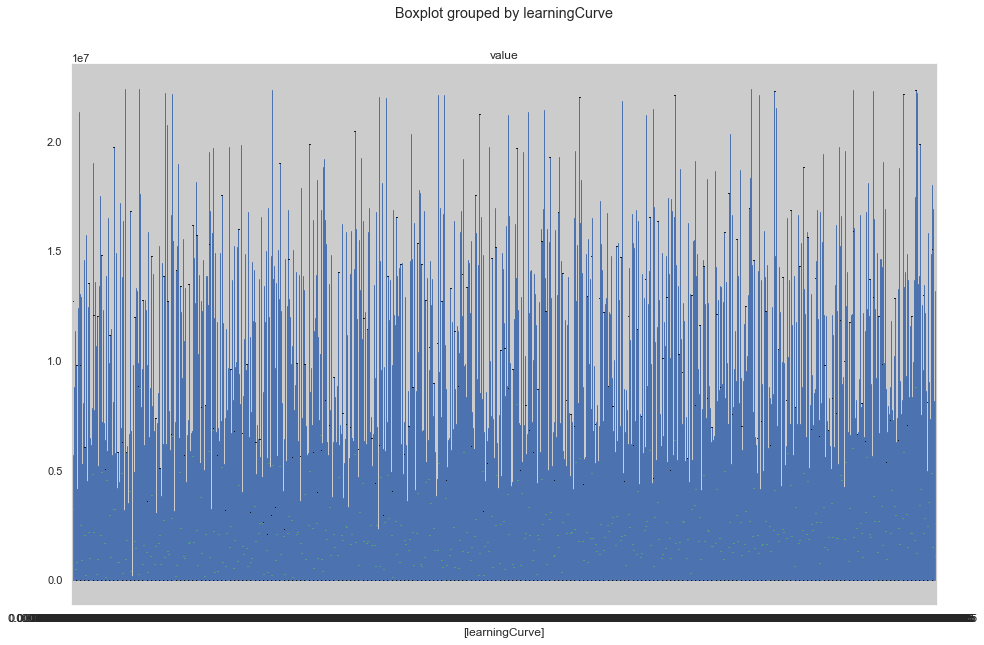

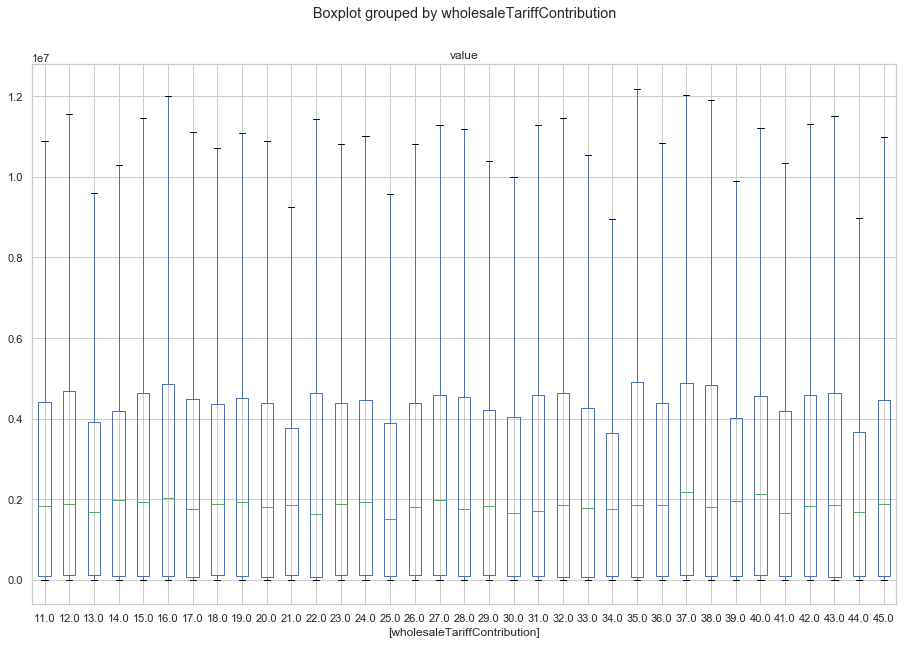

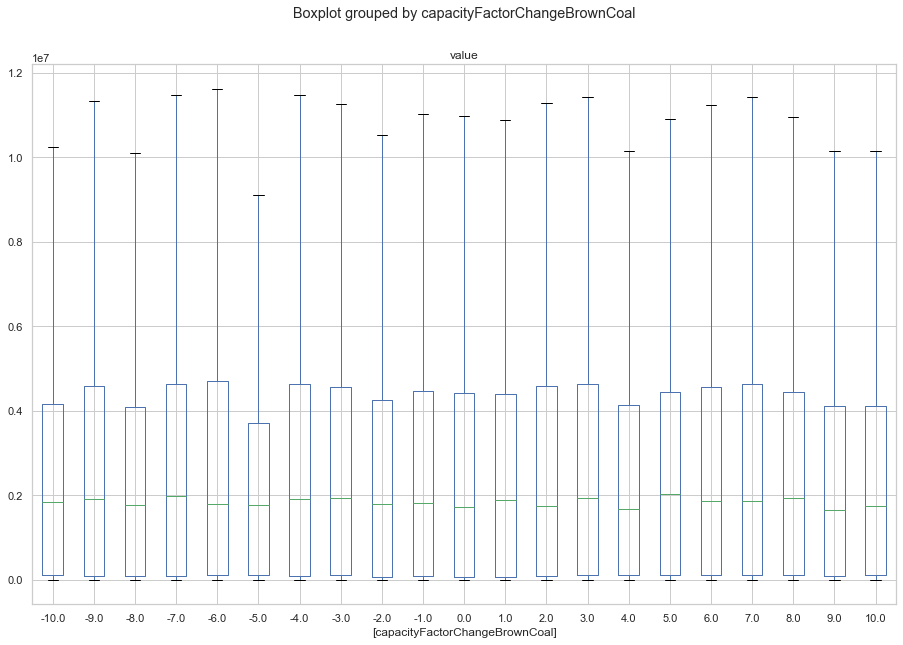

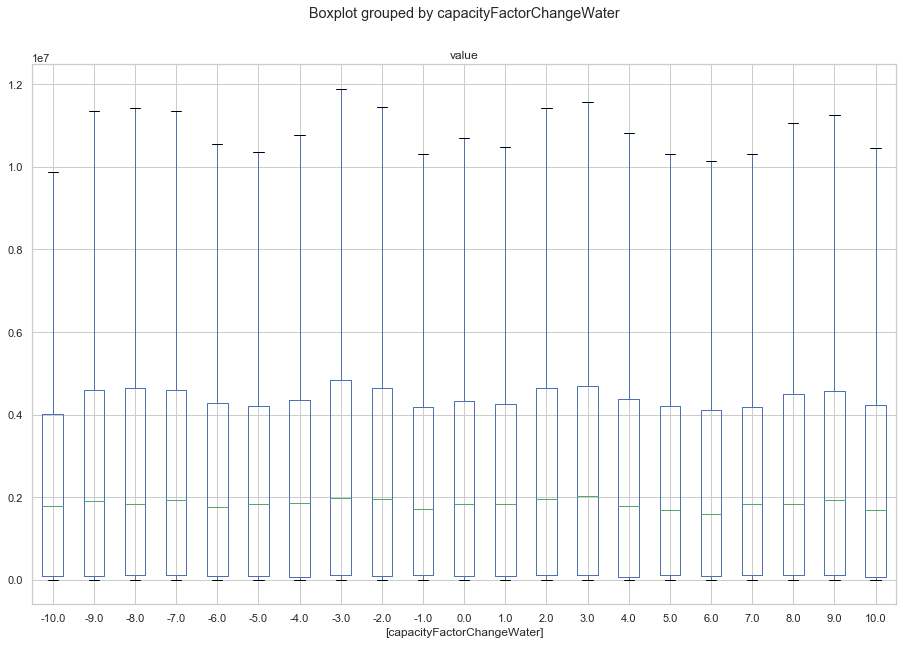

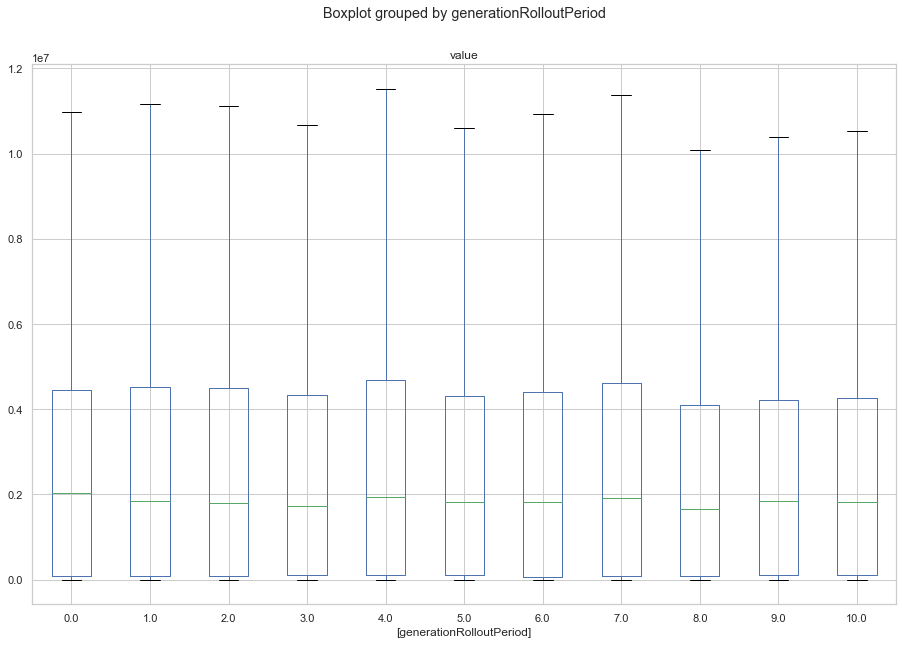

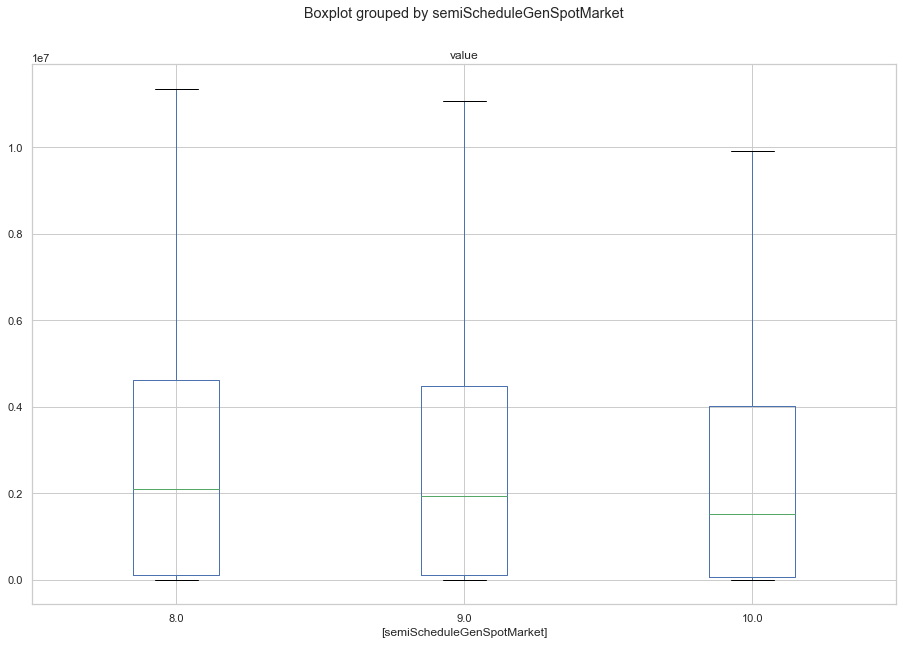

In [ ]:
for ooi in outcomes_to_show:
    data = outcomes[ooi][:, startYearShift:]
    
 
    for n in uncertainties:
        dfBoxPlot = pd.DataFrame(index = index, data = data.T,columns=[ experiments[n] ])
        dfMeltdfBoxPlot = pd.melt(dfBoxPlot)
        #dfMeltdfBoxPlot.rename(columns={"value":ooi})
    
        ax = dfMeltdfBoxPlot.boxplot(by=n, meanline=True, showmeans=False, showcaps=True, 
                        showbox=True, showfliers=False, return_type='axes', figsize=(15, 10))
        
        
        plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_sobol_boxplots_%s_%s'%(ooi,n)), 
                     dpi=300, bbox_inches='tight')
        
       
        plt.show()
        plt.close()
 
